# Проект Телеком

## Название проекта: Прогноз оттока клиентов компании TeleDom

### Цели и задачи проекта

**Цель:** Основная цель проекта TeleDom Churn Prediction — разработать модель машинного обучения, которая сможет точно предсказать, будет ли отток клиентов, что позволит TeleDom активно взаимодействовать с клиентами, подверженными риску оттока, предлагая промокоды и специальные условия, чтобы сохранить их.

**Цели:**
1. Анализировать данные о клиентах и определять ключевые факторы, способствующие оттоку клиентов.
2. Предварительно обработать и очистить данные, чтобы они были пригодны для моделирования.
3. Сравнить различные алгоритмы машинного обучения и выбрать тот, который обеспечивает лучший показатель ROC-AUC.
4. Точная настройка модели для достижения показателя ROC-AUC не менее 0.85, что обеспечит высокий уровень точности прогнозирования оттока.
5. Представить результаты и практические идеи, которые могут стать основой для стратегий удержания клиентов TeleDom.

### Критерий успеха

Проект будет считаться успешным, если он соответствует следующим критериям:

- **Анализ данных.** Проводится комплексный исследовательский анализ данных, и данные о факторах, влияющих на отток, четко документируются.
- **Эффективность модели.** Окончательная прогностическая модель достигает показателя ROC-AUC не менее 0.85 в наборе тестовых данных.
- **Интерпретируемость.** Решения модели можно интерпретировать и понимать, что позволяет получить действенную бизнес-идею.
- **Влияние на бизнес.** Результаты модели позволяют разработать рекомендации, реализация которых потенциально может повысить уровень удержания клиентов.

In [1]:
!pip install -q optuna

In [2]:
!pip install -q phik

In [3]:
# Импорт стандартной библиотеки
import matplotlib.pyplot as plt

# Соответствующий сторонний импорт
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import optuna
from optuna.trial import Trial
from xgboost import XGBClassifier
from phik import resources, report
import phik
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## 1. Извлечение данных

In [4]:
# Конфигурация базы данных
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-final'
}

# Создадим подключение к базе данных
connection_string = (
    f"postgresql://{db_config['user']}:{db_config['pwd']}@"
    f"{db_config['host']}:{db_config['port']}/{db_config['db']}"
)
engine = create_engine(connection_string)

# Посмотрим какие схемы и таблицы есть в этой базе данных
query = "SELECT * FROM pg_catalog.pg_tables WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';"
available_tables = pd.read_sql_query(query, con=engine)
display(available_tables)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,steel,data_arc,praktikum_admin,None,False,False,False,False
1,steel,data_bulk,praktikum_admin,None,False,False,False,False
2,steel,data_bulk_time,praktikum_admin,None,False,False,False,False
3,steel,data_gas,praktikum_admin,None,False,False,False,False
4,steel,data_temp,praktikum_admin,None,False,False,False,False
5,steel,data_wire,praktikum_admin,None,False,False,False,False
6,steel,data_wire_time,praktikum_admin,None,False,False,False,False
7,telecom,contract,praktikum_admin,None,False,False,False,False
8,telecom,internet,praktikum_admin,None,False,False,False,False
9,telecom,personal,praktikum_admin,None,False,False,False,False


In [5]:
# Функция загрузки данных из таблицы
def load_data(schema, table_name):
    query = f"SELECT * FROM {schema}.{table_name}"
    return pd.read_sql_query(query, con=engine)

# Загрузим данные контракта и отобразим первые несколько строк.
contract_data = load_data('telecom', 'contract')
print("Таблица Contract: данные контракта включают подробную информацию о контракте клиента, "\
       "например, даты начала и окончания, тип платежа и сборы.")
display(contract_data.head())

# Загрузим персональные данные и отобразим первые несколько строк.
personal_data = load_data('telecom', 'personal')
print()
print("Таблица Personal: персональные данные содержат демографическую информацию о клиенте, "\
       "включая пол, являются ли они пожилыми людьми и семейное положение.")
display(personal_data.head())

# Загрузим интернет-данные и отобразим первые несколько строк.
internet_data = load_data('telecom', 'internet')
print()
print("Таблица Internet: интернет-данные отражают тип интернет-услуги, которую имеет клиент: "\
       "а также дополнительные функции, такие как онлайн-безопасность и услуги резервного копирования.")
display(internet_data.head())

# Загрузим данные телефона и отобразим первые несколько строк.
phone_data = load_data('telecom', 'phone')
print()
print("Таблица Phone: данные телефона уточняют, есть ли у клиента несколько линий.")
display(phone_data.head())

Таблица Contract: данные контракта включают подробную информацию о контракте клиента, например, даты начала и окончания, тип платежа и сборы.


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65



Таблица Personal: персональные данные содержат демографическую информацию о клиенте, включая пол, являются ли они пожилыми людьми и семейное положение.


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Таблица Internet: интернет-данные отражают тип интернет-услуги, которую имеет клиент: а также дополнительные функции, такие как онлайн-безопасность и услуги резервного копирования.


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No



Таблица Phone: данные телефона уточняют, есть ли у клиента несколько линий.


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


In [6]:
# Заменим имена столбцов cN именами первых строк в обеих таблицах.

# Для интернет-данных
new_header = internet_data.iloc[0]  # Захватываем первую строку для заголовка
internet_data = internet_data[1:]   # Берем данные за вычетом строки заголовка
internet_data.columns = new_header  # Устанавливаем строку заголовка в качестве заголовка датафрейма

# Для данных телефона
new_header = phone_data.iloc[0]  # Захватываем первую строку для заголовка
phone_data = phone_data[1:]      # Берем данные за вычетом строки заголовка
phone_data.columns = new_header  # Устанавливаем строку заголовка в качестве заголовка датафрейма

display(internet_data.head())
display(phone_data.head())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


## 2. Исследовательский Анализ и Предобработка

In [7]:
# Проверка пропущенных значений и типов данных в каждой таблице
missing_values = {
    "personal_data": personal_data.isnull().sum(),
    "contract_data": contract_data.isnull().sum(),
    "internet_data": internet_data.isnull().sum(),
    "phone_data": phone_data.isnull().sum()
}

data_types = {
    "personal_data": personal_data.dtypes,
    "contract_data": contract_data.dtypes,
    "internet_data": internet_data.dtypes,
    "phone_data": phone_data.dtypes
}

# Создание DataFrames для отсутствующих значений и типов данных
missing_values_df = pd.DataFrame(missing_values)
data_types_df = pd.DataFrame(data_types)

# Отобразим DataFrames
print("Пропущенные значения в каждом наборе данных:")
display(missing_values_df)
print("\nТипы данных в каждом наборе данных:")
display(data_types_df)

Пропущенные значения в каждом наборе данных:


,personal_data,contract_data,internet_data,phone_data
BeginDate,NaN,0.0,NaN,NaN
Dependents,0.0,NaN,NaN,NaN
DeviceProtection,NaN,NaN,0.0,NaN
EndDate,NaN,5174.0,NaN,NaN
InternetService,NaN,NaN,0.0,NaN
MonthlyCharges,NaN,0.0,NaN,NaN
MultipleLines,NaN,NaN,NaN,0.0
OnlineBackup,NaN,NaN,0.0,NaN
OnlineSecurity,NaN,NaN,0.0,NaN
PaperlessBilling,NaN,0.0,NaN,NaN



Типы данных в каждом наборе данных:


,personal_data,contract_data,internet_data,phone_data
BeginDate,NaN,object,NaN,NaN
Dependents,object,NaN,NaN,NaN
DeviceProtection,NaN,NaN,object,NaN
EndDate,NaN,object,NaN,NaN
InternetService,NaN,NaN,object,NaN
MonthlyCharges,NaN,float64,NaN,NaN
MultipleLines,NaN,NaN,NaN,object
OnlineBackup,NaN,NaN,object,NaN
OnlineSecurity,NaN,NaN,object,NaN
PaperlessBilling,NaN,object,NaN,NaN


**Отсутствующие значения**

1. **Личные данные**: пропущенных значений нет.
2. **Данные контракта**: отсутствуют значения в полях «**EndDate**» и «**TotalCharges**».  
     - Отсутствующие значения в поле **EndDate**, скорее всего, указывают на клиентов, которые все еще активны (т. е. не ушли). Их следует обрабатывать соответствующим образом при создании целевой переменной.  
     - Необходимо изучить и обработать недостающие значения в TotalCharges.


3. **Данные Интернета**: пропущенных значений нет, но имена столбцов необходимо переименовать для ясности.
4. **Данные телефона**: пропущенных значений нет, но названия столбцов необходимо переименовать для ясности.

**Типы данных**

- '**BeginDate**' и '**EndDate**' в данных контракта должны быть преобразованы в дату и время.
- '**TotalCharges**' в данных контракта должен иметь числовой тип (float).
- Столбец «**SeniorCitizen**» в личных данных, хотя и числовой, представляет собой двоичную категорию и может рассматриваться как категориальная переменная.

In [8]:
# Обработка пропущенных значений в TotalCharges
# Преобразование TotalCharges в числовое значение, установка error='coerce' для преобразования проблемных значений в NaN
contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'], errors='coerce')

# Заполнение пропущенных значений в TotalCharges значением MonthlyCharges для клиентов с значением BeginDate, равным
# дате извлечения данных (предполагается, что это новые клиенты)
contract_data.loc[(contract_data['TotalCharges'].isnull()) & (contract_data['BeginDate'] == '2020-02-01'), 
                  'TotalCharges'] = contract_data['MonthlyCharges']

# Преобразование 'BeginDate' и 'EndDate' в datetime
contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'])

# Для «EndDate» сначала заменим индикаторы неушедших клиентов на согласованный формат.
contract_data['EndDate'] = contract_data['EndDate'].replace({'No': None})
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'])

# Создайте двоичную целевую переменную для оттока
contract_data['Churn'] = contract_data['EndDate'].notnull().astype(int)

# Проверка преобразований
display(contract_data.head())
display(internet_data.head())
display(phone_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


***Преобразования и обработка пропущенных значений успешно применены:***

**Данные Контракта**:
     - Преобразованы BeginDate и EndDate в datetime.
     - Заполнены пропущенные значения TotalCharges для новых клиентов (чья BeginDate равна дате извлечения данных) их MonthlyCharges.
     - Создана двоичная целевая переменная Churn (1 — отток, 0 — не отток).

In [9]:
# Объединение данных
merged_data = pd.merge(personal_data, contract_data, on='customerID', how='left')
merged_data = pd.merge(merged_data, internet_data, on='customerID', how='left')
merged_data = pd.merge(merged_data, phone_data, on='customerID', how='left')

# Обеспечение того, чтобы у каждого клиента была только одна запись
merged_data_duplicates = merged_data.duplicated(subset=['customerID']).sum()

# Проверка объединенных данных и наличия дубликатов.
display(merged_data.head()) 
print("Количество дубликатов: {}".format(merged_data_duplicates))

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,Churn,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,NaT,Month-to-month,Yes,Electronic check,...,29.85,0,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2019-03-26,NaT,One year,No,Mailed check,...,1889.50,0,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,...,108.15,1,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2018-12-22,NaT,One year,No,Bank transfer (automatic),...,1840.75,0,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,...,151.65,1,Fiber optic,No,No,No,No,No,No,No


Количество дубликатов: 0


*Данные из всех четырех таблиц были успешно объединены в один DataFrame. Каждый клиент представлен только одной записью, на что указывает отсутствие дубликатов.*

**Обзор объединенных данных**

- Объединенный набор данных содержит различные атрибуты клиентов, включая личные данные, информацию о контрактах, интернет-услугах и телефонных услугах, а также статус оттока.


In [10]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           1869 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  Churn             7043 non-null   int64         
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

In [11]:
# Обработка пропущенных значений для TotalCharges - замена медианой
merged_data['TotalCharges'] = merged_data['TotalCharges'].fillna(merged_data['TotalCharges'].median())

# В столбцах, указывающих услуги, заменим NaN на «No», чтобы указать, что у клиента нет этой услуги.
columns_to_replace_na = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                         'DeviceProtection', 'TechSupport', 'StreamingTV', 
                         'StreamingMovies', 'MultipleLines']

for column in columns_to_replace_na:
    merged_data[column] = merged_data[column].fillna('No')

# Подтвердим изменения
missing_values_after = merged_data.isnull().sum()
missing_values_after

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
MultipleLines          0
dtype: int64

In [12]:
# Рассчитаем срок действия договора в днях
merged_data['ContractDuration'] = (
    merged_data['EndDate'].fillna(pd.to_datetime('2020-02-01')) - merged_data['BeginDate']
).dt.days

In [13]:
merged_data.isnull().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
MultipleLines          0
ContractDuration       0
dtype: int64

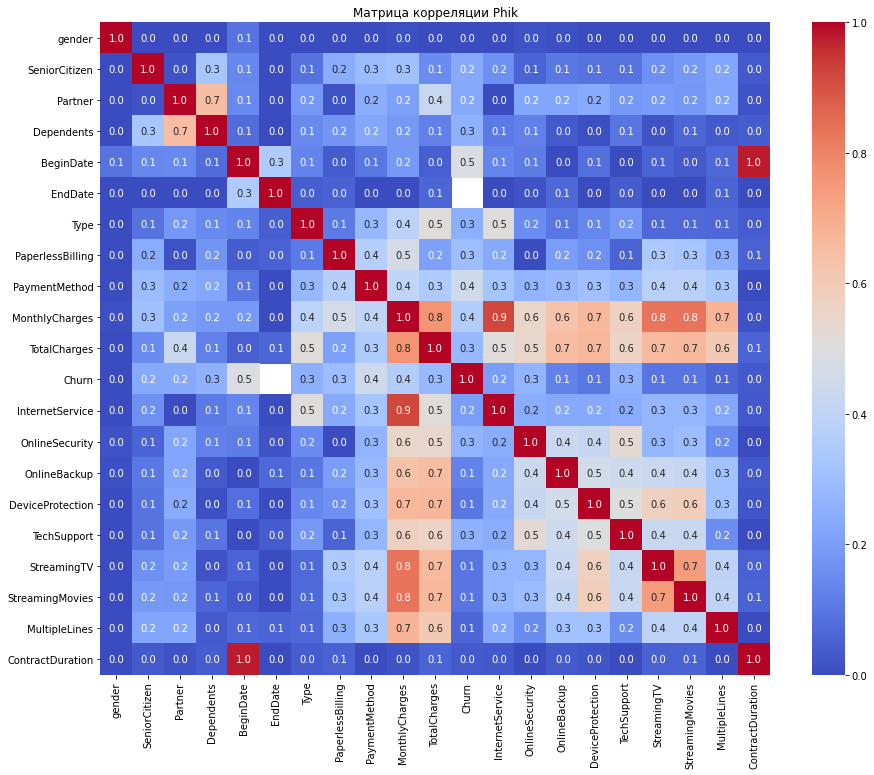

In [14]:
# Явно определим интервальные (непрерывные) столбцы, если предположение по умолчанию не подходит.
interval_cols = ['SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'ContractDuration']

# Исключим «customerID» из анализа, поскольку это уникальный идентификатор.
data_for_correlation = merged_data.drop(columns=['customerID'])

# Вычислим матрицу корреляции phik с указанными интервальными столбцами
phik_overview = data_for_correlation.phik_matrix(interval_cols=interval_cols)

# Построение корреляционной матрицы phik
plt.figure(figsize=(15, 12))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Матрица корреляции Phik')
plt.show()

**Матрица корреляции Phik** для различных признаков набора данных, где коэффициент корреляции Фика используется для измерения связи между переменными, включая категориальные, порядковые и интервальные переменные, с которыми традиционные коэффициенты корреляции, такие как Пирсона, не могут справиться.

Вот некоторые интерпретации данной матрицы корреляции Phik:

1. **Высокая корреляция с оттоком**. Такие признаки, как ***'MonthlyCharges'***, ***'PaperlessBilling'*** и ***'Type'***, демонстрируют относительно более высокую корреляцию с ***'Churn'***, что означает, что они могут быть важными факторами в прогнозировании оттока клиентов. Более высокие ежемесячные платежи и выбор безбумажного выставления счетов, похоже, положительно связаны с оттоком клиентов.

2. **Признаки, связанные с сервисами**. Такие признаки, как ***OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV и StreamingMovies***, также демонстрируют умеренную корреляцию друг с другом. Это говорит о том, что клиенты, у которых есть одна из этих услуг, с большей вероятностью будут пользоваться и другими.

3. **Демографические признаки**: ***«gender»*** имеет очень низкую корреляцию с большинством признаков, что позволяет предположить, что в данном контексте он не может быть сильным предиктором. С другой стороны, ***«Partner» и «Dependents»*** умеренно коррелируют, что указывает на то, что клиенты с партнерами с большей вероятностью будут иметь иждивенцев.

4. **Продолжительность контракта**: ***«ContractDuration»*** имеет сильную корреляцию с ***«TotalCharges»***, что ожидаемо, поскольку чем дольше срок действия контракта, тем больше общих расходов накопит клиент. Интересно, что ***«ContractDuration»*** не показывает сильной прямой корреляции с ***«Churn»***, что позволяет предположить, что простое наличие длинного контракта не указывает напрямую на более высокую или меньшую вероятность оттока.

5. **Высокие значения Phik**. Некоторые переменные имеют значение Phik, равное 1,0, что обычно указывает на идеальную корреляцию между собой (диагональ сверху слева направо вниз) или возможную ошибку в расчете, если она происходит не по диагонали.

6. **Интервальные переменные**. Интервальные переменные (***«SeniorCitizen», «MonthlyCharges», «TotalCharges», «Churn», «ContractDuration»***), похоже, имеют различную степень связи с другими переменными, что и следовало ожидать, поскольку они бывают разных типов и масштабов.

Однако надо иметь в виду, что, хотя корреляция Phik может обрабатывать разные типы данных, важно дополнительно изучить природу этих отношений. Высокая корреляция не предполагает причинно-следственной связи, и на нее могут влиять другие факторы, не включенные в набор данных.

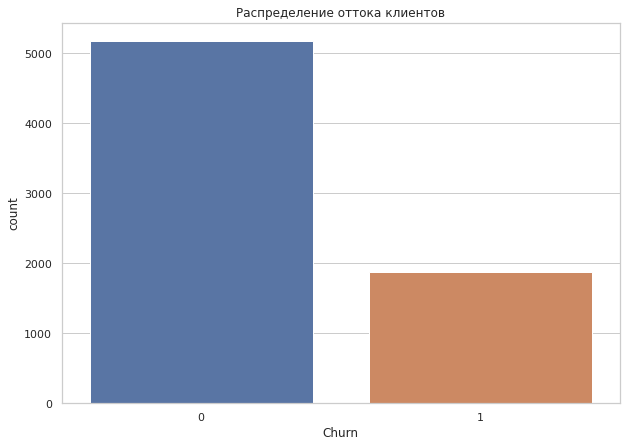

In [15]:
# Задание эстетического стиля для графиков
sns.set(style="whitegrid")

# Проведение исследовательского анализа
# 1. Распределение оттока
plt.figure(figsize=(10, 7))
sns.countplot(x='Churn', data=merged_data)
plt.title('Распределение оттока клиентов')
plt.show()

На графике есть два столбика:

1. Первая полоса, помеченная «0», значительно выше второй, что указывает на большее количество клиентов, которые не ушли.
2. Вторая полоса, помеченная цифрой «1», представляет ушедших клиентов и имеет меньшую высоту.

Также график указывает на ***дисбаланс данных*** об оттоке клиентов. Дисбаланс данных относится к ситуации, когда количество наблюдений в одном классе значительно превышает количество наблюдений в другом, что ***часто может возникать в наборах данных, связанных с оттоком данных***, поскольку отток клиентов можно считать редким событием.

В частности, полоса, представляющая клиентов, которые не ушли ('0'), намного больше, чем полоса для клиентов, которые ушли ('1'). Это говорит о том, что:

- В наборе данных гораздо больше неутекших клиентов, чем ушедших.
- Любая прогнозирующая модель, обученная на этих данных, может быть склонна предсказывать отсутствие оттока просто потому, что она видела больше примеров этого класса.
- Модели могут работать хорошо с точки зрения общей точности, просто предсказывая класс большинства, но они могут быть неэффективны при обнаружении класса меньшинства, который часто представляет больший интерес.

Имея дело с несбалансированным набором данных, ***крайне важно сосредоточиться на способности модели точно предсказывать класс меньшинства, поскольку это часто более ценно с точки зрения бизнеса***.

## 3. Обучение Моделей

In [16]:
# Случайное состояние для воспроизводимости - дата начала проекта
RANDOM_STATE = 150124

# Сначала разделим данные
X = merged_data.drop(['customerID', 'BeginDate', 'EndDate', 'Churn'], axis=1)
y = merged_data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Создадим явные копии, чтобы избежать SettingWithCopyWarning.
X_train = X_train.copy()
X_test = X_test.copy()

In [17]:
# Определим столбцы для применения различных типов кодировки
one_hot_cols = ['PaymentMethod', 'InternetService']
binary_cols = ['PaperlessBilling', 'gender', 'Partner', 'Dependents', 'MultipleLines',
              'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
              'StreamingTV', 'StreamingMovies']

# Применение двоичного кодирования
for col in binary_cols:
    X_train[col] = X_train[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})
    X_test[col] = X_test[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})    

# Применение порядкового кодирования
X_train['Type'] = X_train['Type'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
X_test['Type'] = X_test['Type'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

# Предварительная обработка числовых признаков
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Предварительная обработка номинальных признаков
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Пакетная предварительная обработка числовых и категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, one_hot_cols)
    ])

# Подгонка и преобразование обучающего набора, преобразование тестового набора
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Подтвердить разделение
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((5282, 23), (1761, 23), (5282,), (1761,))

Набор данных был успешно разделен на обучающий и тестовый наборы:

- Обучающий набор: 5282 образца.
- Тестовый набор: 1761 образец.
- Признаков в каждом наборе: 23 признаков.
- Целевая переменная («Отток»): присутствует как в обучающих, так и в тестовых наборах.

Этапы предварительной обработки успешно завершены:

1. **Обработка категориальных переменных**:

- Если категориальные переменные являются порядковыми, использование **ordinal encoding** имеет смысл, поскольку он сохраняет порядок, что может быть важно для обучения модели.
- Если они номинальны и не имеют внутреннего порядка, то лучшим подходом может быть **one-hot encoding**, поскольку оно позволяет избежать введения искусственного порядка, который может ввести модель в заблуждение.  

    - **Данные контракта («contract»)**:
        - **Type**: это порядковая категориальная переменная со значениями ['Two year', 'Month-to-month', 'One year']. Порядок может быть значимым (например, month-to-month < one year < two year), что позволяет предположить, что ordinal encoding может быть подходящим.
        - **PaperlessBilling**: двоичная номинальная переменная ('Yes', 'No'), подходящая для двоичного кодирования.
        - **PaymentMethod**: номинальная переменная с несколькими категориями, которую лучше всего обрабатывать с помощью one-hot encoding.

    - **Интернет-данные («internet»)**:
        - Все столбцы, кроме **customerID**, являются номинальными, имеют двоичные значения ('Yes', 'No') или небольшой набор категорий (например, 'DSL', 'Fiber optic'). Для них подходит one-hot encoding.

    - **Персональные данные («personal»)**:
        - '**gender**', '**Partner**', и '**Dependents**'  являются двоичными номинальными переменными и могут быть закодированы в двоичном формате.

    - **Данные телефона («phone»)**:
        - **MultipleLines**: номинальная переменная со значениями ['No', 'Yes']. Это может быть двоично закодировано.

В целом наши наборы данных содержат смесь номинальных и порядковых категориальных переменных. Соответствующий метод кодирования зависит от конкретной переменной. Важно помнить, что выбор кодировки может повлиять на производительность и интерпретируемость моделей машинного обучения, поэтому важно тщательно учитывать природу каждой переменной.


2. **Масштабирование числовых признаков:**
    - К числовым столбцам применено стандартное масштабирование, нормализующее их распределение.


3. **Окончательный набор данных для обучения модели:**
    - Исключены столбцы 'customerID', 'BeginDate', 'EndDate', которые не используются для обучения модели.
    - Окончательный набор данных готов к следующему этапу - обучения модели.

После завершения этих этапов предварительной обработки наш набор данных подготовлен для обучения моделей машинного обучения для прогнозирования оттока клиентов.

In [18]:
# Модель Решающее Дерево (Decision Tree)
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_model.fit(X_train, y_train)
dt_cv_score = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='roc_auc').mean()

# Модель Случайный Лес (Random Forest)
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)
rf_cv_score = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc').mean()

(dt_cv_score, rf_cv_score)

(0.6548409319536972, 0.8174655816150906)

Обучение и перекрестная проверка моделей дерева решений и случайного леса успешно завершены. Вот оценки ROC-AUC по результатам 5-кратной перекрестной проверки:

- Модель **Decision Tree** ≈ 0,65.
- Модель **Random Forest** ≈ 0,82.

Модель случайного леса демонстрирует значительно более высокий показатель ROC-AUC по сравнению с моделью дерева решений, что указывает на лучшую эффективность прогнозирования оттока клиентов и что уже очень близко к проектному требованию по метрике.

In [19]:
# Обучение модели XGBoost
xgb_model = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_cv_score = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc').mean()

xgb_cv_score

0.8138129339776474

Как видно, модель XGBoost показала результат послабее, чем Random Forest!

In [20]:
# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание наборов данных и загрузчиков данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Определение модели нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Инициализация нейронной сети
model = NeuralNetwork(X_train.shape[1]).to(device)

# Потеря и оптимизатор с регуляризацией L2 (снижение веса)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

# Параметры ранней остановки
early_stopping_patience = 10  # Количество эпох ожидания после того, как в последний раз улучшилась валидационная потеря.
best_loss = float('inf')
epochs_no_improve = 0

# Обучение нейронной сети с ранней остановкой
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Валидационная потеря
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor.to(device))
        test_loss = criterion(y_test_pred, y_test_tensor.to(device).unsqueeze(1))

    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Оценка
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor.to(device))
    y_test_pred = y_test_pred.cpu().numpy()
    test_roc_score = roc_auc_score(y_test, y_test_pred)

# Распечатаем или сохраним проверочный показатель ROC-AUC в качестве базовой метрики.
print()
print(f"Оценка ROC-AUC для валидации (Baseline): {test_roc_score:.4f}")

Модель нейронной сети, обученная с помощью PyTorch, показала многообещающие результаты (**0.82 ROC-AUC**), однако обучение было приостановлено т.к. потери не улучшались после определенного количества эпох! Но для baseline модели довольно приличный результат, поэтому далее будем использовать Optuna для тюнинга гиперпараметров данной модели. Что было сделано:

1. **Регуляризация:**
    - Добавлены выпадающие слои («nn.Dropout») после некоторых линейных слоев в классе NeuralNetwork. Это случайным образом обнуляет часть входных признаков во время обучения, что помогает предотвратить переобучение.
    - В оптимизаторе добавлена регуляризация L2 (снижение веса). Это наказывает большие веса и помогает предотвратить переобучение.

2. **Ранняя остановка:**
    - Введены параметры для мониторинга потерь при проверке и прекращения обучения, если потери не улучшаются после определенного количества эпох («early_stopping_patience»).
    - В течение каждой эпохи после обучения модель оценивается на проверочном наборе. Если потери при проверке не уменьшаются в течение указанного количества последовательных эпох, обучение прекращается, чтобы предотвратить переобучение.

Модель была обучена с добавленной регуляризацией отсева и реализована ранняя остановка на основе потерь при валидации. Этот подход часто приводит к более обобщаемой модели, которая лучше работает с невидимыми ранее данными.

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

def objective(trial: Trial):
    # Предложим гиперпараметры
    hidden_size = trial.suggest_int("hidden_size", 16, 128)  # Отрегулируйте диапазон по мере необходимости
    dropout_prob = trial.suggest_float("dropout_prob", 0.2, 0.8)  # Отрегулируйте диапазон по мере необходимости
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2)  # Отрегулируйте диапазон по мере необходимости
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4)  # Отрегулируйте диапазон по мере необходимости

    # Определим свою модель нейронной сети с помощью предложенных гиперпараметров.
    model = NeuralNetwork(X_train.shape[1], hidden_size, dropout_prob).to(device)

    # Определим оптимизатор с предлагаемой скоростью обучения и затуханием веса.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Определите критерий (например, BCELoss) вне нашей целевой функции.
    criterion = nn.BCELoss()

    # Определим параметры ранней остановки
    early_stopping_patience = 10
    best_loss = float('inf')
    epochs_no_improve = 0

    # Тренировочный цикл
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Потеря валидации и преждевременная остановка
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor.to(device))
            val_loss = criterion(y_val_pred, y_val_tensor.to(device).unsqueeze(1))

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stopping_patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                break

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Рассчитаем оценку ROC-AUC для данных валидации.
    y_val_pred = y_val_pred.cpu().numpy()
    val_roc_auc = roc_auc_score(y_val, y_val_pred)

    # Вернем оценку ROC-AUC валидации в качестве цели оптимизации.
    return val_roc_auc

study = optuna.create_study(direction="maximize")  # Мы хотим максимизировать ROC-AUC
study.optimize(objective, n_trials=100)  # При необходимости отрегулируйте количество испытаний.

best_params = study.best_params
best_roc_auc = study.best_value

print(f"Best Hyperparameters: {best_params}")
print(f"Best ROC-AUC Score: {best_roc_auc}")

[I 2024-01-16 17:21:24,251] A new study created in memory with name: no-name-bcea48b5-efb4-448f-a13a-7fb867c03e2b


Epoch [1/1000], Loss: 0.2435, Val Loss: 0.4610
Epoch [2/1000], Loss: 3.0324, Val Loss: 0.4549
Epoch [3/1000], Loss: 1.8835, Val Loss: 0.4502
Epoch [4/1000], Loss: 1.2184, Val Loss: 0.4455
Epoch [5/1000], Loss: 0.0531, Val Loss: 0.4460
Epoch [6/1000], Loss: 0.8022, Val Loss: 0.4545
Epoch [7/1000], Loss: 0.0278, Val Loss: 0.4502
Epoch [8/1000], Loss: 0.0965, Val Loss: 0.4482
Epoch [9/1000], Loss: 0.4819, Val Loss: 0.4498
Epoch [10/1000], Loss: 0.1172, Val Loss: 0.4476
Epoch [11/1000], Loss: 0.0108, Val Loss: 0.4474
Epoch [12/1000], Loss: 0.3227, Val Loss: 0.4548
Epoch [13/1000], Loss: 0.3502, Val Loss: 0.4510
Epoch [14/1000], Loss: 0.1120, Val Loss: 0.4449
Epoch [15/1000], Loss: 0.4328, Val Loss: 0.4492
Epoch [16/1000], Loss: 0.3935, Val Loss: 0.4454
Epoch [17/1000], Loss: 0.1516, Val Loss: 0.4478
Epoch [18/1000], Loss: 0.6352, Val Loss: 0.4575
Epoch [19/1000], Loss: 0.1252, Val Loss: 0.4518
Epoch [20/1000], Loss: 0.3699, Val Loss: 0.4485
Epoch [21/1000], Loss: 0.0138, Val Loss: 0.4491
E

[I 2024-01-16 17:22:01,237] Trial 0 finished with value: 0.8167437307870736 and parameters: {'hidden_size': 75, 'dropout_prob': 0.23747968627721147, 'learning_rate': 0.0037416977666047224, 'weight_decay': 2.1599632258509275e-05}. Best is trial 0 with value: 0.8167437307870736.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 0.0423, Val Loss: 0.4645
Epoch [2/1000], Loss: 0.0037, Val Loss: 0.4556
Epoch [3/1000], Loss: 0.0016, Val Loss: 0.4496
Epoch [4/1000], Loss: 1.3184, Val Loss: 0.4506
Epoch [5/1000], Loss: 0.7244, Val Loss: 0.4571
Epoch [6/1000], Loss: 0.0112, Val Loss: 0.4484
Epoch [7/1000], Loss: 0.2571, Val Loss: 0.4518
Epoch [8/1000], Loss: 0.2252, Val Loss: 0.4532
Epoch [9/1000], Loss: 2.1827, Val Loss: 0.4529
Epoch [10/1000], Loss: 0.2720, Val Loss: 0.4530
Epoch [11/1000], Loss: 0.0889, Val Loss: 0.4527
Epoch [12/1000], Loss: 0.0050, Val Loss: 0.4567
Epoch [13/1000], Loss: 0.6503, Val Loss: 0.4470
Epoch [14/1000], Loss: 0.4441, Val Loss: 0.4496
Epoch [15/1000], Loss: 0.0267, Val Loss: 0.4485
Epoch [16/1000], Loss: 1.1658, Val Loss: 0.4539
Epoch [17/1000], Loss: 0.0260, Val Loss: 0.4511
Epoch [18/1000], Loss: 0.0228, Val Loss: 0.4467
Epoch [19/1000], Loss: 0.9400, Val Loss: 0.4522
Epoch [20/1000], Loss: 0.2537, Val Loss: 0.4499
Epoch [21/10

[I 2024-01-16 17:22:30,719] Trial 1 finished with value: 0.8194991766799045 and parameters: {'hidden_size': 63, 'dropout_prob': 0.5136583498582904, 'learning_rate': 0.00435093962197859, 'weight_decay': 6.8945935043118845e-06}. Best is trial 1 with value: 0.8194991766799045.


Early stopping triggered at epoch 28
Epoch [1/1000], Loss: 0.2062, Val Loss: 0.4748
Epoch [2/1000], Loss: 0.7252, Val Loss: 0.4600
Epoch [3/1000], Loss: 0.0519, Val Loss: 0.4551
Epoch [4/1000], Loss: 0.0016, Val Loss: 0.4522
Epoch [5/1000], Loss: 0.1940, Val Loss: 0.4542
Epoch [6/1000], Loss: 0.3421, Val Loss: 0.4499
Epoch [7/1000], Loss: 0.0162, Val Loss: 0.4532
Epoch [8/1000], Loss: 0.5063, Val Loss: 0.4579
Epoch [9/1000], Loss: 0.9529, Val Loss: 0.4507
Epoch [10/1000], Loss: 1.4018, Val Loss: 0.4471
Epoch [11/1000], Loss: 1.7146, Val Loss: 0.4443
Epoch [12/1000], Loss: 0.0045, Val Loss: 0.4463
Epoch [13/1000], Loss: 0.4971, Val Loss: 0.4459
Epoch [14/1000], Loss: 0.1807, Val Loss: 0.4469
Epoch [15/1000], Loss: 0.0064, Val Loss: 0.4539
Epoch [16/1000], Loss: 0.0335, Val Loss: 0.4468
Epoch [17/1000], Loss: 0.4030, Val Loss: 0.4445
Epoch [18/1000], Loss: 0.2513, Val Loss: 0.4479
Epoch [19/1000], Loss: 0.3344, Val Loss: 0.4502
Epoch [20/1000], Loss: 0.4230, Val Loss: 0.4495


[I 2024-01-16 17:22:48,233] Trial 2 finished with value: 0.8183852730211004 and parameters: {'hidden_size': 24, 'dropout_prob': 0.27446174259257194, 'learning_rate': 0.0039717764190176945, 'weight_decay': 4.754278238963896e-05}. Best is trial 1 with value: 0.8194991766799045.


Early stopping triggered at epoch 21
Epoch [1/1000], Loss: 0.5485, Val Loss: 0.4795
Epoch [2/1000], Loss: 0.4715, Val Loss: 0.4581
Epoch [3/1000], Loss: 0.8237, Val Loss: 0.4543
Epoch [4/1000], Loss: 0.0114, Val Loss: 0.4553
Epoch [5/1000], Loss: 0.3690, Val Loss: 0.4541
Epoch [6/1000], Loss: 0.5624, Val Loss: 0.4492
Epoch [7/1000], Loss: 0.0056, Val Loss: 0.4531
Epoch [8/1000], Loss: 0.1372, Val Loss: 0.4567
Epoch [9/1000], Loss: 0.5366, Val Loss: 0.4544
Epoch [10/1000], Loss: 0.7442, Val Loss: 0.4514
Epoch [11/1000], Loss: 0.1382, Val Loss: 0.4545
Epoch [12/1000], Loss: 0.9449, Val Loss: 0.4538
Epoch [13/1000], Loss: 0.0158, Val Loss: 0.4550
Epoch [14/1000], Loss: 1.1161, Val Loss: 0.4479
Epoch [15/1000], Loss: 0.1373, Val Loss: 0.4505
Epoch [16/1000], Loss: 0.6433, Val Loss: 0.4491
Epoch [17/1000], Loss: 1.7035, Val Loss: 0.4508
Epoch [18/1000], Loss: 0.3892, Val Loss: 0.4491
Epoch [19/1000], Loss: 0.0277, Val Loss: 0.4534
Epoch [20/1000], Loss: 0.0163, Val Loss: 0.4504
Epoch [21/10

[I 2024-01-16 17:23:17,437] Trial 3 finished with value: 0.8200421091268729 and parameters: {'hidden_size': 28, 'dropout_prob': 0.2755555211239011, 'learning_rate': 0.005856364762259192, 'weight_decay': 2.5613138088488974e-05}. Best is trial 3 with value: 0.8200421091268729.


Early stopping triggered at epoch 33
Epoch [1/1000], Loss: 0.1783, Val Loss: 0.4709
Epoch [2/1000], Loss: 0.7472, Val Loss: 0.4586
Epoch [3/1000], Loss: 0.8331, Val Loss: 0.4592
Epoch [4/1000], Loss: 0.4643, Val Loss: 0.4531
Epoch [5/1000], Loss: 0.1152, Val Loss: 0.4526
Epoch [6/1000], Loss: 0.4813, Val Loss: 0.4549
Epoch [7/1000], Loss: 0.5360, Val Loss: 0.4497
Epoch [8/1000], Loss: 0.1301, Val Loss: 0.4548
Epoch [9/1000], Loss: 0.0918, Val Loss: 0.4544
Epoch [10/1000], Loss: 0.0111, Val Loss: 0.4534
Epoch [11/1000], Loss: 0.6804, Val Loss: 0.4608
Epoch [12/1000], Loss: 0.1988, Val Loss: 0.4527
Epoch [13/1000], Loss: 0.1039, Val Loss: 0.4519
Epoch [14/1000], Loss: 0.5275, Val Loss: 0.4501
Epoch [15/1000], Loss: 0.2117, Val Loss: 0.4530
Epoch [16/1000], Loss: 0.6123, Val Loss: 0.4525


[I 2024-01-16 17:23:32,315] Trial 4 finished with value: 0.8175211692674745 and parameters: {'hidden_size': 96, 'dropout_prob': 0.7516409521157739, 'learning_rate': 0.004393256832291584, 'weight_decay': 8.958083293552961e-05}. Best is trial 3 with value: 0.8200421091268729.


Early stopping triggered at epoch 17
Epoch [1/1000], Loss: 0.1230, Val Loss: 0.4678
Epoch [2/1000], Loss: 0.0107, Val Loss: 0.4613
Epoch [3/1000], Loss: 1.3929, Val Loss: 0.4538
Epoch [4/1000], Loss: 0.7180, Val Loss: 0.4506
Epoch [5/1000], Loss: 0.5021, Val Loss: 0.4537
Epoch [6/1000], Loss: 0.5564, Val Loss: 0.4524
Epoch [7/1000], Loss: 0.0175, Val Loss: 0.4501
Epoch [8/1000], Loss: 0.0182, Val Loss: 0.4505
Epoch [9/1000], Loss: 0.0351, Val Loss: 0.4529
Epoch [10/1000], Loss: 0.2316, Val Loss: 0.4463
Epoch [11/1000], Loss: 0.0108, Val Loss: 0.4500
Epoch [12/1000], Loss: 0.1581, Val Loss: 0.4468
Epoch [13/1000], Loss: 0.4045, Val Loss: 0.4495
Epoch [14/1000], Loss: 0.3663, Val Loss: 0.4490
Epoch [15/1000], Loss: 0.2263, Val Loss: 0.4471
Epoch [16/1000], Loss: 0.0401, Val Loss: 0.4492
Epoch [17/1000], Loss: 0.8770, Val Loss: 0.4483
Epoch [18/1000], Loss: 0.0124, Val Loss: 0.4497
Epoch [19/1000], Loss: 0.6551, Val Loss: 0.4477


[I 2024-01-16 17:23:49,617] Trial 5 finished with value: 0.8211356209566827 and parameters: {'hidden_size': 89, 'dropout_prob': 0.5078971608074045, 'learning_rate': 0.0015648126406208813, 'weight_decay': 3.418732420006872e-05}. Best is trial 5 with value: 0.8211356209566827.


Early stopping triggered at epoch 20
Epoch [1/1000], Loss: 0.8209, Val Loss: 0.4729
Epoch [2/1000], Loss: 0.1669, Val Loss: 0.4736
Epoch [3/1000], Loss: 0.0339, Val Loss: 0.4657
Epoch [4/1000], Loss: 0.0631, Val Loss: 0.4653
Epoch [5/1000], Loss: 0.4670, Val Loss: 0.4578
Epoch [6/1000], Loss: 0.6333, Val Loss: 0.4571
Epoch [7/1000], Loss: 0.5529, Val Loss: 0.4552
Epoch [8/1000], Loss: 0.4096, Val Loss: 0.4573
Epoch [9/1000], Loss: 0.0016, Val Loss: 0.4563
Epoch [10/1000], Loss: 0.7408, Val Loss: 0.4565
Epoch [11/1000], Loss: 0.3524, Val Loss: 0.4504
Epoch [12/1000], Loss: 0.7556, Val Loss: 0.4498
Epoch [13/1000], Loss: 0.0067, Val Loss: 0.4522
Epoch [14/1000], Loss: 1.3615, Val Loss: 0.4611
Epoch [15/1000], Loss: 0.5403, Val Loss: 0.4572
Epoch [16/1000], Loss: 0.3088, Val Loss: 0.4560
Epoch [17/1000], Loss: 1.4243, Val Loss: 0.4556
Epoch [18/1000], Loss: 0.2163, Val Loss: 0.4539
Epoch [19/1000], Loss: 0.5124, Val Loss: 0.4502
Epoch [20/1000], Loss: 0.0951, Val Loss: 0.4499
Epoch [21/10

[I 2024-01-16 17:24:07,336] Trial 6 finished with value: 0.8181622373914773 and parameters: {'hidden_size': 16, 'dropout_prob': 0.6311594447061024, 'learning_rate': 0.003757935192427292, 'weight_decay': 7.838555586814526e-06}. Best is trial 5 with value: 0.8211356209566827.


Early stopping triggered at epoch 22
Epoch [1/1000], Loss: 0.0488, Val Loss: 0.4644
Epoch [2/1000], Loss: 0.0734, Val Loss: 0.4531
Epoch [3/1000], Loss: 1.1202, Val Loss: 0.4570
Epoch [4/1000], Loss: 0.0129, Val Loss: 0.4523
Epoch [5/1000], Loss: 0.9850, Val Loss: 0.4577
Epoch [6/1000], Loss: 0.8591, Val Loss: 0.4557
Epoch [7/1000], Loss: 0.4609, Val Loss: 0.4612
Epoch [8/1000], Loss: 1.1696, Val Loss: 0.4607
Epoch [9/1000], Loss: 0.0087, Val Loss: 0.4519
Epoch [10/1000], Loss: 0.2218, Val Loss: 0.4633
Epoch [11/1000], Loss: 0.4064, Val Loss: 0.4543
Epoch [12/1000], Loss: 0.0293, Val Loss: 0.4562
Epoch [13/1000], Loss: 0.2881, Val Loss: 0.4540
Epoch [14/1000], Loss: 0.0042, Val Loss: 0.4556
Epoch [15/1000], Loss: 0.1941, Val Loss: 0.4534
Epoch [16/1000], Loss: 0.3442, Val Loss: 0.4583
Epoch [17/1000], Loss: 0.2815, Val Loss: 0.4479
Epoch [18/1000], Loss: 0.0258, Val Loss: 0.4546
Epoch [19/1000], Loss: 3.4099, Val Loss: 0.4532
Epoch [20/1000], Loss: 0.3313, Val Loss: 0.4563
Epoch [21/10

[I 2024-01-16 17:24:31,715] Trial 7 finished with value: 0.8194634909791647 and parameters: {'hidden_size': 42, 'dropout_prob': 0.5237514801475243, 'learning_rate': 0.008813546994803747, 'weight_decay': 4.0343691820282956e-05}. Best is trial 5 with value: 0.8211356209566827.


Early stopping triggered at epoch 27
Epoch [1/1000], Loss: 0.1170, Val Loss: 0.4634
Epoch [2/1000], Loss: 0.0141, Val Loss: 0.4579
Epoch [3/1000], Loss: 0.0493, Val Loss: 0.4688
Epoch [4/1000], Loss: 2.9106, Val Loss: 0.4521
Epoch [5/1000], Loss: 0.9723, Val Loss: 0.4937
Epoch [6/1000], Loss: 0.3346, Val Loss: 0.4610
Epoch [7/1000], Loss: 1.6698, Val Loss: 0.4576
Epoch [8/1000], Loss: 0.0026, Val Loss: 0.4604
Epoch [9/1000], Loss: 0.1336, Val Loss: 0.4561
Epoch [10/1000], Loss: 0.0005, Val Loss: 0.4520
Epoch [11/1000], Loss: 0.0957, Val Loss: 0.4523
Epoch [12/1000], Loss: 0.8810, Val Loss: 0.4473
Epoch [13/1000], Loss: 0.0005, Val Loss: 0.4564
Epoch [14/1000], Loss: 0.2528, Val Loss: 0.4523
Epoch [15/1000], Loss: 0.0119, Val Loss: 0.4486
Epoch [16/1000], Loss: 0.9784, Val Loss: 0.4490
Epoch [17/1000], Loss: 0.7106, Val Loss: 0.4638
Epoch [18/1000], Loss: 0.3673, Val Loss: 0.4523
Epoch [19/1000], Loss: 0.3902, Val Loss: 0.4493
Epoch [20/1000], Loss: 1.6421, Val Loss: 0.4529
Epoch [21/10

[I 2024-01-16 17:25:00,424] Trial 8 finished with value: 0.8174625427591165 and parameters: {'hidden_size': 111, 'dropout_prob': 0.3009864880209554, 'learning_rate': 0.008767874574261574, 'weight_decay': 4.580266976780203e-05}. Best is trial 5 with value: 0.8211356209566827.


Early stopping triggered at epoch 31
Epoch [1/1000], Loss: 0.0160, Val Loss: 0.4672
Epoch [2/1000], Loss: 1.0260, Val Loss: 0.4566
Epoch [3/1000], Loss: 0.8868, Val Loss: 0.4570
Epoch [4/1000], Loss: 0.0012, Val Loss: 0.4593
Epoch [5/1000], Loss: 0.1556, Val Loss: 0.4495
Epoch [6/1000], Loss: 0.0061, Val Loss: 0.4588
Epoch [7/1000], Loss: 0.5940, Val Loss: 0.4968
Epoch [8/1000], Loss: 0.2686, Val Loss: 0.4489
Epoch [9/1000], Loss: 0.4424, Val Loss: 0.4596
Epoch [10/1000], Loss: 0.0959, Val Loss: 0.4528
Epoch [11/1000], Loss: 1.0877, Val Loss: 0.4705
Epoch [12/1000], Loss: 0.0379, Val Loss: 0.4706
Epoch [13/1000], Loss: 0.5787, Val Loss: 0.4506
Epoch [14/1000], Loss: 0.4440, Val Loss: 0.4472
Epoch [15/1000], Loss: 0.4672, Val Loss: 0.4546
Epoch [16/1000], Loss: 0.2134, Val Loss: 0.4512
Epoch [17/1000], Loss: 0.0265, Val Loss: 0.4888
Epoch [18/1000], Loss: 0.1693, Val Loss: 0.4550
Epoch [19/1000], Loss: 0.1375, Val Loss: 0.4541
Epoch [20/1000], Loss: 0.0269, Val Loss: 0.4524
Epoch [21/10

[I 2024-01-16 17:25:21,214] Trial 9 finished with value: 0.8148906233272326 and parameters: {'hidden_size': 96, 'dropout_prob': 0.21816067437078562, 'learning_rate': 0.007566380907337276, 'weight_decay': 1.2380060084722743e-05}. Best is trial 5 with value: 0.8211356209566827.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 0.3237, Val Loss: 0.5081
Epoch [2/1000], Loss: 0.1327, Val Loss: 0.4754
Epoch [3/1000], Loss: 0.5401, Val Loss: 0.4647
Epoch [4/1000], Loss: 0.1203, Val Loss: 0.4602
Epoch [5/1000], Loss: 0.2943, Val Loss: 0.4571
Epoch [6/1000], Loss: 0.6233, Val Loss: 0.4555
Epoch [7/1000], Loss: 0.0659, Val Loss: 0.4555
Epoch [8/1000], Loss: 0.1051, Val Loss: 0.4525
Epoch [9/1000], Loss: 0.2026, Val Loss: 0.4532
Epoch [10/1000], Loss: 1.0395, Val Loss: 0.4518
Epoch [11/1000], Loss: 1.5038, Val Loss: 0.4513
Epoch [12/1000], Loss: 0.0314, Val Loss: 0.4514
Epoch [13/1000], Loss: 0.0109, Val Loss: 0.4503
Epoch [14/1000], Loss: 0.0299, Val Loss: 0.4507
Epoch [15/1000], Loss: 0.0853, Val Loss: 0.4500
Epoch [16/1000], Loss: 1.1869, Val Loss: 0.4495
Epoch [17/1000], Loss: 1.2675, Val Loss: 0.4480
Epoch [18/1000], Loss: 0.6530, Val Loss: 0.4500
Epoch [19/1000], Loss: 0.2914, Val Loss: 0.4485
Epoch [20/1000], Loss: 0.6795, Val Loss: 0.4488
Epoch [21/10

[I 2024-01-16 17:26:05,929] Trial 10 finished with value: 0.8230014733096448 and parameters: {'hidden_size': 126, 'dropout_prob': 0.4028037754243784, 'learning_rate': 0.00027113561038090016, 'weight_decay': 7.631050703377275e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 51
Epoch [1/1000], Loss: 0.5128, Val Loss: 0.6364
Epoch [2/1000], Loss: 0.8583, Val Loss: 0.5712
Epoch [3/1000], Loss: 0.3138, Val Loss: 0.5202
Epoch [4/1000], Loss: 0.0716, Val Loss: 0.4961
Epoch [5/1000], Loss: 0.7748, Val Loss: 0.4843
Epoch [6/1000], Loss: 0.6976, Val Loss: 0.4771
Epoch [7/1000], Loss: 0.3984, Val Loss: 0.4721
Epoch [8/1000], Loss: 0.6591, Val Loss: 0.4688
Epoch [9/1000], Loss: 0.0644, Val Loss: 0.4660
Epoch [10/1000], Loss: 0.2140, Val Loss: 0.4637
Epoch [11/1000], Loss: 0.0544, Val Loss: 0.4620
Epoch [12/1000], Loss: 0.5809, Val Loss: 0.4605
Epoch [13/1000], Loss: 0.3135, Val Loss: 0.4597
Epoch [14/1000], Loss: 0.6283, Val Loss: 0.4589
Epoch [15/1000], Loss: 0.3104, Val Loss: 0.4582
Epoch [16/1000], Loss: 0.5603, Val Loss: 0.4581
Epoch [17/1000], Loss: 0.0519, Val Loss: 0.4571
Epoch [18/1000], Loss: 0.6968, Val Loss: 0.4570
Epoch [19/1000], Loss: 0.1200, Val Loss: 0.4562
Epoch [20/1000], Loss: 0.0599, Val Loss: 0.4558
Epoch [21/10

[I 2024-01-16 17:27:03,633] Trial 11 finished with value: 0.819975835682642 and parameters: {'hidden_size': 121, 'dropout_prob': 0.40135531461521945, 'learning_rate': 9.179371265774687e-05, 'weight_decay': 7.70593358874638e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 67
Epoch [1/1000], Loss: 0.5613, Val Loss: 0.6421
Epoch [2/1000], Loss: 0.5386, Val Loss: 0.6300
Epoch [3/1000], Loss: 0.5545, Val Loss: 0.6071
Epoch [4/1000], Loss: 0.9087, Val Loss: 0.5771
Epoch [5/1000], Loss: 1.0495, Val Loss: 0.5488
Epoch [6/1000], Loss: 0.5512, Val Loss: 0.5284
Epoch [7/1000], Loss: 0.2878, Val Loss: 0.5154
Epoch [8/1000], Loss: 0.2594, Val Loss: 0.5064
Epoch [9/1000], Loss: 0.2315, Val Loss: 0.4999
Epoch [10/1000], Loss: 0.2717, Val Loss: 0.4952
Epoch [11/1000], Loss: 0.0541, Val Loss: 0.4918
Epoch [12/1000], Loss: 0.0877, Val Loss: 0.4888
Epoch [13/1000], Loss: 0.1649, Val Loss: 0.4863
Epoch [14/1000], Loss: 0.3932, Val Loss: 0.4841
Epoch [15/1000], Loss: 0.2191, Val Loss: 0.4822
Epoch [16/1000], Loss: 0.2044, Val Loss: 0.4807
Epoch [17/1000], Loss: 0.2014, Val Loss: 0.4792
Epoch [18/1000], Loss: 0.0954, Val Loss: 0.4778
Epoch [19/1000], Loss: 0.1723, Val Loss: 0.4765
Epoch [20/1000], Loss: 0.1442, Val Loss: 0.4754
Epoch [21/10

[I 2024-01-16 17:29:23,928] Trial 12 finished with value: 0.8200828927848611 and parameters: {'hidden_size': 125, 'dropout_prob': 0.4165908514691007, 'learning_rate': 4.271565907604724e-05, 'weight_decay': 6.651837312562433e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 162
Epoch [1/1000], Loss: 0.6858, Val Loss: 0.4683
Epoch [2/1000], Loss: 0.3077, Val Loss: 0.4546
Epoch [3/1000], Loss: 0.7316, Val Loss: 0.4603
Epoch [4/1000], Loss: 0.0019, Val Loss: 0.4515
Epoch [5/1000], Loss: 0.7136, Val Loss: 0.4495
Epoch [6/1000], Loss: 0.1777, Val Loss: 0.4478
Epoch [7/1000], Loss: 0.5152, Val Loss: 0.4482
Epoch [8/1000], Loss: 0.2925, Val Loss: 0.4497
Epoch [9/1000], Loss: 1.2156, Val Loss: 0.4486
Epoch [10/1000], Loss: 0.5372, Val Loss: 0.4509
Epoch [11/1000], Loss: 0.5761, Val Loss: 0.4516
Epoch [12/1000], Loss: 0.1381, Val Loss: 0.4521
Epoch [13/1000], Loss: 0.3284, Val Loss: 0.4479
Epoch [14/1000], Loss: 0.1605, Val Loss: 0.4492
Epoch [15/1000], Loss: 0.2420, Val Loss: 0.4496


[I 2024-01-16 17:29:37,929] Trial 13 finished with value: 0.8193615318341941 and parameters: {'hidden_size': 81, 'dropout_prob': 0.6059683122325116, 'learning_rate': 0.0020777989414570127, 'weight_decay': 6.41079815996456e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 16
Epoch [1/1000], Loss: 0.1381, Val Loss: 0.4635
Epoch [2/1000], Loss: 0.4086, Val Loss: 0.4499
Epoch [3/1000], Loss: 0.2391, Val Loss: 0.4509
Epoch [4/1000], Loss: 0.5981, Val Loss: 0.4504
Epoch [5/1000], Loss: 0.5090, Val Loss: 0.4490
Epoch [6/1000], Loss: 0.3863, Val Loss: 0.4483
Epoch [7/1000], Loss: 0.0020, Val Loss: 0.4522
Epoch [8/1000], Loss: 0.5151, Val Loss: 0.4498
Epoch [9/1000], Loss: 0.0152, Val Loss: 0.4478
Epoch [10/1000], Loss: 0.3161, Val Loss: 0.4505
Epoch [11/1000], Loss: 0.5028, Val Loss: 0.4509
Epoch [12/1000], Loss: 1.6381, Val Loss: 0.4493
Epoch [13/1000], Loss: 0.0659, Val Loss: 0.4503
Epoch [14/1000], Loss: 0.0655, Val Loss: 0.4515
Epoch [15/1000], Loss: 0.3230, Val Loss: 0.4527
Epoch [16/1000], Loss: 0.1418, Val Loss: 0.4477
Epoch [17/1000], Loss: 0.0021, Val Loss: 0.4494
Epoch [18/1000], Loss: 0.8999, Val Loss: 0.4482
Epoch [19/1000], Loss: 0.1050, Val Loss: 0.4491
Epoch [20/1000], Loss: 0.4369, Val Loss: 0.4476
Epoch [21/10

[I 2024-01-16 17:30:05,526] Trial 14 finished with value: 0.8178933201466173 and parameters: {'hidden_size': 103, 'dropout_prob': 0.3921480257684853, 'learning_rate': 0.0019384854669017367, 'weight_decay': 9.201479345403212e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 32
Epoch [1/1000], Loss: 0.4304, Val Loss: 0.4760
Epoch [2/1000], Loss: 0.3440, Val Loss: 0.4638
Epoch [3/1000], Loss: 0.2057, Val Loss: 0.4570
Epoch [4/1000], Loss: 0.0080, Val Loss: 0.4550
Epoch [5/1000], Loss: 0.0123, Val Loss: 0.4530
Epoch [6/1000], Loss: 1.4142, Val Loss: 0.4527
Epoch [7/1000], Loss: 0.1073, Val Loss: 0.4529
Epoch [8/1000], Loss: 1.0571, Val Loss: 0.4509
Epoch [9/1000], Loss: 0.9157, Val Loss: 0.4510
Epoch [10/1000], Loss: 0.2170, Val Loss: 0.4513
Epoch [11/1000], Loss: 0.1049, Val Loss: 0.4500
Epoch [12/1000], Loss: 0.0721, Val Loss: 0.4500
Epoch [13/1000], Loss: 0.0055, Val Loss: 0.4490
Epoch [14/1000], Loss: 0.4425, Val Loss: 0.4484
Epoch [15/1000], Loss: 0.0029, Val Loss: 0.4494
Epoch [16/1000], Loss: 0.2963, Val Loss: 0.4491
Epoch [17/1000], Loss: 0.0290, Val Loss: 0.4470
Epoch [18/1000], Loss: 0.4423, Val Loss: 0.4531
Epoch [19/1000], Loss: 1.1102, Val Loss: 0.4479
Epoch [20/1000], Loss: 0.0492, Val Loss: 0.4478
Epoch [21/10

[I 2024-01-16 17:30:40,225] Trial 15 finished with value: 0.8203913191983973 and parameters: {'hidden_size': 56, 'dropout_prob': 0.5952081737700526, 'learning_rate': 0.0017415564343382665, 'weight_decay': 6.020807935976266e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 42
Epoch [1/1000], Loss: 0.3758, Val Loss: 0.4674
Epoch [2/1000], Loss: 0.0454, Val Loss: 0.4581
Epoch [3/1000], Loss: 0.9508, Val Loss: 0.4549
Epoch [4/1000], Loss: 0.4537, Val Loss: 0.4521
Epoch [5/1000], Loss: 0.0013, Val Loss: 0.4518
Epoch [6/1000], Loss: 0.0164, Val Loss: 0.4518
Epoch [7/1000], Loss: 0.1392, Val Loss: 0.4490
Epoch [8/1000], Loss: 0.0078, Val Loss: 0.4488
Epoch [9/1000], Loss: 0.0487, Val Loss: 0.4472
Epoch [10/1000], Loss: 1.4934, Val Loss: 0.4485
Epoch [11/1000], Loss: 0.0338, Val Loss: 0.4465
Epoch [12/1000], Loss: 0.0443, Val Loss: 0.4445
Epoch [13/1000], Loss: 0.3487, Val Loss: 0.4463
Epoch [14/1000], Loss: 1.6278, Val Loss: 0.4471
Epoch [15/1000], Loss: 0.0158, Val Loss: 0.4483
Epoch [16/1000], Loss: 0.1316, Val Loss: 0.4467
Epoch [17/1000], Loss: 1.0846, Val Loss: 0.4473
Epoch [18/1000], Loss: 0.3131, Val Loss: 0.4475
Epoch [19/1000], Loss: 0.6857, Val Loss: 0.4466
Epoch [20/1000], Loss: 0.0208, Val Loss: 0.4497
Epoch [21/10

[I 2024-01-16 17:30:59,131] Trial 16 finished with value: 0.8212579719306473 and parameters: {'hidden_size': 84, 'dropout_prob': 0.47587336825506876, 'learning_rate': 0.0011690153770304956, 'weight_decay': 8.088442003483521e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 22
Epoch [1/1000], Loss: 0.4423, Val Loss: 0.4596
Epoch [2/1000], Loss: 0.0373, Val Loss: 0.4656
Epoch [3/1000], Loss: 0.1487, Val Loss: 0.4494
Epoch [4/1000], Loss: 0.2873, Val Loss: 0.4617
Epoch [5/1000], Loss: 1.4467, Val Loss: 0.4520
Epoch [6/1000], Loss: 0.1713, Val Loss: 0.4530
Epoch [7/1000], Loss: 0.9293, Val Loss: 0.4514
Epoch [8/1000], Loss: 0.2632, Val Loss: 0.4532
Epoch [9/1000], Loss: 0.4958, Val Loss: 0.4493
Epoch [10/1000], Loss: 0.0417, Val Loss: 0.4505
Epoch [11/1000], Loss: 0.4287, Val Loss: 0.4753
Epoch [12/1000], Loss: 0.0823, Val Loss: 0.4502
Epoch [13/1000], Loss: 0.5080, Val Loss: 0.4521
Epoch [14/1000], Loss: 0.6130, Val Loss: 0.4549
Epoch [15/1000], Loss: 0.4410, Val Loss: 0.4542
Epoch [16/1000], Loss: 0.9792, Val Loss: 0.4474
Epoch [17/1000], Loss: 0.1449, Val Loss: 0.4475
Epoch [18/1000], Loss: 0.0035, Val Loss: 0.4488
Epoch [19/1000], Loss: 0.0067, Val Loss: 0.4540
Epoch [20/1000], Loss: 0.1805, Val Loss: 0.4477
Epoch [21/10

[I 2024-01-16 17:31:34,037] Trial 17 finished with value: 0.8183674301707305 and parameters: {'hidden_size': 113, 'dropout_prob': 0.34322364893978735, 'learning_rate': 0.006005600117385226, 'weight_decay': 7.939928422072644e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 37
Epoch [1/1000], Loss: 0.8845, Val Loss: 0.4762
Epoch [2/1000], Loss: 0.6760, Val Loss: 0.4665
Epoch [3/1000], Loss: 0.0318, Val Loss: 0.4635
Epoch [4/1000], Loss: 0.7401, Val Loss: 0.4591
Epoch [5/1000], Loss: 0.5289, Val Loss: 0.4573
Epoch [6/1000], Loss: 0.4771, Val Loss: 0.4556
Epoch [7/1000], Loss: 0.6137, Val Loss: 0.4514
Epoch [8/1000], Loss: 0.4657, Val Loss: 0.4532
Epoch [9/1000], Loss: 0.5138, Val Loss: 0.4534
Epoch [10/1000], Loss: 0.4814, Val Loss: 0.4505
Epoch [11/1000], Loss: 1.6776, Val Loss: 0.4481
Epoch [12/1000], Loss: 1.2045, Val Loss: 0.4532
Epoch [13/1000], Loss: 0.0135, Val Loss: 0.4518
Epoch [14/1000], Loss: 0.0424, Val Loss: 0.4481
Epoch [15/1000], Loss: 0.7549, Val Loss: 0.4470
Epoch [16/1000], Loss: 0.1373, Val Loss: 0.4492
Epoch [17/1000], Loss: 0.0150, Val Loss: 0.4494
Epoch [18/1000], Loss: 0.4399, Val Loss: 0.4483
Epoch [19/1000], Loss: 1.0703, Val Loss: 0.4488
Epoch [20/1000], Loss: 0.5059, Val Loss: 0.4488
Epoch [21/10

[I 2024-01-16 17:31:57,633] Trial 18 finished with value: 0.8214593412419644 and parameters: {'hidden_size': 60, 'dropout_prob': 0.45130991380413255, 'learning_rate': 0.0009367271674564219, 'weight_decay': 7.869702450707441e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 25
Epoch [1/1000], Loss: 0.2500, Val Loss: 0.4714
Epoch [2/1000], Loss: 0.3165, Val Loss: 0.4574
Epoch [3/1000], Loss: 0.8404, Val Loss: 0.4537
Epoch [4/1000], Loss: 0.2124, Val Loss: 0.4525
Epoch [5/1000], Loss: 2.7726, Val Loss: 0.4548
Epoch [6/1000], Loss: 0.4521, Val Loss: 0.4552
Epoch [7/1000], Loss: 0.0299, Val Loss: 0.4505
Epoch [8/1000], Loss: 0.0002, Val Loss: 0.4529
Epoch [9/1000], Loss: 0.0050, Val Loss: 0.4505
Epoch [10/1000], Loss: 0.5516, Val Loss: 0.4512
Epoch [11/1000], Loss: 0.3895, Val Loss: 0.4512
Epoch [12/1000], Loss: 0.0021, Val Loss: 0.4511
Epoch [13/1000], Loss: 0.0163, Val Loss: 0.4490
Epoch [14/1000], Loss: 0.3575, Val Loss: 0.4492
Epoch [15/1000], Loss: 0.0266, Val Loss: 0.4480
Epoch [16/1000], Loss: 0.8250, Val Loss: 0.4521
Epoch [17/1000], Loss: 0.0570, Val Loss: 0.4546
Epoch [18/1000], Loss: 0.5707, Val Loss: 0.4521
Epoch [19/1000], Loss: 0.3571, Val Loss: 0.4477
Epoch [20/1000], Loss: 0.0154, Val Loss: 0.4491
Epoch [21/10

[I 2024-01-16 17:32:24,022] Trial 19 finished with value: 0.819216240052611 and parameters: {'hidden_size': 50, 'dropout_prob': 0.7267231228414699, 'learning_rate': 0.0029358004282621806, 'weight_decay': 9.622895281208117e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 31
Epoch [1/1000], Loss: 0.8698, Val Loss: 0.4860
Epoch [2/1000], Loss: 0.5917, Val Loss: 0.4692
Epoch [3/1000], Loss: 0.5606, Val Loss: 0.4620
Epoch [4/1000], Loss: 0.0295, Val Loss: 0.4568
Epoch [5/1000], Loss: 0.9783, Val Loss: 0.4539
Epoch [6/1000], Loss: 0.4551, Val Loss: 0.4543
Epoch [7/1000], Loss: 0.0571, Val Loss: 0.4544
Epoch [8/1000], Loss: 0.0202, Val Loss: 0.4512
Epoch [9/1000], Loss: 0.0149, Val Loss: 0.4513
Epoch [10/1000], Loss: 0.0120, Val Loss: 0.4508
Epoch [11/1000], Loss: 0.3267, Val Loss: 0.4500
Epoch [12/1000], Loss: 0.2697, Val Loss: 0.4494
Epoch [13/1000], Loss: 0.0370, Val Loss: 0.4507
Epoch [14/1000], Loss: 0.0042, Val Loss: 0.4500
Epoch [15/1000], Loss: 1.8270, Val Loss: 0.4485
Epoch [16/1000], Loss: 0.9896, Val Loss: 0.4503
Epoch [17/1000], Loss: 0.0413, Val Loss: 0.4514
Epoch [18/1000], Loss: 0.0231, Val Loss: 0.4503
Epoch [19/1000], Loss: 0.6216, Val Loss: 0.4487
Epoch [20/1000], Loss: 0.0016, Val Loss: 0.4492
Epoch [21/10

[I 2024-01-16 17:33:23,621] Trial 20 finished with value: 0.8199885805757632 and parameters: {'hidden_size': 63, 'dropout_prob': 0.4581007432028714, 'learning_rate': 0.00076628575655181, 'weight_decay': 5.88117229305246e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 70
Epoch [1/1000], Loss: 0.1385, Val Loss: 0.4841
Epoch [2/1000], Loss: 0.5745, Val Loss: 0.4644
Epoch [3/1000], Loss: 1.0096, Val Loss: 0.4585
Epoch [4/1000], Loss: 0.1379, Val Loss: 0.4567
Epoch [5/1000], Loss: 0.1117, Val Loss: 0.4531
Epoch [6/1000], Loss: 0.1267, Val Loss: 0.4519
Epoch [7/1000], Loss: 0.6374, Val Loss: 0.4519
Epoch [8/1000], Loss: 0.0428, Val Loss: 0.4497
Epoch [9/1000], Loss: 0.0362, Val Loss: 0.4502
Epoch [10/1000], Loss: 0.1639, Val Loss: 0.4504
Epoch [11/1000], Loss: 0.0091, Val Loss: 0.4518
Epoch [12/1000], Loss: 0.4884, Val Loss: 0.4516
Epoch [13/1000], Loss: 0.3841, Val Loss: 0.4494
Epoch [14/1000], Loss: 0.4328, Val Loss: 0.4489
Epoch [15/1000], Loss: 0.0275, Val Loss: 0.4487
Epoch [16/1000], Loss: 0.1450, Val Loss: 0.4514
Epoch [17/1000], Loss: 0.1129, Val Loss: 0.4487
Epoch [18/1000], Loss: 0.0010, Val Loss: 0.4478
Epoch [19/1000], Loss: 1.5611, Val Loss: 0.4471
Epoch [20/1000], Loss: 1.0061, Val Loss: 0.4499
Epoch [21/10

[I 2024-01-16 17:33:56,233] Trial 21 finished with value: 0.8195450582951411 and parameters: {'hidden_size': 81, 'dropout_prob': 0.46007341554579884, 'learning_rate': 0.0007432870868493103, 'weight_decay': 7.95256260070045e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 38
Epoch [1/1000], Loss: 0.1234, Val Loss: 0.4646
Epoch [2/1000], Loss: 0.5156, Val Loss: 0.4549
Epoch [3/1000], Loss: 0.4622, Val Loss: 0.4504
Epoch [4/1000], Loss: 0.0399, Val Loss: 0.4497
Epoch [5/1000], Loss: 1.1370, Val Loss: 0.4503
Epoch [6/1000], Loss: 0.5003, Val Loss: 0.4508
Epoch [7/1000], Loss: 1.0158, Val Loss: 0.4502
Epoch [8/1000], Loss: 1.2612, Val Loss: 0.4500
Epoch [9/1000], Loss: 0.0653, Val Loss: 0.4509
Epoch [10/1000], Loss: 0.2102, Val Loss: 0.4494
Epoch [11/1000], Loss: 0.2703, Val Loss: 0.4497
Epoch [12/1000], Loss: 0.0307, Val Loss: 0.4557
Epoch [13/1000], Loss: 0.1218, Val Loss: 0.4497
Epoch [14/1000], Loss: 0.0383, Val Loss: 0.4478
Epoch [15/1000], Loss: 0.0116, Val Loss: 0.4488
Epoch [16/1000], Loss: 0.0766, Val Loss: 0.4521
Epoch [17/1000], Loss: 0.0990, Val Loss: 0.4511
Epoch [18/1000], Loss: 0.0147, Val Loss: 0.4514
Epoch [19/1000], Loss: 0.2245, Val Loss: 0.4478
Epoch [20/1000], Loss: 0.1934, Val Loss: 0.4490
Epoch [21/10

[I 2024-01-16 17:34:21,321] Trial 22 finished with value: 0.8172879377233542 and parameters: {'hidden_size': 45, 'dropout_prob': 0.3558913260793476, 'learning_rate': 0.002787560210881845, 'weight_decay': 7.633183891318502e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 29
Epoch [1/1000], Loss: 0.0453, Val Loss: 0.4843
Epoch [2/1000], Loss: 0.0601, Val Loss: 0.4731
Epoch [3/1000], Loss: 0.0038, Val Loss: 0.4645
Epoch [4/1000], Loss: 0.3180, Val Loss: 0.4556
Epoch [5/1000], Loss: 0.0016, Val Loss: 0.4565
Epoch [6/1000], Loss: 0.5993, Val Loss: 0.4562
Epoch [7/1000], Loss: 0.5912, Val Loss: 0.4515
Epoch [8/1000], Loss: 0.3064, Val Loss: 0.4486
Epoch [9/1000], Loss: 0.5949, Val Loss: 0.4503
Epoch [10/1000], Loss: 0.4148, Val Loss: 0.4496
Epoch [11/1000], Loss: 0.6173, Val Loss: 0.4504
Epoch [12/1000], Loss: 0.1316, Val Loss: 0.4492
Epoch [13/1000], Loss: 0.2692, Val Loss: 0.4499
Epoch [14/1000], Loss: 0.0779, Val Loss: 0.4493
Epoch [15/1000], Loss: 0.1679, Val Loss: 0.4495
Epoch [16/1000], Loss: 0.0169, Val Loss: 0.4491
Epoch [17/1000], Loss: 0.4210, Val Loss: 0.4498


[I 2024-01-16 17:34:36,528] Trial 23 finished with value: 0.8211330719780584 and parameters: {'hidden_size': 73, 'dropout_prob': 0.5577529785597367, 'learning_rate': 0.0010256667457669837, 'weight_decay': 9.996570608105138e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 18
Epoch [1/1000], Loss: 0.0979, Val Loss: 0.4631
Epoch [2/1000], Loss: 0.0002, Val Loss: 0.4568
Epoch [3/1000], Loss: 0.2038, Val Loss: 0.4597
Epoch [4/1000], Loss: 1.0702, Val Loss: 0.4531
Epoch [5/1000], Loss: 1.5539, Val Loss: 0.4552
Epoch [6/1000], Loss: 1.4275, Val Loss: 0.4520
Epoch [7/1000], Loss: 0.3475, Val Loss: 0.4568
Epoch [8/1000], Loss: 0.0086, Val Loss: 0.4508
Epoch [9/1000], Loss: 0.0221, Val Loss: 0.4477
Epoch [10/1000], Loss: 0.0066, Val Loss: 0.4461
Epoch [11/1000], Loss: 0.4358, Val Loss: 0.4463
Epoch [12/1000], Loss: 0.0939, Val Loss: 0.4519
Epoch [13/1000], Loss: 0.1266, Val Loss: 0.4511
Epoch [14/1000], Loss: 0.6735, Val Loss: 0.4488
Epoch [15/1000], Loss: 0.3613, Val Loss: 0.4501
Epoch [16/1000], Loss: 0.0016, Val Loss: 0.4462
Epoch [17/1000], Loss: 0.0139, Val Loss: 0.4521
Epoch [18/1000], Loss: 2.0786, Val Loss: 0.4543
Epoch [19/1000], Loss: 0.0599, Val Loss: 0.4490


[I 2024-01-16 17:34:53,222] Trial 24 finished with value: 0.8201848519298317 and parameters: {'hidden_size': 64, 'dropout_prob': 0.4461985952943263, 'learning_rate': 0.0025828964414455202, 'weight_decay': 8.779654921123439e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 20
Epoch [1/1000], Loss: 0.0506, Val Loss: 0.4902
Epoch [2/1000], Loss: 0.0032, Val Loss: 0.4765
Epoch [3/1000], Loss: 0.1885, Val Loss: 0.4701
Epoch [4/1000], Loss: 0.1317, Val Loss: 0.4651
Epoch [5/1000], Loss: 0.1409, Val Loss: 0.4627
Epoch [6/1000], Loss: 0.1146, Val Loss: 0.4611
Epoch [7/1000], Loss: 0.5179, Val Loss: 0.4577
Epoch [8/1000], Loss: 0.5257, Val Loss: 0.4586
Epoch [9/1000], Loss: 0.0012, Val Loss: 0.4545
Epoch [10/1000], Loss: 0.2920, Val Loss: 0.4549
Epoch [11/1000], Loss: 3.0262, Val Loss: 0.4554
Epoch [12/1000], Loss: 0.5065, Val Loss: 0.4534
Epoch [13/1000], Loss: 1.0014, Val Loss: 0.4544
Epoch [14/1000], Loss: 0.4202, Val Loss: 0.4530
Epoch [15/1000], Loss: 6.9907, Val Loss: 0.4534
Epoch [16/1000], Loss: 0.3568, Val Loss: 0.4523
Epoch [17/1000], Loss: 0.0881, Val Loss: 0.4507
Epoch [18/1000], Loss: 0.5630, Val Loss: 0.4520
Epoch [19/1000], Loss: 0.1062, Val Loss: 0.4525
Epoch [20/1000], Loss: 0.0080, Val Loss: 0.4505
Epoch [21/10

[I 2024-01-16 17:35:23,329] Trial 25 finished with value: 0.8188109524513528 and parameters: {'hidden_size': 37, 'dropout_prob': 0.6543927830593785, 'learning_rate': 0.001053899574843313, 'weight_decay': 7.153566866730543e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 34
Epoch [1/1000], Loss: 0.6830, Val Loss: 0.6841
Epoch [2/1000], Loss: 0.6975, Val Loss: 0.6741
Epoch [3/1000], Loss: 0.7012, Val Loss: 0.6593
Epoch [4/1000], Loss: 0.8383, Val Loss: 0.6350
Epoch [5/1000], Loss: 0.6014, Val Loss: 0.6047
Epoch [6/1000], Loss: 0.3306, Val Loss: 0.5694
Epoch [7/1000], Loss: 0.3590, Val Loss: 0.5384
Epoch [8/1000], Loss: 0.7253, Val Loss: 0.5159
Epoch [9/1000], Loss: 0.1913, Val Loss: 0.5024
Epoch [10/1000], Loss: 0.0538, Val Loss: 0.4933
Epoch [11/1000], Loss: 0.3859, Val Loss: 0.4868
Epoch [12/1000], Loss: 0.1759, Val Loss: 0.4822
Epoch [13/1000], Loss: 0.4045, Val Loss: 0.4785
Epoch [14/1000], Loss: 0.3802, Val Loss: 0.4755
Epoch [15/1000], Loss: 2.6976, Val Loss: 0.4731
Epoch [16/1000], Loss: 0.3763, Val Loss: 0.4712
Epoch [17/1000], Loss: 0.8976, Val Loss: 0.4695
Epoch [18/1000], Loss: 1.5000, Val Loss: 0.4682
Epoch [19/1000], Loss: 0.2573, Val Loss: 0.4671
Epoch [20/1000], Loss: 1.1201, Val Loss: 0.4661
Epoch [21/10

[I 2024-01-16 17:36:48,729] Trial 26 finished with value: 0.8202740661816811 and parameters: {'hidden_size': 116, 'dropout_prob': 0.34558577952772884, 'learning_rate': 4.288165482917595e-05, 'weight_decay': 5.465385861429771e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 96
Epoch [1/1000], Loss: 0.7076, Val Loss: 0.4594
Epoch [2/1000], Loss: 0.9399, Val Loss: 0.4595
Epoch [3/1000], Loss: 0.5850, Val Loss: 0.4547
Epoch [4/1000], Loss: 0.0369, Val Loss: 0.4557
Epoch [5/1000], Loss: 0.1183, Val Loss: 0.4527
Epoch [6/1000], Loss: 0.3824, Val Loss: 0.4547
Epoch [7/1000], Loss: 0.1480, Val Loss: 0.4539
Epoch [8/1000], Loss: 0.6021, Val Loss: 0.4501
Epoch [9/1000], Loss: 0.4265, Val Loss: 0.4577
Epoch [10/1000], Loss: 0.4579, Val Loss: 0.4505
Epoch [11/1000], Loss: 1.2481, Val Loss: 0.4579
Epoch [12/1000], Loss: 1.0360, Val Loss: 0.4503
Epoch [13/1000], Loss: 0.7689, Val Loss: 0.4557
Epoch [14/1000], Loss: 0.0055, Val Loss: 0.4505
Epoch [15/1000], Loss: 1.1347, Val Loss: 0.4556
Epoch [16/1000], Loss: 0.0525, Val Loss: 0.4514
Epoch [17/1000], Loss: 0.0043, Val Loss: 0.4545
Epoch [18/1000], Loss: 0.3440, Val Loss: 0.4491
Epoch [19/1000], Loss: 0.4017, Val Loss: 0.4561
Epoch [20/1000], Loss: 0.2359, Val Loss: 0.4518
Epoch [21/10

[I 2024-01-16 17:37:19,534] Trial 27 finished with value: 0.8188033055154799 and parameters: {'hidden_size': 89, 'dropout_prob': 0.5560367245382745, 'learning_rate': 0.0055910425611368445, 'weight_decay': 8.421953323740802e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 35
Epoch [1/1000], Loss: 0.0855, Val Loss: 0.4598
Epoch [2/1000], Loss: 0.8518, Val Loss: 0.4563
Epoch [3/1000], Loss: 0.4595, Val Loss: 0.4514
Epoch [4/1000], Loss: 0.1413, Val Loss: 0.4546
Epoch [5/1000], Loss: 0.4254, Val Loss: 0.4558
Epoch [6/1000], Loss: 0.1016, Val Loss: 0.4501
Epoch [7/1000], Loss: 0.0344, Val Loss: 0.4465
Epoch [8/1000], Loss: 0.4664, Val Loss: 0.4454
Epoch [9/1000], Loss: 0.0118, Val Loss: 0.4519
Epoch [10/1000], Loss: 0.0428, Val Loss: 0.4485
Epoch [11/1000], Loss: 1.2266, Val Loss: 0.4486
Epoch [12/1000], Loss: 0.0057, Val Loss: 0.4515
Epoch [13/1000], Loss: 0.0877, Val Loss: 0.4570
Epoch [14/1000], Loss: 0.9119, Val Loss: 0.4523
Epoch [15/1000], Loss: 0.4490, Val Loss: 0.4478
Epoch [16/1000], Loss: 0.5347, Val Loss: 0.4470
Epoch [17/1000], Loss: 0.2169, Val Loss: 0.4483


[I 2024-01-16 17:37:34,511] Trial 28 finished with value: 0.8215867901731776 and parameters: {'hidden_size': 54, 'dropout_prob': 0.4683341512894503, 'learning_rate': 0.003072610698534401, 'weight_decay': 6.980404391157576e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 18
Epoch [1/1000], Loss: 1.1037, Val Loss: 0.4586
Epoch [2/1000], Loss: 0.0709, Val Loss: 0.4539
Epoch [3/1000], Loss: 0.0277, Val Loss: 0.4506
Epoch [4/1000], Loss: 0.4185, Val Loss: 0.4541
Epoch [5/1000], Loss: 0.1053, Val Loss: 0.4563
Epoch [6/1000], Loss: 0.0697, Val Loss: 0.4571
Epoch [7/1000], Loss: 0.0277, Val Loss: 0.4534
Epoch [8/1000], Loss: 0.0372, Val Loss: 0.4478
Epoch [9/1000], Loss: 0.5505, Val Loss: 0.4537
Epoch [10/1000], Loss: 0.0721, Val Loss: 0.4541
Epoch [11/1000], Loss: 0.0940, Val Loss: 0.4477
Epoch [12/1000], Loss: 0.2581, Val Loss: 0.4470
Epoch [13/1000], Loss: 0.2269, Val Loss: 0.4502
Epoch [14/1000], Loss: 0.5153, Val Loss: 0.4516
Epoch [15/1000], Loss: 0.2538, Val Loss: 0.4584
Epoch [16/1000], Loss: 0.0571, Val Loss: 0.4528
Epoch [17/1000], Loss: 0.0229, Val Loss: 0.4505
Epoch [18/1000], Loss: 0.5300, Val Loss: 0.4537
Epoch [19/1000], Loss: 0.4603, Val Loss: 0.4491
Epoch [20/1000], Loss: 0.1470, Val Loss: 0.4475
Epoch [21/10

[I 2024-01-16 17:37:53,035] Trial 29 finished with value: 0.8214058126908546 and parameters: {'hidden_size': 54, 'dropout_prob': 0.415124453082146, 'learning_rate': 0.0031771930672527884, 'weight_decay': 7.004680688389199e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 22
Epoch [1/1000], Loss: 0.0381, Val Loss: 0.4664
Epoch [2/1000], Loss: 0.2345, Val Loss: 0.4558
Epoch [3/1000], Loss: 0.0154, Val Loss: 0.4525
Epoch [4/1000], Loss: 0.8879, Val Loss: 0.4542
Epoch [5/1000], Loss: 0.1203, Val Loss: 0.4494
Epoch [6/1000], Loss: 0.0660, Val Loss: 0.4467
Epoch [7/1000], Loss: 0.2428, Val Loss: 0.4504
Epoch [8/1000], Loss: 0.0234, Val Loss: 0.4484
Epoch [9/1000], Loss: 0.4474, Val Loss: 0.4528
Epoch [10/1000], Loss: 1.1850, Val Loss: 0.4524
Epoch [11/1000], Loss: 0.1619, Val Loss: 0.4484
Epoch [12/1000], Loss: 0.3410, Val Loss: 0.4474
Epoch [13/1000], Loss: 0.0225, Val Loss: 0.4494
Epoch [14/1000], Loss: 0.4592, Val Loss: 0.4461
Epoch [15/1000], Loss: 0.3804, Val Loss: 0.4478
Epoch [16/1000], Loss: 0.9868, Val Loss: 0.4493
Epoch [17/1000], Loss: 0.3538, Val Loss: 0.4472
Epoch [18/1000], Loss: 0.0067, Val Loss: 0.4525
Epoch [19/1000], Loss: 1.4360, Val Loss: 0.4508
Epoch [20/1000], Loss: 0.1123, Val Loss: 0.4486
Epoch [21/10

[I 2024-01-16 17:38:13,222] Trial 30 finished with value: 0.8201810284618953 and parameters: {'hidden_size': 70, 'dropout_prob': 0.37339214845294477, 'learning_rate': 0.002373657585826, 'weight_decay': 6.90150511264494e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 0.6625, Val Loss: 0.4638
Epoch [2/1000], Loss: 0.4938, Val Loss: 0.4615
Epoch [3/1000], Loss: 0.8177, Val Loss: 0.4519
Epoch [4/1000], Loss: 0.2091, Val Loss: 0.4545
Epoch [5/1000], Loss: 0.0012, Val Loss: 0.4542
Epoch [6/1000], Loss: 0.3263, Val Loss: 0.4475
Epoch [7/1000], Loss: 0.5077, Val Loss: 0.4552
Epoch [8/1000], Loss: 0.9447, Val Loss: 0.4548
Epoch [9/1000], Loss: 0.5213, Val Loss: 0.4593
Epoch [10/1000], Loss: 0.0128, Val Loss: 0.4506
Epoch [11/1000], Loss: 0.0449, Val Loss: 0.4530
Epoch [12/1000], Loss: 0.3597, Val Loss: 0.4474
Epoch [13/1000], Loss: 0.1384, Val Loss: 0.4452
Epoch [14/1000], Loss: 0.5272, Val Loss: 0.4489
Epoch [15/1000], Loss: 0.5951, Val Loss: 0.4462
Epoch [16/1000], Loss: 0.0082, Val Loss: 0.4494
Epoch [17/1000], Loss: 0.0012, Val Loss: 0.4451
Epoch [18/1000], Loss: 0.1232, Val Loss: 0.4485
Epoch [19/1000], Loss: 0.2134, Val Loss: 0.4465
Epoch [20/1000], Loss: 0.0082, Val Loss: 0.4454
Epoch [21/10

[I 2024-01-16 17:38:36,013] Trial 31 finished with value: 0.8208297435217707 and parameters: {'hidden_size': 55, 'dropout_prob': 0.4249089996371285, 'learning_rate': 0.0031323568477864684, 'weight_decay': 7.211842494569355e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 27
Epoch [1/1000], Loss: 0.8539, Val Loss: 0.4680
Epoch [2/1000], Loss: 0.7236, Val Loss: 0.4571
Epoch [3/1000], Loss: 0.0210, Val Loss: 0.4542
Epoch [4/1000], Loss: 0.1552, Val Loss: 0.4565
Epoch [5/1000], Loss: 1.2548, Val Loss: 0.4538
Epoch [6/1000], Loss: 0.0005, Val Loss: 0.4511
Epoch [7/1000], Loss: 0.0175, Val Loss: 0.4499
Epoch [8/1000], Loss: 0.5228, Val Loss: 0.4511
Epoch [9/1000], Loss: 0.2281, Val Loss: 0.4541
Epoch [10/1000], Loss: 0.0384, Val Loss: 0.4492
Epoch [11/1000], Loss: 0.5692, Val Loss: 0.4544
Epoch [12/1000], Loss: 0.1382, Val Loss: 0.4565
Epoch [13/1000], Loss: 0.5432, Val Loss: 0.4506
Epoch [14/1000], Loss: 0.2784, Val Loss: 0.4505
Epoch [15/1000], Loss: 0.0164, Val Loss: 0.4556
Epoch [16/1000], Loss: 0.0072, Val Loss: 0.4492
Epoch [17/1000], Loss: 0.2569, Val Loss: 0.4484
Epoch [18/1000], Loss: 1.3806, Val Loss: 0.4505
Epoch [19/1000], Loss: 0.0433, Val Loss: 0.4497
Epoch [20/1000], Loss: 0.6925, Val Loss: 0.4514
Epoch [21/10

[I 2024-01-16 17:39:20,937] Trial 32 finished with value: 0.8227899080838308 and parameters: {'hidden_size': 55, 'dropout_prob': 0.4905142874922611, 'learning_rate': 0.0034108059297832047, 'weight_decay': 5.674239764895903e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 53
Epoch [1/1000], Loss: 0.0002, Val Loss: 0.4709
Epoch [2/1000], Loss: 0.4796, Val Loss: 0.4566
Epoch [3/1000], Loss: 0.4534, Val Loss: 0.4582
Epoch [4/1000], Loss: 0.5911, Val Loss: 0.4518
Epoch [5/1000], Loss: 1.3060, Val Loss: 0.4481
Epoch [6/1000], Loss: 0.4349, Val Loss: 0.4587
Epoch [7/1000], Loss: 0.0971, Val Loss: 0.4533
Epoch [8/1000], Loss: 0.2392, Val Loss: 0.4534
Epoch [9/1000], Loss: 0.3771, Val Loss: 0.4511
Epoch [10/1000], Loss: 0.1457, Val Loss: 0.4556
Epoch [11/1000], Loss: 0.8899, Val Loss: 0.4589
Epoch [12/1000], Loss: 0.1351, Val Loss: 0.4614
Epoch [13/1000], Loss: 0.3222, Val Loss: 0.4512
Epoch [14/1000], Loss: 0.0669, Val Loss: 0.4577
Epoch [15/1000], Loss: 0.4082, Val Loss: 0.4479
Epoch [16/1000], Loss: 0.4912, Val Loss: 0.4506
Epoch [17/1000], Loss: 0.0655, Val Loss: 0.4525
Epoch [18/1000], Loss: 0.3714, Val Loss: 0.4637
Epoch [19/1000], Loss: 0.0277, Val Loss: 0.4542
Epoch [20/1000], Loss: 0.1213, Val Loss: 0.4493
Epoch [21/10

[I 2024-01-16 17:39:42,020] Trial 33 finished with value: 0.8228791223356802 and parameters: {'hidden_size': 34, 'dropout_prob': 0.49374159925134925, 'learning_rate': 0.00481717947173054, 'weight_decay': 5.7193955077279524e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 25
Epoch [1/1000], Loss: 0.7533, Val Loss: 0.4690
Epoch [2/1000], Loss: 0.0011, Val Loss: 0.4660
Epoch [3/1000], Loss: 0.2535, Val Loss: 0.4610
Epoch [4/1000], Loss: 0.6453, Val Loss: 0.4629
Epoch [5/1000], Loss: 0.3391, Val Loss: 0.4589
Epoch [6/1000], Loss: 0.0147, Val Loss: 0.4603
Epoch [7/1000], Loss: 1.5202, Val Loss: 0.4533
Epoch [8/1000], Loss: 0.0859, Val Loss: 0.4536
Epoch [9/1000], Loss: 0.0005, Val Loss: 0.4528
Epoch [10/1000], Loss: 0.1109, Val Loss: 0.4536
Epoch [11/1000], Loss: 1.1527, Val Loss: 0.4560
Epoch [12/1000], Loss: 0.1082, Val Loss: 0.4566
Epoch [13/1000], Loss: 1.0821, Val Loss: 0.4535
Epoch [14/1000], Loss: 0.2321, Val Loss: 0.4552
Epoch [15/1000], Loss: 0.3040, Val Loss: 0.4536
Epoch [16/1000], Loss: 0.0035, Val Loss: 0.4492
Epoch [17/1000], Loss: 0.0304, Val Loss: 0.4478
Epoch [18/1000], Loss: 0.0043, Val Loss: 0.4532
Epoch [19/1000], Loss: 0.0242, Val Loss: 0.4523
Epoch [20/1000], Loss: 1.0033, Val Loss: 0.4552
Epoch [21/10

[I 2024-01-16 17:40:04,812] Trial 34 finished with value: 0.81843880157221 and parameters: {'hidden_size': 31, 'dropout_prob': 0.5598782569957461, 'learning_rate': 0.005052582000755838, 'weight_decay': 5.261307508297607e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 27
Epoch [1/1000], Loss: 0.0014, Val Loss: 0.4740
Epoch [2/1000], Loss: 0.0377, Val Loss: 0.4581
Epoch [3/1000], Loss: 0.0025, Val Loss: 0.4586
Epoch [4/1000], Loss: 1.4196, Val Loss: 0.4603
Epoch [5/1000], Loss: 0.0208, Val Loss: 0.4580
Epoch [6/1000], Loss: 0.0024, Val Loss: 0.4469
Epoch [7/1000], Loss: 0.6013, Val Loss: 0.4477
Epoch [8/1000], Loss: 0.2882, Val Loss: 0.4522
Epoch [9/1000], Loss: 1.1311, Val Loss: 0.4483
Epoch [10/1000], Loss: 0.0367, Val Loss: 0.4513
Epoch [11/1000], Loss: 0.0226, Val Loss: 0.4481
Epoch [12/1000], Loss: 0.1193, Val Loss: 0.4492
Epoch [13/1000], Loss: 0.2344, Val Loss: 0.4500
Epoch [14/1000], Loss: 0.3280, Val Loss: 0.4576
Epoch [15/1000], Loss: 0.0078, Val Loss: 0.4555


[I 2024-01-16 17:40:17,810] Trial 35 finished with value: 0.8195425093165168 and parameters: {'hidden_size': 36, 'dropout_prob': 0.4957953170137011, 'learning_rate': 0.004527408621728901, 'weight_decay': 4.489812228841671e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 16
Epoch [1/1000], Loss: 0.3487, Val Loss: 0.4744
Epoch [2/1000], Loss: 0.6482, Val Loss: 0.4631
Epoch [3/1000], Loss: 0.1949, Val Loss: 0.4588
Epoch [4/1000], Loss: 2.0449, Val Loss: 0.4606
Epoch [5/1000], Loss: 3.3670, Val Loss: 0.4614
Epoch [6/1000], Loss: 0.4097, Val Loss: 0.4592
Epoch [7/1000], Loss: 1.0787, Val Loss: 0.4535
Epoch [8/1000], Loss: 0.0008, Val Loss: 0.4585
Epoch [9/1000], Loss: 0.1439, Val Loss: 0.4509
Epoch [10/1000], Loss: 0.1938, Val Loss: 0.4538
Epoch [11/1000], Loss: 0.4984, Val Loss: 0.4531
Epoch [12/1000], Loss: 0.1585, Val Loss: 0.4526
Epoch [13/1000], Loss: 0.4159, Val Loss: 0.4510
Epoch [14/1000], Loss: 0.3743, Val Loss: 0.4525
Epoch [15/1000], Loss: 0.3778, Val Loss: 0.4574
Epoch [16/1000], Loss: 0.4563, Val Loss: 0.4555
Epoch [17/1000], Loss: 0.4420, Val Loss: 0.4565
Epoch [18/1000], Loss: 0.1113, Val Loss: 0.4512
Epoch [19/1000], Loss: 0.0496, Val Loss: 0.4506
Epoch [20/1000], Loss: 0.0081, Val Loss: 0.4593
Epoch [21/10

[I 2024-01-16 17:40:43,137] Trial 36 finished with value: 0.8181940996242806 and parameters: {'hidden_size': 20, 'dropout_prob': 0.5342042847610365, 'learning_rate': 0.006753755997370278, 'weight_decay': 5.923543118769786e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 29
Epoch [1/1000], Loss: 0.5279, Val Loss: 0.4629
Epoch [2/1000], Loss: 0.0702, Val Loss: 0.4561
Epoch [3/1000], Loss: 0.6639, Val Loss: 0.4525
Epoch [4/1000], Loss: 0.7145, Val Loss: 0.4565
Epoch [5/1000], Loss: 0.6456, Val Loss: 0.4579
Epoch [6/1000], Loss: 0.0796, Val Loss: 0.4491
Epoch [7/1000], Loss: 0.0214, Val Loss: 0.4472
Epoch [8/1000], Loss: 0.2390, Val Loss: 0.4532
Epoch [9/1000], Loss: 0.5511, Val Loss: 0.4471
Epoch [10/1000], Loss: 1.0393, Val Loss: 0.4471
Epoch [11/1000], Loss: 0.0382, Val Loss: 0.4462
Epoch [12/1000], Loss: 0.9550, Val Loss: 0.4508
Epoch [13/1000], Loss: 0.0017, Val Loss: 0.4473
Epoch [14/1000], Loss: 0.3849, Val Loss: 0.4470
Epoch [15/1000], Loss: 0.0033, Val Loss: 0.4477
Epoch [16/1000], Loss: 0.4981, Val Loss: 0.4520
Epoch [17/1000], Loss: 0.5943, Val Loss: 0.4491
Epoch [18/1000], Loss: 0.1858, Val Loss: 0.4482
Epoch [19/1000], Loss: 0.3806, Val Loss: 0.4493
Epoch [20/1000], Loss: 0.0020, Val Loss: 0.4467


[I 2024-01-16 17:41:03,034] Trial 37 finished with value: 0.82093680062399 and parameters: {'hidden_size': 47, 'dropout_prob': 0.49441943856148746, 'learning_rate': 0.0036090502932042863, 'weight_decay': 3.3624998979266254e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 21
Epoch [1/1000], Loss: 0.0393, Val Loss: 0.4638
Epoch [2/1000], Loss: 0.0070, Val Loss: 0.4519
Epoch [3/1000], Loss: 0.0203, Val Loss: 0.4607
Epoch [4/1000], Loss: 0.2212, Val Loss: 0.4572
Epoch [5/1000], Loss: 0.5051, Val Loss: 0.4568
Epoch [6/1000], Loss: 0.7856, Val Loss: 0.4520
Epoch [7/1000], Loss: 0.9472, Val Loss: 0.4522
Epoch [8/1000], Loss: 0.4305, Val Loss: 0.4519
Epoch [9/1000], Loss: 0.8201, Val Loss: 0.4531
Epoch [10/1000], Loss: 0.2515, Val Loss: 0.4514
Epoch [11/1000], Loss: 0.3081, Val Loss: 0.4480
Epoch [12/1000], Loss: 0.0011, Val Loss: 0.4516
Epoch [13/1000], Loss: 0.0099, Val Loss: 0.4498
Epoch [14/1000], Loss: 0.1763, Val Loss: 0.4479
Epoch [15/1000], Loss: 1.4770, Val Loss: 0.4511
Epoch [16/1000], Loss: 0.0535, Val Loss: 0.4523
Epoch [17/1000], Loss: 0.3090, Val Loss: 0.4534
Epoch [18/1000], Loss: 1.7757, Val Loss: 0.4500
Epoch [19/1000], Loss: 0.3175, Val Loss: 0.4498
Epoch [20/1000], Loss: 0.0325, Val Loss: 0.4583
Epoch [21/10

[I 2024-01-16 17:41:25,824] Trial 38 finished with value: 0.8162403075087812 and parameters: {'hidden_size': 29, 'dropout_prob': 0.31209971601070385, 'learning_rate': 0.004971410343914602, 'weight_decay': 5.083221753457557e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 1.8283, Val Loss: 0.4616
Epoch [2/1000], Loss: 0.1856, Val Loss: 0.4572
Epoch [3/1000], Loss: 1.5327, Val Loss: 0.4513
Epoch [4/1000], Loss: 0.1055, Val Loss: 0.4492
Epoch [5/1000], Loss: 0.0091, Val Loss: 0.4534
Epoch [6/1000], Loss: 0.0066, Val Loss: 0.4514
Epoch [7/1000], Loss: 0.4531, Val Loss: 0.4495
Epoch [8/1000], Loss: 0.0974, Val Loss: 0.4547
Epoch [9/1000], Loss: 0.6515, Val Loss: 0.4501
Epoch [10/1000], Loss: 0.3206, Val Loss: 0.4492
Epoch [11/1000], Loss: 0.0980, Val Loss: 0.4451
Epoch [12/1000], Loss: 0.4066, Val Loss: 0.4506
Epoch [13/1000], Loss: 0.4489, Val Loss: 0.4519
Epoch [14/1000], Loss: 0.0016, Val Loss: 0.4559
Epoch [15/1000], Loss: 0.2475, Val Loss: 0.4500
Epoch [16/1000], Loss: 0.0841, Val Loss: 0.4538
Epoch [17/1000], Loss: 0.4792, Val Loss: 0.4531
Epoch [18/1000], Loss: 0.3133, Val Loss: 0.4506
Epoch [19/1000], Loss: 0.4119, Val Loss: 0.4504
Epoch [20/1000], Loss: 1.4026, Val Loss: 0.4473


[I 2024-01-16 17:41:46,133] Trial 39 finished with value: 0.8199911295543875 and parameters: {'hidden_size': 37, 'dropout_prob': 0.4886049657788605, 'learning_rate': 0.004160622815212456, 'weight_decay': 6.294454622569511e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 21
Epoch [1/1000], Loss: 0.7828, Val Loss: 0.4718
Epoch [2/1000], Loss: 0.4705, Val Loss: 0.4554
Epoch [3/1000], Loss: 0.6595, Val Loss: 0.4558
Epoch [4/1000], Loss: 0.0020, Val Loss: 0.4561
Epoch [5/1000], Loss: 0.4911, Val Loss: 0.4552
Epoch [6/1000], Loss: 0.0608, Val Loss: 0.4569
Epoch [7/1000], Loss: 0.0551, Val Loss: 0.4515
Epoch [8/1000], Loss: 0.3291, Val Loss: 0.4517
Epoch [9/1000], Loss: 0.0145, Val Loss: 0.4603
Epoch [10/1000], Loss: 0.3865, Val Loss: 0.4459
Epoch [11/1000], Loss: 0.9839, Val Loss: 0.4566
Epoch [12/1000], Loss: 0.3568, Val Loss: 0.4541
Epoch [13/1000], Loss: 0.3374, Val Loss: 0.4494
Epoch [14/1000], Loss: 0.1714, Val Loss: 0.4469
Epoch [15/1000], Loss: 1.2220, Val Loss: 0.4545
Epoch [16/1000], Loss: 0.0029, Val Loss: 0.4528
Epoch [17/1000], Loss: 0.5203, Val Loss: 0.4550
Epoch [18/1000], Loss: 0.4417, Val Loss: 0.4559
Epoch [19/1000], Loss: 0.2332, Val Loss: 0.4529


[I 2024-01-16 17:42:06,728] Trial 40 finished with value: 0.8210540536407063 and parameters: {'hidden_size': 67, 'dropout_prob': 0.6856003295921498, 'learning_rate': 0.0036073340986412902, 'weight_decay': 4.115386405676959e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 20
Epoch [1/1000], Loss: 0.6031, Val Loss: 0.4635
Epoch [2/1000], Loss: 0.0567, Val Loss: 0.4570
Epoch [3/1000], Loss: 0.2058, Val Loss: 0.4587
Epoch [4/1000], Loss: 0.9495, Val Loss: 0.4553
Epoch [5/1000], Loss: 0.4254, Val Loss: 0.4527
Epoch [6/1000], Loss: 0.7446, Val Loss: 0.4514
Epoch [7/1000], Loss: 0.0326, Val Loss: 0.4470
Epoch [8/1000], Loss: 0.4831, Val Loss: 0.4579
Epoch [9/1000], Loss: 0.8825, Val Loss: 0.4508
Epoch [10/1000], Loss: 0.0954, Val Loss: 0.4668
Epoch [11/1000], Loss: 0.1372, Val Loss: 0.4490
Epoch [12/1000], Loss: 0.1947, Val Loss: 0.4665
Epoch [13/1000], Loss: 0.1713, Val Loss: 0.4517
Epoch [14/1000], Loss: 0.0085, Val Loss: 0.4525
Epoch [15/1000], Loss: 0.0030, Val Loss: 0.4496
Epoch [16/1000], Loss: 0.0003, Val Loss: 0.4539


[I 2024-01-16 17:42:26,218] Trial 41 finished with value: 0.8211789535932952 and parameters: {'hidden_size': 58, 'dropout_prob': 0.4480727330130161, 'learning_rate': 0.0050127656921976176, 'weight_decay': 7.4168492101142e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 17
Epoch [1/1000], Loss: 0.8955, Val Loss: 0.4720
Epoch [2/1000], Loss: 0.6783, Val Loss: 0.4626
Epoch [3/1000], Loss: 0.0046, Val Loss: 0.4627
Epoch [4/1000], Loss: 0.6261, Val Loss: 0.4537
Epoch [5/1000], Loss: 0.4567, Val Loss: 0.4514
Epoch [6/1000], Loss: 0.1160, Val Loss: 0.4509
Epoch [7/1000], Loss: 0.5451, Val Loss: 0.4508
Epoch [8/1000], Loss: 0.5595, Val Loss: 0.4544
Epoch [9/1000], Loss: 0.1945, Val Loss: 0.4495
Epoch [10/1000], Loss: 0.0594, Val Loss: 0.4536
Epoch [11/1000], Loss: 0.6448, Val Loss: 0.4504
Epoch [12/1000], Loss: 0.3101, Val Loss: 0.4527
Epoch [13/1000], Loss: 1.1273, Val Loss: 0.4491
Epoch [14/1000], Loss: 0.0492, Val Loss: 0.4521
Epoch [15/1000], Loss: 0.1543, Val Loss: 0.4500
Epoch [16/1000], Loss: 0.1784, Val Loss: 0.4479
Epoch [17/1000], Loss: 0.1030, Val Loss: 0.4496
Epoch [18/1000], Loss: 0.3478, Val Loss: 0.4471
Epoch [19/1000], Loss: 2.9452, Val Loss: 0.4503
Epoch [20/1000], Loss: 0.0016, Val Loss: 0.4475
Epoch [21/10

[I 2024-01-16 17:42:55,220] Trial 42 finished with value: 0.8183317444699909 and parameters: {'hidden_size': 51, 'dropout_prob': 0.5259696412028104, 'learning_rate': 0.0016064039652917256, 'weight_decay': 5.64611841665939e-05}. Best is trial 10 with value: 0.8230014733096448.


Early stopping triggered at epoch 31
Epoch [1/1000], Loss: 0.0852, Val Loss: 0.5050
Epoch [2/1000], Loss: 0.0480, Val Loss: 0.4700
Epoch [3/1000], Loss: 0.7710, Val Loss: 0.4609
Epoch [4/1000], Loss: 0.5792, Val Loss: 0.4554
Epoch [5/1000], Loss: 0.3673, Val Loss: 0.4541
Epoch [6/1000], Loss: 0.0895, Val Loss: 0.4527
Epoch [7/1000], Loss: 0.6699, Val Loss: 0.4510
Epoch [8/1000], Loss: 2.2574, Val Loss: 0.4508
Epoch [9/1000], Loss: 0.1757, Val Loss: 0.4499
Epoch [10/1000], Loss: 0.2111, Val Loss: 0.4481
Epoch [11/1000], Loss: 0.0270, Val Loss: 0.4483
Epoch [12/1000], Loss: 0.4127, Val Loss: 0.4478
Epoch [13/1000], Loss: 0.1150, Val Loss: 0.4468
Epoch [14/1000], Loss: 0.2669, Val Loss: 0.4486
Epoch [15/1000], Loss: 0.4453, Val Loss: 0.4469
Epoch [16/1000], Loss: 0.6496, Val Loss: 0.4455
Epoch [17/1000], Loss: 0.7698, Val Loss: 0.4454
Epoch [18/1000], Loss: 0.5119, Val Loss: 0.4456
Epoch [19/1000], Loss: 0.0121, Val Loss: 0.4453
Epoch [20/1000], Loss: 0.3304, Val Loss: 0.4449
Epoch [21/10

[I 2024-01-16 17:43:46,120] Trial 43 finished with value: 0.8236387179657111 and parameters: {'hidden_size': 60, 'dropout_prob': 0.4338827982657702, 'learning_rate': 0.000520999917017577, 'weight_decay': 8.62841418610976e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 54
Epoch [1/1000], Loss: 0.0007, Val Loss: 0.4680
Epoch [2/1000], Loss: 0.4786, Val Loss: 0.4608
Epoch [3/1000], Loss: 3.1725, Val Loss: 0.4637
Epoch [4/1000], Loss: 0.6825, Val Loss: 0.4498
Epoch [5/1000], Loss: 0.2557, Val Loss: 0.4501
Epoch [6/1000], Loss: 1.6131, Val Loss: 0.4502
Epoch [7/1000], Loss: 0.0158, Val Loss: 0.4536
Epoch [8/1000], Loss: 0.0308, Val Loss: 0.4478
Epoch [9/1000], Loss: 0.7093, Val Loss: 0.4562
Epoch [10/1000], Loss: 0.5494, Val Loss: 0.4493
Epoch [11/1000], Loss: 0.1030, Val Loss: 0.4564
Epoch [12/1000], Loss: 0.0177, Val Loss: 0.4511
Epoch [13/1000], Loss: 0.0135, Val Loss: 0.4504
Epoch [14/1000], Loss: 0.0579, Val Loss: 0.4503
Epoch [15/1000], Loss: 1.4042, Val Loss: 0.4492
Epoch [16/1000], Loss: 0.1378, Val Loss: 0.4545
Epoch [17/1000], Loss: 0.4643, Val Loss: 0.4522


[I 2024-01-16 17:44:02,635] Trial 44 finished with value: 0.8165729492192478 and parameters: {'hidden_size': 42, 'dropout_prob': 0.38880032756487987, 'learning_rate': 0.008013025064344108, 'weight_decay': 8.88159211737117e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 18
Epoch [1/1000], Loss: 0.0153, Val Loss: 0.4594
Epoch [2/1000], Loss: 0.1787, Val Loss: 0.4627
Epoch [3/1000], Loss: 0.4066, Val Loss: 0.4664
Epoch [4/1000], Loss: 0.0345, Val Loss: 0.4522
Epoch [5/1000], Loss: 0.5461, Val Loss: 0.4566
Epoch [6/1000], Loss: 1.0652, Val Loss: 0.4561
Epoch [7/1000], Loss: 0.0576, Val Loss: 0.4606
Epoch [8/1000], Loss: 0.0955, Val Loss: 0.4499
Epoch [9/1000], Loss: 0.1317, Val Loss: 0.4514
Epoch [10/1000], Loss: 0.3925, Val Loss: 0.4517
Epoch [11/1000], Loss: 1.4880, Val Loss: 0.4529
Epoch [12/1000], Loss: 0.0055, Val Loss: 0.4488
Epoch [13/1000], Loss: 0.9317, Val Loss: 0.4513
Epoch [14/1000], Loss: 0.0003, Val Loss: 0.4574
Epoch [15/1000], Loss: 0.0122, Val Loss: 0.4520
Epoch [16/1000], Loss: 0.7690, Val Loss: 0.4523
Epoch [17/1000], Loss: 0.0180, Val Loss: 0.4491
Epoch [18/1000], Loss: 0.0239, Val Loss: 0.4535
Epoch [19/1000], Loss: 0.3214, Val Loss: 0.4499
Epoch [20/1000], Loss: 0.4954, Val Loss: 0.4482
Epoch [21/10

[I 2024-01-16 17:44:30,729] Trial 45 finished with value: 0.8180156711205819 and parameters: {'hidden_size': 70, 'dropout_prob': 0.43149618136891177, 'learning_rate': 0.004544706397628416, 'weight_decay': 6.7121399745792e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 30
Epoch [1/1000], Loss: 0.9976, Val Loss: 0.4663
Epoch [2/1000], Loss: 0.6599, Val Loss: 0.4654
Epoch [3/1000], Loss: 0.4458, Val Loss: 0.4604
Epoch [4/1000], Loss: 0.0204, Val Loss: 0.4493
Epoch [5/1000], Loss: 0.7029, Val Loss: 0.4686
Epoch [6/1000], Loss: 0.7791, Val Loss: 0.4479
Epoch [7/1000], Loss: 0.5732, Val Loss: 0.4521
Epoch [8/1000], Loss: 0.0242, Val Loss: 0.4490
Epoch [9/1000], Loss: 0.0148, Val Loss: 0.4487
Epoch [10/1000], Loss: 0.0965, Val Loss: 0.4478
Epoch [11/1000], Loss: 0.0484, Val Loss: 0.4536
Epoch [12/1000], Loss: 0.0349, Val Loss: 0.4500
Epoch [13/1000], Loss: 0.0082, Val Loss: 0.4517
Epoch [14/1000], Loss: 1.0926, Val Loss: 0.4497
Epoch [15/1000], Loss: 0.1332, Val Loss: 0.4595
Epoch [16/1000], Loss: 0.4080, Val Loss: 0.4501
Epoch [17/1000], Loss: 0.0041, Val Loss: 0.4513
Epoch [18/1000], Loss: 0.3615, Val Loss: 0.4508
Epoch [19/1000], Loss: 0.4376, Val Loss: 0.4570
Epoch [20/1000], Loss: 0.3123, Val Loss: 0.4454
Epoch [21/10

[I 2024-01-16 17:44:59,432] Trial 46 finished with value: 0.8138990706423935 and parameters: {'hidden_size': 43, 'dropout_prob': 0.3136134251257523, 'learning_rate': 0.006674527656320595, 'weight_decay': 6.340012509381332e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 33
Epoch [1/1000], Loss: 0.7668, Val Loss: 0.4695
Epoch [2/1000], Loss: 0.8874, Val Loss: 0.4548
Epoch [3/1000], Loss: 0.9464, Val Loss: 0.4520
Epoch [4/1000], Loss: 0.4750, Val Loss: 0.4552
Epoch [5/1000], Loss: 0.8310, Val Loss: 0.4517
Epoch [6/1000], Loss: 0.8937, Val Loss: 0.4540
Epoch [7/1000], Loss: 0.0211, Val Loss: 0.4498
Epoch [8/1000], Loss: 0.0012, Val Loss: 0.4474
Epoch [9/1000], Loss: 0.3522, Val Loss: 0.4508
Epoch [10/1000], Loss: 0.3936, Val Loss: 0.4487
Epoch [11/1000], Loss: 0.3288, Val Loss: 0.4483
Epoch [12/1000], Loss: 0.1335, Val Loss: 0.4482
Epoch [13/1000], Loss: 0.0659, Val Loss: 0.4478
Epoch [14/1000], Loss: 1.0791, Val Loss: 0.4488
Epoch [15/1000], Loss: 0.7356, Val Loss: 0.4512
Epoch [16/1000], Loss: 0.3627, Val Loss: 0.4452
Epoch [17/1000], Loss: 0.1639, Val Loss: 0.4479
Epoch [18/1000], Loss: 0.4404, Val Loss: 0.4473
Epoch [19/1000], Loss: 0.0009, Val Loss: 0.4464
Epoch [20/1000], Loss: 0.5716, Val Loss: 0.4456
Epoch [21/10

[I 2024-01-16 17:45:23,837] Trial 47 finished with value: 0.8177939099802709 and parameters: {'hidden_size': 77, 'dropout_prob': 0.5963403758093224, 'learning_rate': 0.002281673640642673, 'weight_decay': 3.034464464562809e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 26
Epoch [1/1000], Loss: 0.4332, Val Loss: 0.4553
Epoch [2/1000], Loss: 0.0022, Val Loss: 0.4765
Epoch [3/1000], Loss: 0.3498, Val Loss: 0.4561
Epoch [4/1000], Loss: 0.9478, Val Loss: 0.4654
Epoch [5/1000], Loss: 0.0360, Val Loss: 0.4635
Epoch [6/1000], Loss: 0.3083, Val Loss: 0.4589
Epoch [7/1000], Loss: 0.1497, Val Loss: 0.4613
Epoch [8/1000], Loss: 0.2356, Val Loss: 0.4553
Epoch [9/1000], Loss: 0.2255, Val Loss: 0.4507
Epoch [10/1000], Loss: 0.1120, Val Loss: 0.4514
Epoch [11/1000], Loss: 0.0032, Val Loss: 0.4591
Epoch [12/1000], Loss: 0.0167, Val Loss: 0.4847
Epoch [13/1000], Loss: 0.7169, Val Loss: 0.4564
Epoch [14/1000], Loss: 0.5038, Val Loss: 0.4494
Epoch [15/1000], Loss: 0.2931, Val Loss: 0.4528
Epoch [16/1000], Loss: 0.2014, Val Loss: 0.4604
Epoch [17/1000], Loss: 0.4127, Val Loss: 0.4527
Epoch [18/1000], Loss: 0.0714, Val Loss: 0.4527
Epoch [19/1000], Loss: 0.6607, Val Loss: 0.4511
Epoch [20/1000], Loss: 0.1508, Val Loss: 0.4530
Epoch [21/10

[I 2024-01-16 17:46:02,316] Trial 48 finished with value: 0.8184897811446953 and parameters: {'hidden_size': 100, 'dropout_prob': 0.4736720256876581, 'learning_rate': 0.009689041727119048, 'weight_decay': 8.18135193408059e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 40
Epoch [1/1000], Loss: 0.6048, Val Loss: 0.5880
Epoch [2/1000], Loss: 0.5858, Val Loss: 0.5106
Epoch [3/1000], Loss: 0.4731, Val Loss: 0.4906
Epoch [4/1000], Loss: 0.7712, Val Loss: 0.4806
Epoch [5/1000], Loss: 0.1766, Val Loss: 0.4748
Epoch [6/1000], Loss: 0.0521, Val Loss: 0.4713
Epoch [7/1000], Loss: 0.1667, Val Loss: 0.4680
Epoch [8/1000], Loss: 0.2480, Val Loss: 0.4653
Epoch [9/1000], Loss: 0.3841, Val Loss: 0.4633
Epoch [10/1000], Loss: 0.0027, Val Loss: 0.4626
Epoch [11/1000], Loss: 0.0938, Val Loss: 0.4628
Epoch [12/1000], Loss: 0.1207, Val Loss: 0.4611
Epoch [13/1000], Loss: 0.1113, Val Loss: 0.4595
Epoch [14/1000], Loss: 0.4628, Val Loss: 0.4586
Epoch [15/1000], Loss: 1.0133, Val Loss: 0.4581
Epoch [16/1000], Loss: 1.0424, Val Loss: 0.4569
Epoch [17/1000], Loss: 0.0752, Val Loss: 0.4572
Epoch [18/1000], Loss: 0.5781, Val Loss: 0.4568
Epoch [19/1000], Loss: 0.3700, Val Loss: 0.4570
Epoch [20/1000], Loss: 0.7770, Val Loss: 0.4553
Epoch [21/10

[I 2024-01-16 17:47:01,821] Trial 49 finished with value: 0.8200701478917398 and parameters: {'hidden_size': 25, 'dropout_prob': 0.25497542595010547, 'learning_rate': 0.00031978349244411643, 'weight_decay': 8.409869114223227e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 65
Epoch [1/1000], Loss: 1.9337, Val Loss: 0.5017
Epoch [2/1000], Loss: 0.0329, Val Loss: 0.4848
Epoch [3/1000], Loss: 0.5527, Val Loss: 0.4726
Epoch [4/1000], Loss: 0.0436, Val Loss: 0.4714
Epoch [5/1000], Loss: 0.4130, Val Loss: 0.4695
Epoch [6/1000], Loss: 0.0582, Val Loss: 0.4654
Epoch [7/1000], Loss: 0.8948, Val Loss: 0.4636
Epoch [8/1000], Loss: 0.0465, Val Loss: 0.4604
Epoch [9/1000], Loss: 0.4549, Val Loss: 0.4609
Epoch [10/1000], Loss: 0.4998, Val Loss: 0.4573
Epoch [11/1000], Loss: 0.7117, Val Loss: 0.4581
Epoch [12/1000], Loss: 0.0211, Val Loss: 0.4563
Epoch [13/1000], Loss: 0.7795, Val Loss: 0.4559
Epoch [14/1000], Loss: 0.0626, Val Loss: 0.4549
Epoch [15/1000], Loss: 0.8254, Val Loss: 0.4587
Epoch [16/1000], Loss: 0.4691, Val Loss: 0.4544
Epoch [17/1000], Loss: 0.6282, Val Loss: 0.4560
Epoch [18/1000], Loss: 0.0096, Val Loss: 0.4543
Epoch [19/1000], Loss: 0.0502, Val Loss: 0.4574
Epoch [20/1000], Loss: 1.5549, Val Loss: 0.4556
Epoch [21/10

[I 2024-01-16 17:47:39,235] Trial 50 finished with value: 0.819784662285822 and parameters: {'hidden_size': 50, 'dropout_prob': 0.7970726059857587, 'learning_rate': 0.0013676149047312138, 'weight_decay': 1.787036043367112e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 38
Epoch [1/1000], Loss: 0.4175, Val Loss: 0.4890
Epoch [2/1000], Loss: 0.2222, Val Loss: 0.4661
Epoch [3/1000], Loss: 0.8050, Val Loss: 0.4622
Epoch [4/1000], Loss: 0.0240, Val Loss: 0.4575
Epoch [5/1000], Loss: 0.6163, Val Loss: 0.4555
Epoch [6/1000], Loss: 0.0178, Val Loss: 0.4543
Epoch [7/1000], Loss: 0.3863, Val Loss: 0.4522
Epoch [8/1000], Loss: 0.0319, Val Loss: 0.4532
Epoch [9/1000], Loss: 0.2860, Val Loss: 0.4523
Epoch [10/1000], Loss: 0.4196, Val Loss: 0.4521
Epoch [11/1000], Loss: 0.1174, Val Loss: 0.4507
Epoch [12/1000], Loss: 0.4350, Val Loss: 0.4494
Epoch [13/1000], Loss: 0.9474, Val Loss: 0.4503
Epoch [14/1000], Loss: 0.0176, Val Loss: 0.4513
Epoch [15/1000], Loss: 0.2009, Val Loss: 0.4488
Epoch [16/1000], Loss: 0.4730, Val Loss: 0.4488
Epoch [17/1000], Loss: 0.0920, Val Loss: 0.4490
Epoch [18/1000], Loss: 0.8155, Val Loss: 0.4485
Epoch [19/1000], Loss: 0.1717, Val Loss: 0.4475
Epoch [20/1000], Loss: 0.6512, Val Loss: 0.4476
Epoch [21/10

[I 2024-01-16 17:48:30,413] Trial 51 finished with value: 0.8212120903154106 and parameters: {'hidden_size': 63, 'dropout_prob': 0.5100087268365447, 'learning_rate': 0.000784078734936064, 'weight_decay': 9.233844973112251e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 58
Epoch [1/1000], Loss: 0.7111, Val Loss: 0.4683
Epoch [2/1000], Loss: 0.6031, Val Loss: 0.4592
Epoch [3/1000], Loss: 0.9776, Val Loss: 0.4561
Epoch [4/1000], Loss: 0.0485, Val Loss: 0.4513
Epoch [5/1000], Loss: 0.5669, Val Loss: 0.4482
Epoch [6/1000], Loss: 0.9031, Val Loss: 0.4493
Epoch [7/1000], Loss: 0.0279, Val Loss: 0.4481
Epoch [8/1000], Loss: 0.8255, Val Loss: 0.4475
Epoch [9/1000], Loss: 0.0771, Val Loss: 0.4486
Epoch [10/1000], Loss: 0.7333, Val Loss: 0.4465
Epoch [11/1000], Loss: 0.6204, Val Loss: 0.4470
Epoch [12/1000], Loss: 0.0070, Val Loss: 0.4481
Epoch [13/1000], Loss: 0.2920, Val Loss: 0.4484
Epoch [14/1000], Loss: 0.0017, Val Loss: 0.4465
Epoch [15/1000], Loss: 2.3801, Val Loss: 0.4440
Epoch [16/1000], Loss: 1.3002, Val Loss: 0.4447
Epoch [17/1000], Loss: 0.3290, Val Loss: 0.4462
Epoch [18/1000], Loss: 0.0012, Val Loss: 0.4500
Epoch [19/1000], Loss: 0.1631, Val Loss: 0.4450
Epoch [20/1000], Loss: 0.3689, Val Loss: 0.4475
Epoch [21/10

[I 2024-01-16 17:48:51,833] Trial 52 finished with value: 0.8209699373461055 and parameters: {'hidden_size': 59, 'dropout_prob': 0.37738577971873927, 'learning_rate': 0.001641275726371956, 'weight_decay': 7.539012897066737e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 25
Epoch [1/1000], Loss: 0.2106, Val Loss: 0.4883
Epoch [2/1000], Loss: 0.0622, Val Loss: 0.4607
Epoch [3/1000], Loss: 0.1132, Val Loss: 0.4545
Epoch [4/1000], Loss: 0.0014, Val Loss: 0.4525
Epoch [5/1000], Loss: 0.8889, Val Loss: 0.4515
Epoch [6/1000], Loss: 0.4036, Val Loss: 0.4516
Epoch [7/1000], Loss: 0.1727, Val Loss: 0.4499
Epoch [8/1000], Loss: 0.4992, Val Loss: 0.4506
Epoch [9/1000], Loss: 0.1140, Val Loss: 0.4486
Epoch [10/1000], Loss: 0.5473, Val Loss: 0.4495
Epoch [11/1000], Loss: 0.0737, Val Loss: 0.4479
Epoch [12/1000], Loss: 0.3746, Val Loss: 0.4483
Epoch [13/1000], Loss: 0.1411, Val Loss: 0.4466
Epoch [14/1000], Loss: 0.0048, Val Loss: 0.4482
Epoch [15/1000], Loss: 0.2524, Val Loss: 0.4491
Epoch [16/1000], Loss: 0.0614, Val Loss: 0.4484
Epoch [17/1000], Loss: 0.4304, Val Loss: 0.4469
Epoch [18/1000], Loss: 0.0185, Val Loss: 0.4455
Epoch [19/1000], Loss: 1.4010, Val Loss: 0.4481
Epoch [20/1000], Loss: 0.7095, Val Loss: 0.4474
Epoch [21/10

[I 2024-01-16 17:49:24,111] Trial 53 finished with value: 0.8235877383932259 and parameters: {'hidden_size': 128, 'dropout_prob': 0.4092653892441804, 'learning_rate': 0.0005357895912197382, 'weight_decay': 8.603756555368733e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 35
Epoch [1/1000], Loss: 0.5936, Val Loss: 0.4612
Epoch [2/1000], Loss: 0.5188, Val Loss: 0.4532
Epoch [3/1000], Loss: 0.8735, Val Loss: 0.4540
Epoch [4/1000], Loss: 0.2519, Val Loss: 0.4517
Epoch [5/1000], Loss: 0.9344, Val Loss: 0.4503
Epoch [6/1000], Loss: 2.3448, Val Loss: 0.4534
Epoch [7/1000], Loss: 0.6760, Val Loss: 0.4577
Epoch [8/1000], Loss: 0.6111, Val Loss: 0.4549
Epoch [9/1000], Loss: 0.0045, Val Loss: 0.4516
Epoch [10/1000], Loss: 0.6689, Val Loss: 0.4492
Epoch [11/1000], Loss: 0.4817, Val Loss: 0.4583
Epoch [12/1000], Loss: 0.2052, Val Loss: 0.4492
Epoch [13/1000], Loss: 0.1462, Val Loss: 0.4536
Epoch [14/1000], Loss: 0.0127, Val Loss: 0.4479
Epoch [15/1000], Loss: 0.2556, Val Loss: 0.4496
Epoch [16/1000], Loss: 0.4929, Val Loss: 0.4484
Epoch [17/1000], Loss: 0.3602, Val Loss: 0.4438
Epoch [18/1000], Loss: 0.0230, Val Loss: 0.4458
Epoch [19/1000], Loss: 0.3491, Val Loss: 0.4486
Epoch [20/1000], Loss: 0.0150, Val Loss: 0.4500
Epoch [21/10

[I 2024-01-16 17:49:48,233] Trial 54 finished with value: 0.8192825134968418 and parameters: {'hidden_size': 128, 'dropout_prob': 0.41418972688060535, 'learning_rate': 0.0039240384862026245, 'weight_decay': 8.530334886673187e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 27
Epoch [1/1000], Loss: 0.8789, Val Loss: 0.4862
Epoch [2/1000], Loss: 0.7432, Val Loss: 0.4645
Epoch [3/1000], Loss: 0.0162, Val Loss: 0.4563
Epoch [4/1000], Loss: 0.8824, Val Loss: 0.4526
Epoch [5/1000], Loss: 0.6635, Val Loss: 0.4547
Epoch [6/1000], Loss: 0.2622, Val Loss: 0.4501
Epoch [7/1000], Loss: 0.2810, Val Loss: 0.4509
Epoch [8/1000], Loss: 0.5095, Val Loss: 0.4503
Epoch [9/1000], Loss: 0.0844, Val Loss: 0.4501
Epoch [10/1000], Loss: 0.9137, Val Loss: 0.4490
Epoch [11/1000], Loss: 1.5749, Val Loss: 0.4527
Epoch [12/1000], Loss: 0.0114, Val Loss: 0.4489
Epoch [13/1000], Loss: 0.1593, Val Loss: 0.4484
Epoch [14/1000], Loss: 2.3129, Val Loss: 0.4500
Epoch [15/1000], Loss: 0.2727, Val Loss: 0.4474
Epoch [16/1000], Loss: 0.3454, Val Loss: 0.4491
Epoch [17/1000], Loss: 0.4323, Val Loss: 0.4489
Epoch [18/1000], Loss: 1.1080, Val Loss: 0.4475
Epoch [19/1000], Loss: 0.5745, Val Loss: 0.4482
Epoch [20/1000], Loss: 0.6055, Val Loss: 0.4483
Epoch [21/10

[I 2024-01-16 17:50:27,718] Trial 55 finished with value: 0.8206334721677023 and parameters: {'hidden_size': 121, 'dropout_prob': 0.4776502982956197, 'learning_rate': 0.0006065097748471286, 'weight_decay': 9.081458361100474e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 45
Epoch [1/1000], Loss: 0.9101, Val Loss: 0.4859
Epoch [2/1000], Loss: 0.1463, Val Loss: 0.4642
Epoch [3/1000], Loss: 1.1463, Val Loss: 0.4585
Epoch [4/1000], Loss: 0.5101, Val Loss: 0.4573
Epoch [5/1000], Loss: 0.4783, Val Loss: 0.4520
Epoch [6/1000], Loss: 0.6897, Val Loss: 0.4496
Epoch [7/1000], Loss: 0.6489, Val Loss: 0.4486
Epoch [8/1000], Loss: 0.3636, Val Loss: 0.4503
Epoch [9/1000], Loss: 0.0283, Val Loss: 0.4483
Epoch [10/1000], Loss: 0.3893, Val Loss: 0.4477
Epoch [11/1000], Loss: 0.3692, Val Loss: 0.4471
Epoch [12/1000], Loss: 0.8246, Val Loss: 0.4467
Epoch [13/1000], Loss: 0.0025, Val Loss: 0.4465
Epoch [14/1000], Loss: 0.0729, Val Loss: 0.4452
Epoch [15/1000], Loss: 0.4758, Val Loss: 0.4459
Epoch [16/1000], Loss: 0.2155, Val Loss: 0.4477
Epoch [17/1000], Loss: 0.0287, Val Loss: 0.4461
Epoch [18/1000], Loss: 0.0053, Val Loss: 0.4475
Epoch [19/1000], Loss: 0.0444, Val Loss: 0.4459
Epoch [20/1000], Loss: 0.5617, Val Loss: 0.4469
Epoch [21/10

[I 2024-01-16 17:50:48,226] Trial 56 finished with value: 0.8229504937371597 and parameters: {'hidden_size': 110, 'dropout_prob': 0.39924088333567354, 'learning_rate': 0.0005283167918342646, 'weight_decay': 4.867509373746835e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 0.1545, Val Loss: 0.4863
Epoch [2/1000], Loss: 0.7300, Val Loss: 0.4686
Epoch [3/1000], Loss: 0.7162, Val Loss: 0.4623
Epoch [4/1000], Loss: 2.4032, Val Loss: 0.4571
Epoch [5/1000], Loss: 0.1350, Val Loss: 0.4527
Epoch [6/1000], Loss: 0.8227, Val Loss: 0.4510
Epoch [7/1000], Loss: 0.9637, Val Loss: 0.4483
Epoch [8/1000], Loss: 1.4571, Val Loss: 0.4498
Epoch [9/1000], Loss: 1.5387, Val Loss: 0.4480
Epoch [10/1000], Loss: 0.2025, Val Loss: 0.4467
Epoch [11/1000], Loss: 0.8096, Val Loss: 0.4472
Epoch [12/1000], Loss: 0.0675, Val Loss: 0.4469
Epoch [13/1000], Loss: 1.0726, Val Loss: 0.4459
Epoch [14/1000], Loss: 0.1349, Val Loss: 0.4485
Epoch [15/1000], Loss: 0.5764, Val Loss: 0.4472
Epoch [16/1000], Loss: 1.1989, Val Loss: 0.4460
Epoch [17/1000], Loss: 0.3993, Val Loss: 0.4465
Epoch [18/1000], Loss: 0.0403, Val Loss: 0.4466
Epoch [19/1000], Loss: 0.0290, Val Loss: 0.4462
Epoch [20/1000], Loss: 0.0004, Val Loss: 0.4459
Epoch [21/10

[I 2024-01-16 17:51:26,128] Trial 57 finished with value: 0.8233481344025447 and parameters: {'hidden_size': 110, 'dropout_prob': 0.33042920539934884, 'learning_rate': 0.000504975950890438, 'weight_decay': 4.678780723435775e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 43
Epoch [1/1000], Loss: 0.3183, Val Loss: 0.4889
Epoch [2/1000], Loss: 0.7499, Val Loss: 0.4693
Epoch [3/1000], Loss: 0.0480, Val Loss: 0.4617
Epoch [4/1000], Loss: 0.2934, Val Loss: 0.4577
Epoch [5/1000], Loss: 0.4815, Val Loss: 0.4530
Epoch [6/1000], Loss: 1.6479, Val Loss: 0.4518
Epoch [7/1000], Loss: 0.0325, Val Loss: 0.4517
Epoch [8/1000], Loss: 0.0096, Val Loss: 0.4517
Epoch [9/1000], Loss: 0.6141, Val Loss: 0.4494
Epoch [10/1000], Loss: 0.2997, Val Loss: 0.4484
Epoch [11/1000], Loss: 0.6044, Val Loss: 0.4489
Epoch [12/1000], Loss: 0.6219, Val Loss: 0.4499
Epoch [13/1000], Loss: 0.1985, Val Loss: 0.4512
Epoch [14/1000], Loss: 0.3049, Val Loss: 0.4512
Epoch [15/1000], Loss: 0.5114, Val Loss: 0.4501
Epoch [16/1000], Loss: 0.6000, Val Loss: 0.4490
Epoch [17/1000], Loss: 0.0068, Val Loss: 0.4492
Epoch [18/1000], Loss: 0.0088, Val Loss: 0.4485
Epoch [19/1000], Loss: 0.0312, Val Loss: 0.4484
Epoch [20/1000], Loss: 0.1435, Val Loss: 0.4496
Epoch [21/10

[I 2024-01-16 17:52:03,228] Trial 58 finished with value: 0.8190582033779066 and parameters: {'hidden_size': 106, 'dropout_prob': 0.2729774982502946, 'learning_rate': 0.000452253376512075, 'weight_decay': 4.874245477279315e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 40
Epoch [1/1000], Loss: 0.2721, Val Loss: 0.4661
Epoch [2/1000], Loss: 0.6281, Val Loss: 0.4618
Epoch [3/1000], Loss: 0.0274, Val Loss: 0.4592
Epoch [4/1000], Loss: 0.5998, Val Loss: 0.4612
Epoch [5/1000], Loss: 0.0313, Val Loss: 0.4544
Epoch [6/1000], Loss: 0.9888, Val Loss: 0.4549
Epoch [7/1000], Loss: 0.3636, Val Loss: 0.4506
Epoch [8/1000], Loss: 0.0535, Val Loss: 0.4490
Epoch [9/1000], Loss: 0.3161, Val Loss: 0.4489
Epoch [10/1000], Loss: 0.0114, Val Loss: 0.4497
Epoch [11/1000], Loss: 0.0116, Val Loss: 0.4503
Epoch [12/1000], Loss: 0.5609, Val Loss: 0.4502
Epoch [13/1000], Loss: 0.0371, Val Loss: 0.4494
Epoch [14/1000], Loss: 0.4825, Val Loss: 0.4467
Epoch [15/1000], Loss: 0.3883, Val Loss: 0.4473
Epoch [16/1000], Loss: 0.5691, Val Loss: 0.4497
Epoch [17/1000], Loss: 0.1957, Val Loss: 0.4473
Epoch [18/1000], Loss: 0.3861, Val Loss: 0.4487
Epoch [19/1000], Loss: 0.2837, Val Loss: 0.4456
Epoch [20/1000], Loss: 0.0872, Val Loss: 0.4557
Epoch [21/10

[I 2024-01-16 17:52:29,237] Trial 59 finished with value: 0.8197107419057186 and parameters: {'hidden_size': 122, 'dropout_prob': 0.33143542958146727, 'learning_rate': 0.001260440982634084, 'weight_decay': 3.554513803680844e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 29
Epoch [1/1000], Loss: 0.5020, Val Loss: 0.5385
Epoch [2/1000], Loss: 0.7068, Val Loss: 0.4786
Epoch [3/1000], Loss: 1.0464, Val Loss: 0.4667
Epoch [4/1000], Loss: 0.2942, Val Loss: 0.4608
Epoch [5/1000], Loss: 0.0959, Val Loss: 0.4572
Epoch [6/1000], Loss: 0.0048, Val Loss: 0.4545
Epoch [7/1000], Loss: 0.0277, Val Loss: 0.4535
Epoch [8/1000], Loss: 0.5309, Val Loss: 0.4517
Epoch [9/1000], Loss: 0.8698, Val Loss: 0.4501
Epoch [10/1000], Loss: 0.2416, Val Loss: 0.4497
Epoch [11/1000], Loss: 0.7964, Val Loss: 0.4486
Epoch [12/1000], Loss: 0.1668, Val Loss: 0.4487
Epoch [13/1000], Loss: 0.0568, Val Loss: 0.4480
Epoch [14/1000], Loss: 0.0055, Val Loss: 0.4471
Epoch [15/1000], Loss: 0.1454, Val Loss: 0.4464
Epoch [16/1000], Loss: 0.3633, Val Loss: 0.4475
Epoch [17/1000], Loss: 0.3653, Val Loss: 0.4484
Epoch [18/1000], Loss: 0.3368, Val Loss: 0.4463
Epoch [19/1000], Loss: 0.0380, Val Loss: 0.4454
Epoch [20/1000], Loss: 1.0089, Val Loss: 0.4450
Epoch [21/10

[I 2024-01-16 17:53:06,524] Trial 60 finished with value: 0.8234577404833883 and parameters: {'hidden_size': 116, 'dropout_prob': 0.36372535399607625, 'learning_rate': 0.0002871060091034177, 'weight_decay': 1.5437073881461287e-06}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 43
Epoch [1/1000], Loss: 0.8996, Val Loss: 0.5036
Epoch [2/1000], Loss: 0.0381, Val Loss: 0.4797
Epoch [3/1000], Loss: 0.7132, Val Loss: 0.4706
Epoch [4/1000], Loss: 0.4564, Val Loss: 0.4663
Epoch [5/1000], Loss: 0.3943, Val Loss: 0.4626
Epoch [6/1000], Loss: 0.5312, Val Loss: 0.4598
Epoch [7/1000], Loss: 0.0821, Val Loss: 0.4577
Epoch [8/1000], Loss: 0.6618, Val Loss: 0.4566
Epoch [9/1000], Loss: 2.0629, Val Loss: 0.4562
Epoch [10/1000], Loss: 0.4653, Val Loss: 0.4547
Epoch [11/1000], Loss: 0.6791, Val Loss: 0.4535
Epoch [12/1000], Loss: 0.0151, Val Loss: 0.4537
Epoch [13/1000], Loss: 0.1248, Val Loss: 0.4533
Epoch [14/1000], Loss: 0.0556, Val Loss: 0.4528
Epoch [15/1000], Loss: 0.3311, Val Loss: 0.4524
Epoch [16/1000], Loss: 0.0684, Val Loss: 0.4517
Epoch [17/1000], Loss: 0.0628, Val Loss: 0.4516
Epoch [18/1000], Loss: 0.0916, Val Loss: 0.4504
Epoch [19/1000], Loss: 0.5073, Val Loss: 0.4512
Epoch [20/1000], Loss: 0.1688, Val Loss: 0.4496
Epoch [21/10

[I 2024-01-16 17:53:38,329] Trial 61 finished with value: 0.8208373904576435 and parameters: {'hidden_size': 115, 'dropout_prob': 0.37225552080174623, 'learning_rate': 0.0003378758282297756, 'weight_decay': 2.5904561750123124e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 33
Epoch [1/1000], Loss: 0.5527, Val Loss: 0.6439
Epoch [2/1000], Loss: 0.4895, Val Loss: 0.6233
Epoch [3/1000], Loss: 0.5050, Val Loss: 0.5942
Epoch [4/1000], Loss: 0.5512, Val Loss: 0.5620
Epoch [5/1000], Loss: 0.5475, Val Loss: 0.5349
Epoch [6/1000], Loss: 0.3149, Val Loss: 0.5176
Epoch [7/1000], Loss: 0.1329, Val Loss: 0.5063
Epoch [8/1000], Loss: 0.3611, Val Loss: 0.4985
Epoch [9/1000], Loss: 0.2522, Val Loss: 0.4925
Epoch [10/1000], Loss: 0.5155, Val Loss: 0.4876
Epoch [11/1000], Loss: 0.9038, Val Loss: 0.4840
Epoch [12/1000], Loss: 0.3095, Val Loss: 0.4807
Epoch [13/1000], Loss: 0.0285, Val Loss: 0.4779
Epoch [14/1000], Loss: 0.1229, Val Loss: 0.4757
Epoch [15/1000], Loss: 0.0639, Val Loss: 0.4737
Epoch [16/1000], Loss: 0.7050, Val Loss: 0.4717
Epoch [17/1000], Loss: 0.1091, Val Loss: 0.4698
Epoch [18/1000], Loss: 0.0449, Val Loss: 0.4681
Epoch [19/1000], Loss: 0.1699, Val Loss: 0.4667
Epoch [20/1000], Loss: 0.0024, Val Loss: 0.4653
Epoch [21/10

[I 2024-01-16 17:54:51,533] Trial 62 finished with value: 0.8205034742578649 and parameters: {'hidden_size': 118, 'dropout_prob': 0.4004686942186785, 'learning_rate': 5.099033453333156e-05, 'weight_decay': 3.6284527772392828e-06}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 75
Epoch [1/1000], Loss: 1.4479, Val Loss: 0.4624
Epoch [2/1000], Loss: 0.4709, Val Loss: 0.4624
Epoch [3/1000], Loss: 0.1372, Val Loss: 0.4534
Epoch [4/1000], Loss: 0.5413, Val Loss: 0.4573
Epoch [5/1000], Loss: 0.3961, Val Loss: 0.4476
Epoch [6/1000], Loss: 0.0064, Val Loss: 0.4485
Epoch [7/1000], Loss: 0.6193, Val Loss: 0.4477
Epoch [8/1000], Loss: 0.0433, Val Loss: 0.4468
Epoch [9/1000], Loss: 0.0373, Val Loss: 0.4488
Epoch [10/1000], Loss: 0.0015, Val Loss: 0.4557
Epoch [11/1000], Loss: 0.1128, Val Loss: 0.4478
Epoch [12/1000], Loss: 0.1339, Val Loss: 0.4486
Epoch [13/1000], Loss: 0.0494, Val Loss: 0.4483
Epoch [14/1000], Loss: 0.0075, Val Loss: 0.4455
Epoch [15/1000], Loss: 0.4089, Val Loss: 0.4478
Epoch [16/1000], Loss: 2.6115, Val Loss: 0.4515
Epoch [17/1000], Loss: 0.7012, Val Loss: 0.4522
Epoch [18/1000], Loss: 0.0145, Val Loss: 0.4496
Epoch [19/1000], Loss: 0.0976, Val Loss: 0.4478
Epoch [20/1000], Loss: 0.0011, Val Loss: 0.4485
Epoch [21/10

[I 2024-01-16 17:55:12,426] Trial 63 finished with value: 0.8155839455130329 and parameters: {'hidden_size': 108, 'dropout_prob': 0.3556236035267721, 'learning_rate': 0.0020210050336874324, 'weight_decay': 4.3586197169407685e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 0.3648, Val Loss: 0.4966
Epoch [2/1000], Loss: 0.0796, Val Loss: 0.4669
Epoch [3/1000], Loss: 0.1810, Val Loss: 0.4576
Epoch [4/1000], Loss: 0.6183, Val Loss: 0.4549
Epoch [5/1000], Loss: 0.0874, Val Loss: 0.4541
Epoch [6/1000], Loss: 1.0057, Val Loss: 0.4546
Epoch [7/1000], Loss: 0.9366, Val Loss: 0.4521
Epoch [8/1000], Loss: 0.2903, Val Loss: 0.4514
Epoch [9/1000], Loss: 0.0639, Val Loss: 0.4543
Epoch [10/1000], Loss: 0.5099, Val Loss: 0.4519
Epoch [11/1000], Loss: 0.0116, Val Loss: 0.4504
Epoch [12/1000], Loss: 0.1085, Val Loss: 0.4513
Epoch [13/1000], Loss: 0.6343, Val Loss: 0.4515
Epoch [14/1000], Loss: 0.4112, Val Loss: 0.4503
Epoch [15/1000], Loss: 1.0311, Val Loss: 0.4498
Epoch [16/1000], Loss: 0.2240, Val Loss: 0.4523
Epoch [17/1000], Loss: 0.0245, Val Loss: 0.4505
Epoch [18/1000], Loss: 0.0271, Val Loss: 0.4489
Epoch [19/1000], Loss: 0.4264, Val Loss: 0.4495
Epoch [20/1000], Loss: 0.0461, Val Loss: 0.4496
Epoch [21/10

[I 2024-01-16 17:56:11,119] Trial 64 finished with value: 0.8204703375357496 and parameters: {'hidden_size': 125, 'dropout_prob': 0.2833365985073636, 'learning_rate': 0.00040895598766806736, 'weight_decay': 7.858271543336795e-06}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 65
Epoch [1/1000], Loss: 0.7533, Val Loss: 0.4635
Epoch [2/1000], Loss: 0.4845, Val Loss: 0.4553
Epoch [3/1000], Loss: 0.0253, Val Loss: 0.4521
Epoch [4/1000], Loss: 0.1630, Val Loss: 0.4519
Epoch [5/1000], Loss: 0.0608, Val Loss: 0.4549
Epoch [6/1000], Loss: 0.2665, Val Loss: 0.4474
Epoch [7/1000], Loss: 0.0633, Val Loss: 0.4490
Epoch [8/1000], Loss: 0.4150, Val Loss: 0.4468
Epoch [9/1000], Loss: 0.3499, Val Loss: 0.4451
Epoch [10/1000], Loss: 0.0067, Val Loss: 0.4469
Epoch [11/1000], Loss: 0.3316, Val Loss: 0.4470
Epoch [12/1000], Loss: 0.4263, Val Loss: 0.4469
Epoch [13/1000], Loss: 0.5352, Val Loss: 0.4455
Epoch [14/1000], Loss: 0.3720, Val Loss: 0.4429
Epoch [15/1000], Loss: 0.1441, Val Loss: 0.4471
Epoch [16/1000], Loss: 0.6399, Val Loss: 0.4459
Epoch [17/1000], Loss: 0.5237, Val Loss: 0.4461
Epoch [18/1000], Loss: 0.2447, Val Loss: 0.4477
Epoch [19/1000], Loss: 1.2702, Val Loss: 0.4460
Epoch [20/1000], Loss: 0.3077, Val Loss: 0.4443
Epoch [21/10

[I 2024-01-16 17:56:32,424] Trial 65 finished with value: 0.8198738765376714 and parameters: {'hidden_size': 94, 'dropout_prob': 0.3324625543252096, 'learning_rate': 0.00132638241722698, 'weight_decay': 9.458260609181909e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 0.2407, Val Loss: 0.4702
Epoch [2/1000], Loss: 0.9855, Val Loss: 0.4632
Epoch [3/1000], Loss: 1.4372, Val Loss: 0.4587
Epoch [4/1000], Loss: 0.9994, Val Loss: 0.4553
Epoch [5/1000], Loss: 0.6527, Val Loss: 0.4535
Epoch [6/1000], Loss: 0.9109, Val Loss: 0.4567
Epoch [7/1000], Loss: 0.8427, Val Loss: 0.4528
Epoch [8/1000], Loss: 0.0720, Val Loss: 0.4531
Epoch [9/1000], Loss: 0.2095, Val Loss: 0.4527
Epoch [10/1000], Loss: 1.8763, Val Loss: 0.4503
Epoch [11/1000], Loss: 0.4074, Val Loss: 0.4512
Epoch [12/1000], Loss: 0.0671, Val Loss: 0.4532
Epoch [13/1000], Loss: 0.5012, Val Loss: 0.4496
Epoch [14/1000], Loss: 0.0056, Val Loss: 0.4497
Epoch [15/1000], Loss: 0.0127, Val Loss: 0.4496
Epoch [16/1000], Loss: 0.5683, Val Loss: 0.4499
Epoch [17/1000], Loss: 0.2546, Val Loss: 0.4507
Epoch [18/1000], Loss: 0.0418, Val Loss: 0.4529
Epoch [19/1000], Loss: 0.6533, Val Loss: 0.4501
Epoch [20/1000], Loss: 0.3269, Val Loss: 0.4491
Epoch [21/10

[I 2024-01-16 17:57:06,728] Trial 66 finished with value: 0.8184821342088225 and parameters: {'hidden_size': 109, 'dropout_prob': 0.43562307363479674, 'learning_rate': 0.0009115800013582852, 'weight_decay': 1.945040963722127e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 37
Epoch [1/1000], Loss: 0.2660, Val Loss: 0.4894
Epoch [2/1000], Loss: 0.1905, Val Loss: 0.4663
Epoch [3/1000], Loss: 0.1965, Val Loss: 0.4620
Epoch [4/1000], Loss: 0.5115, Val Loss: 0.4552
Epoch [5/1000], Loss: 2.1262, Val Loss: 0.4534
Epoch [6/1000], Loss: 0.3308, Val Loss: 0.4510
Epoch [7/1000], Loss: 0.0442, Val Loss: 0.4496
Epoch [8/1000], Loss: 0.0540, Val Loss: 0.4485
Epoch [9/1000], Loss: 0.9286, Val Loss: 0.4497
Epoch [10/1000], Loss: 0.4633, Val Loss: 0.4491
Epoch [11/1000], Loss: 1.2543, Val Loss: 0.4482
Epoch [12/1000], Loss: 0.0499, Val Loss: 0.4482
Epoch [13/1000], Loss: 0.0055, Val Loss: 0.4487
Epoch [14/1000], Loss: 0.0765, Val Loss: 0.4485
Epoch [15/1000], Loss: 0.4277, Val Loss: 0.4484
Epoch [16/1000], Loss: 0.2393, Val Loss: 0.4486
Epoch [17/1000], Loss: 0.2565, Val Loss: 0.4475
Epoch [18/1000], Loss: 1.5069, Val Loss: 0.4461
Epoch [19/1000], Loss: 0.0280, Val Loss: 0.4465
Epoch [20/1000], Loss: 0.5778, Val Loss: 0.4483
Epoch [21/10

[I 2024-01-16 17:57:39,434] Trial 67 finished with value: 0.8204524946853795 and parameters: {'hidden_size': 103, 'dropout_prob': 0.4046924080745989, 'learning_rate': 0.0005697236489200718, 'weight_decay': 9.792495566111604e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 36
Epoch [1/1000], Loss: 0.5853, Val Loss: 0.4607
Epoch [2/1000], Loss: 0.0580, Val Loss: 0.4516
Epoch [3/1000], Loss: 0.1797, Val Loss: 0.4501
Epoch [4/1000], Loss: 0.0586, Val Loss: 0.4478
Epoch [5/1000], Loss: 1.0599, Val Loss: 0.4507
Epoch [6/1000], Loss: 0.0351, Val Loss: 0.4487
Epoch [7/1000], Loss: 0.0115, Val Loss: 0.4486
Epoch [8/1000], Loss: 0.0003, Val Loss: 0.4499
Epoch [9/1000], Loss: 0.0482, Val Loss: 0.4482
Epoch [10/1000], Loss: 0.0011, Val Loss: 0.4476
Epoch [11/1000], Loss: 1.7995, Val Loss: 0.4486
Epoch [12/1000], Loss: 0.0047, Val Loss: 0.4458
Epoch [13/1000], Loss: 0.2687, Val Loss: 0.4493
Epoch [14/1000], Loss: 0.0056, Val Loss: 0.4475
Epoch [15/1000], Loss: 0.0425, Val Loss: 0.4472
Epoch [16/1000], Loss: 0.0237, Val Loss: 0.4476
Epoch [17/1000], Loss: 0.0006, Val Loss: 0.4532
Epoch [18/1000], Loss: 0.2802, Val Loss: 0.4485
Epoch [19/1000], Loss: 0.0112, Val Loss: 0.4479
Epoch [20/1000], Loss: 0.9431, Val Loss: 0.4470
Epoch [21/10

[I 2024-01-16 17:58:00,525] Trial 68 finished with value: 0.8213076770138206 and parameters: {'hidden_size': 128, 'dropout_prob': 0.363718399405246, 'learning_rate': 0.0017917569893477646, 'weight_decay': 3.821540505280301e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 22
Epoch [1/1000], Loss: 0.8332, Val Loss: 0.6420
Epoch [2/1000], Loss: 0.5082, Val Loss: 0.6311
Epoch [3/1000], Loss: 0.9084, Val Loss: 0.6160
Epoch [4/1000], Loss: 0.9206, Val Loss: 0.5967
Epoch [5/1000], Loss: 0.3722, Val Loss: 0.5747
Epoch [6/1000], Loss: 0.2741, Val Loss: 0.5536
Epoch [7/1000], Loss: 0.5384, Val Loss: 0.5359
Epoch [8/1000], Loss: 0.3815, Val Loss: 0.5222
Epoch [9/1000], Loss: 0.2517, Val Loss: 0.5121
Epoch [10/1000], Loss: 0.5550, Val Loss: 0.5043
Epoch [11/1000], Loss: 0.0527, Val Loss: 0.4987
Epoch [12/1000], Loss: 1.0052, Val Loss: 0.4938
Epoch [13/1000], Loss: 0.0802, Val Loss: 0.4901
Epoch [14/1000], Loss: 0.9179, Val Loss: 0.4870
Epoch [15/1000], Loss: 0.9366, Val Loss: 0.4842
Epoch [16/1000], Loss: 0.9578, Val Loss: 0.4819
Epoch [17/1000], Loss: 0.5250, Val Loss: 0.4801
Epoch [18/1000], Loss: 0.1354, Val Loss: 0.4784
Epoch [19/1000], Loss: 0.9842, Val Loss: 0.4769
Epoch [20/1000], Loss: 0.2508, Val Loss: 0.4756
Epoch [21/10

[I 2024-01-16 18:00:21,233] Trial 69 finished with value: 0.821800904377616 and parameters: {'hidden_size': 116, 'dropout_prob': 0.3847527871625968, 'learning_rate': 3.193688989905482e-05, 'weight_decay': 8.715314045846517e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 158
Epoch [1/1000], Loss: 1.3384, Val Loss: 0.4679
Epoch [2/1000], Loss: 0.2786, Val Loss: 0.4556
Epoch [3/1000], Loss: 0.3029, Val Loss: 0.4528
Epoch [4/1000], Loss: 0.0303, Val Loss: 0.4521
Epoch [5/1000], Loss: 1.0389, Val Loss: 0.4492
Epoch [6/1000], Loss: 0.0046, Val Loss: 0.4498
Epoch [7/1000], Loss: 0.8809, Val Loss: 0.4530
Epoch [8/1000], Loss: 0.0018, Val Loss: 0.4492
Epoch [9/1000], Loss: 0.3049, Val Loss: 0.4484
Epoch [10/1000], Loss: 1.2023, Val Loss: 0.4496
Epoch [11/1000], Loss: 0.0113, Val Loss: 0.4500
Epoch [12/1000], Loss: 0.1815, Val Loss: 0.4461
Epoch [13/1000], Loss: 0.1254, Val Loss: 0.4483
Epoch [14/1000], Loss: 0.6266, Val Loss: 0.4449
Epoch [15/1000], Loss: 0.1898, Val Loss: 0.4445
Epoch [16/1000], Loss: 1.0543, Val Loss: 0.4470
Epoch [17/1000], Loss: 0.0470, Val Loss: 0.4469
Epoch [18/1000], Loss: 0.0323, Val Loss: 0.4451
Epoch [19/1000], Loss: 0.2867, Val Loss: 0.4495
Epoch [20/1000], Loss: 0.5194, Val Loss: 0.4459
Epoch [21/1

[I 2024-01-16 18:00:42,839] Trial 70 finished with value: 0.8179927303129635 and parameters: {'hidden_size': 113, 'dropout_prob': 0.30158864151136255, 'learning_rate': 0.0009716011255618048, 'weight_decay': 4.842504101305424e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 25
Epoch [1/1000], Loss: 0.0586, Val Loss: 0.5091
Epoch [2/1000], Loss: 0.3853, Val Loss: 0.4758
Epoch [3/1000], Loss: 0.1016, Val Loss: 0.4638
Epoch [4/1000], Loss: 0.7640, Val Loss: 0.4584
Epoch [5/1000], Loss: 0.0058, Val Loss: 0.4560
Epoch [6/1000], Loss: 0.0263, Val Loss: 0.4538
Epoch [7/1000], Loss: 0.6989, Val Loss: 0.4534
Epoch [8/1000], Loss: 0.0164, Val Loss: 0.4517
Epoch [9/1000], Loss: 0.0469, Val Loss: 0.4532
Epoch [10/1000], Loss: 0.5106, Val Loss: 0.4499
Epoch [11/1000], Loss: 0.9647, Val Loss: 0.4497
Epoch [12/1000], Loss: 0.0130, Val Loss: 0.4504
Epoch [13/1000], Loss: 0.0850, Val Loss: 0.4498
Epoch [14/1000], Loss: 0.0242, Val Loss: 0.4490
Epoch [15/1000], Loss: 0.2535, Val Loss: 0.4490
Epoch [16/1000], Loss: 0.3238, Val Loss: 0.4472
Epoch [17/1000], Loss: 0.2219, Val Loss: 0.4476
Epoch [18/1000], Loss: 0.0695, Val Loss: 0.4488
Epoch [19/1000], Loss: 0.2102, Val Loss: 0.4483
Epoch [20/1000], Loss: 0.3384, Val Loss: 0.4474
Epoch [21/10

[I 2024-01-16 18:01:24,123] Trial 71 finished with value: 0.8208220965858981 and parameters: {'hidden_size': 121, 'dropout_prob': 0.42891570740395324, 'learning_rate': 0.00035437170573794657, 'weight_decay': 5.5241522613641675e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 45
Epoch [1/1000], Loss: 0.9980, Val Loss: 0.4659
Epoch [2/1000], Loss: 0.8860, Val Loss: 0.4514
Epoch [3/1000], Loss: 0.3135, Val Loss: 0.4521
Epoch [4/1000], Loss: 0.0039, Val Loss: 0.4483
Epoch [5/1000], Loss: 0.0064, Val Loss: 0.4475
Epoch [6/1000], Loss: 0.0155, Val Loss: 0.4470
Epoch [7/1000], Loss: 0.8646, Val Loss: 0.4495
Epoch [8/1000], Loss: 3.2516, Val Loss: 0.4483
Epoch [9/1000], Loss: 3.8520, Val Loss: 0.4573
Epoch [10/1000], Loss: 0.2241, Val Loss: 0.4498
Epoch [11/1000], Loss: 0.5772, Val Loss: 0.4546
Epoch [12/1000], Loss: 0.0493, Val Loss: 0.4576
Epoch [13/1000], Loss: 0.2842, Val Loss: 0.4509
Epoch [14/1000], Loss: 0.3541, Val Loss: 0.4517
Epoch [15/1000], Loss: 0.6011, Val Loss: 0.4492


[I 2024-01-16 18:01:38,533] Trial 72 finished with value: 0.8142227909276752 and parameters: {'hidden_size': 125, 'dropout_prob': 0.20930843251209602, 'learning_rate': 0.005952019878582971, 'weight_decay': 5.312112417792942e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 16
Epoch [1/1000], Loss: 2.4016, Val Loss: 0.4851
Epoch [2/1000], Loss: 0.5868, Val Loss: 0.4611
Epoch [3/1000], Loss: 0.2778, Val Loss: 0.4543
Epoch [4/1000], Loss: 0.1733, Val Loss: 0.4529
Epoch [5/1000], Loss: 0.3235, Val Loss: 0.4505
Epoch [6/1000], Loss: 0.8599, Val Loss: 0.4500
Epoch [7/1000], Loss: 0.0134, Val Loss: 0.4494
Epoch [8/1000], Loss: 1.0394, Val Loss: 0.4490
Epoch [9/1000], Loss: 0.4491, Val Loss: 0.4498
Epoch [10/1000], Loss: 0.1250, Val Loss: 0.4492
Epoch [11/1000], Loss: 0.0053, Val Loss: 0.4481
Epoch [12/1000], Loss: 0.0101, Val Loss: 0.4496
Epoch [13/1000], Loss: 0.2275, Val Loss: 0.4489
Epoch [14/1000], Loss: 1.2482, Val Loss: 0.4474
Epoch [15/1000], Loss: 0.4730, Val Loss: 0.4479
Epoch [16/1000], Loss: 0.8418, Val Loss: 0.4520
Epoch [17/1000], Loss: 0.0741, Val Loss: 0.4494
Epoch [18/1000], Loss: 0.0692, Val Loss: 0.4463
Epoch [19/1000], Loss: 0.4949, Val Loss: 0.4504
Epoch [20/1000], Loss: 0.7441, Val Loss: 0.4472
Epoch [21/10

[I 2024-01-16 18:02:10,824] Trial 73 finished with value: 0.8215154187716981 and parameters: {'hidden_size': 113, 'dropout_prob': 0.4541606667332008, 'learning_rate': 0.0006989144136066461, 'weight_decay': 5.846338119391961e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 36
Epoch [1/1000], Loss: 0.7161, Val Loss: 0.4702
Epoch [2/1000], Loss: 0.7385, Val Loss: 0.4609
Epoch [3/1000], Loss: 0.9793, Val Loss: 0.4544
Epoch [4/1000], Loss: 0.2472, Val Loss: 0.4512
Epoch [5/1000], Loss: 0.0310, Val Loss: 0.4489
Epoch [6/1000], Loss: 0.0913, Val Loss: 0.4474
Epoch [7/1000], Loss: 0.3706, Val Loss: 0.4502
Epoch [8/1000], Loss: 0.5067, Val Loss: 0.4466
Epoch [9/1000], Loss: 0.5603, Val Loss: 0.4491
Epoch [10/1000], Loss: 0.2608, Val Loss: 0.4490
Epoch [11/1000], Loss: 1.2256, Val Loss: 0.4465
Epoch [12/1000], Loss: 0.0071, Val Loss: 0.4464
Epoch [13/1000], Loss: 0.0577, Val Loss: 0.4480
Epoch [14/1000], Loss: 0.8458, Val Loss: 0.4468
Epoch [15/1000], Loss: 0.1340, Val Loss: 0.4463
Epoch [16/1000], Loss: 0.0013, Val Loss: 0.4453
Epoch [17/1000], Loss: 0.1542, Val Loss: 0.4470
Epoch [18/1000], Loss: 0.1843, Val Loss: 0.4460
Epoch [19/1000], Loss: 0.3809, Val Loss: 0.4454
Epoch [20/1000], Loss: 0.0438, Val Loss: 0.4460
Epoch [21/10

[I 2024-01-16 18:02:44,927] Trial 74 finished with value: 0.8189970278909241 and parameters: {'hidden_size': 118, 'dropout_prob': 0.5364292620219719, 'learning_rate': 0.0013431504506742323, 'weight_decay': 6.134017398695798e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 37
Epoch [1/1000], Loss: 0.4029, Val Loss: 0.4668
Epoch [2/1000], Loss: 0.7896, Val Loss: 0.4549
Epoch [3/1000], Loss: 0.5062, Val Loss: 0.4528
Epoch [4/1000], Loss: 0.0089, Val Loss: 0.4466
Epoch [5/1000], Loss: 0.7683, Val Loss: 0.4484
Epoch [6/1000], Loss: 0.6166, Val Loss: 0.4492
Epoch [7/1000], Loss: 0.1018, Val Loss: 0.4475
Epoch [8/1000], Loss: 0.1631, Val Loss: 0.4472
Epoch [9/1000], Loss: 0.0496, Val Loss: 0.4488
Epoch [10/1000], Loss: 0.1668, Val Loss: 0.4459
Epoch [11/1000], Loss: 0.2979, Val Loss: 0.4497
Epoch [12/1000], Loss: 1.0722, Val Loss: 0.4466
Epoch [13/1000], Loss: 0.1945, Val Loss: 0.4474
Epoch [14/1000], Loss: 0.4810, Val Loss: 0.4474
Epoch [15/1000], Loss: 0.0004, Val Loss: 0.4535
Epoch [16/1000], Loss: 0.3335, Val Loss: 0.4461
Epoch [17/1000], Loss: 0.3985, Val Loss: 0.4434
Epoch [18/1000], Loss: 0.1111, Val Loss: 0.4481
Epoch [19/1000], Loss: 0.2771, Val Loss: 0.4436
Epoch [20/1000], Loss: 0.3057, Val Loss: 0.4441
Epoch [21/10

[I 2024-01-16 18:03:07,721] Trial 75 finished with value: 0.8207609210989157 and parameters: {'hidden_size': 124, 'dropout_prob': 0.34129071207668493, 'learning_rate': 0.0011112758260874486, 'weight_decay': 8.14673536247335e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 27
Epoch [1/1000], Loss: 0.6287, Val Loss: 0.6250
Epoch [2/1000], Loss: 1.3138, Val Loss: 0.4900
Epoch [3/1000], Loss: 0.0693, Val Loss: 0.4727
Epoch [4/1000], Loss: 0.5784, Val Loss: 0.4630
Epoch [5/1000], Loss: 1.3134, Val Loss: 0.4583
Epoch [6/1000], Loss: 0.8029, Val Loss: 0.4559
Epoch [7/1000], Loss: 0.0009, Val Loss: 0.4542
Epoch [8/1000], Loss: 0.1049, Val Loss: 0.4530
Epoch [9/1000], Loss: 0.6929, Val Loss: 0.4521
Epoch [10/1000], Loss: 0.3953, Val Loss: 0.4519
Epoch [11/1000], Loss: 1.3592, Val Loss: 0.4513
Epoch [12/1000], Loss: 0.4327, Val Loss: 0.4514
Epoch [13/1000], Loss: 0.1201, Val Loss: 0.4509
Epoch [14/1000], Loss: 0.0088, Val Loss: 0.4505
Epoch [15/1000], Loss: 0.0433, Val Loss: 0.4498
Epoch [16/1000], Loss: 0.3905, Val Loss: 0.4498
Epoch [17/1000], Loss: 0.1976, Val Loss: 0.4494
Epoch [18/1000], Loss: 2.2875, Val Loss: 0.4492
Epoch [19/1000], Loss: 0.0461, Val Loss: 0.4481
Epoch [20/1000], Loss: 0.3557, Val Loss: 0.4485
Epoch [21/10

[I 2024-01-16 18:03:33,134] Trial 76 finished with value: 0.8208424884148922 and parameters: {'hidden_size': 97, 'dropout_prob': 0.4038543475416246, 'learning_rate': 0.0002571175790786479, 'weight_decay': 1.4402098441378945e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 29
Epoch [1/1000], Loss: 0.6784, Val Loss: 0.4675
Epoch [2/1000], Loss: 0.2951, Val Loss: 0.4576
Epoch [3/1000], Loss: 0.2468, Val Loss: 0.4553
Epoch [4/1000], Loss: 0.5024, Val Loss: 0.4514
Epoch [5/1000], Loss: 0.4203, Val Loss: 0.4573
Epoch [6/1000], Loss: 0.0499, Val Loss: 0.4543
Epoch [7/1000], Loss: 0.1929, Val Loss: 0.4513
Epoch [8/1000], Loss: 0.5161, Val Loss: 0.4549
Epoch [9/1000], Loss: 0.2009, Val Loss: 0.4510
Epoch [10/1000], Loss: 0.8002, Val Loss: 0.4536
Epoch [11/1000], Loss: 2.5623, Val Loss: 0.4557
Epoch [12/1000], Loss: 0.1957, Val Loss: 0.4513
Epoch [13/1000], Loss: 0.3672, Val Loss: 0.4503
Epoch [14/1000], Loss: 0.3352, Val Loss: 0.4556
Epoch [15/1000], Loss: 2.1101, Val Loss: 0.4556
Epoch [16/1000], Loss: 0.0268, Val Loss: 0.4888
Epoch [17/1000], Loss: 0.0458, Val Loss: 0.4473
Epoch [18/1000], Loss: 0.9495, Val Loss: 0.4604
Epoch [19/1000], Loss: 0.4481, Val Loss: 0.4499
Epoch [20/1000], Loss: 0.0015, Val Loss: 0.4520
Epoch [21/10

[I 2024-01-16 18:03:56,425] Trial 77 finished with value: 0.8181915506456563 and parameters: {'hidden_size': 91, 'dropout_prob': 0.4425951114176722, 'learning_rate': 0.006375131958779905, 'weight_decay': 4.280347511242604e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 27
Epoch [1/1000], Loss: 0.4690, Val Loss: 0.4634
Epoch [2/1000], Loss: 0.2669, Val Loss: 0.4620
Epoch [3/1000], Loss: 0.0607, Val Loss: 0.4659
Epoch [4/1000], Loss: 0.0116, Val Loss: 0.4570
Epoch [5/1000], Loss: 0.3079, Val Loss: 0.4482
Epoch [6/1000], Loss: 0.2701, Val Loss: 0.4472
Epoch [7/1000], Loss: 0.6609, Val Loss: 0.4489
Epoch [8/1000], Loss: 0.0009, Val Loss: 0.4485
Epoch [9/1000], Loss: 0.0990, Val Loss: 0.4508
Epoch [10/1000], Loss: 0.0303, Val Loss: 0.4478
Epoch [11/1000], Loss: 0.5641, Val Loss: 0.4530
Epoch [12/1000], Loss: 1.2438, Val Loss: 0.4496
Epoch [13/1000], Loss: 0.8827, Val Loss: 0.4485
Epoch [14/1000], Loss: 0.8620, Val Loss: 0.4539
Epoch [15/1000], Loss: 2.6695, Val Loss: 0.4480


[I 2024-01-16 18:04:10,318] Trial 78 finished with value: 0.8202409294595655 and parameters: {'hidden_size': 85, 'dropout_prob': 0.3224833200181424, 'learning_rate': 0.005264572100406809, 'weight_decay': 4.6531267292581256e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 16
Epoch [1/1000], Loss: 0.3905, Val Loss: 0.4569
Epoch [2/1000], Loss: 0.8517, Val Loss: 0.4599
Epoch [3/1000], Loss: 0.0342, Val Loss: 0.4554
Epoch [4/1000], Loss: 0.1365, Val Loss: 0.4515
Epoch [5/1000], Loss: 0.0053, Val Loss: 0.4512
Epoch [6/1000], Loss: 0.5841, Val Loss: 0.4485
Epoch [7/1000], Loss: 0.0238, Val Loss: 0.4505
Epoch [8/1000], Loss: 0.8226, Val Loss: 0.4511
Epoch [9/1000], Loss: 0.0761, Val Loss: 0.4521
Epoch [10/1000], Loss: 0.2976, Val Loss: 0.4481
Epoch [11/1000], Loss: 0.4238, Val Loss: 0.4518
Epoch [12/1000], Loss: 0.0001, Val Loss: 0.4482
Epoch [13/1000], Loss: 0.5986, Val Loss: 0.4459
Epoch [14/1000], Loss: 0.0262, Val Loss: 0.4485
Epoch [15/1000], Loss: 0.2418, Val Loss: 0.4476
Epoch [16/1000], Loss: 0.0596, Val Loss: 0.4520
Epoch [17/1000], Loss: 2.3983, Val Loss: 0.4509
Epoch [18/1000], Loss: 0.0450, Val Loss: 0.4493
Epoch [19/1000], Loss: 0.1452, Val Loss: 0.4500
Epoch [20/1000], Loss: 0.3687, Val Loss: 0.4485
Epoch [21/10

[I 2024-01-16 18:04:30,521] Trial 79 finished with value: 0.8234781323123823 and parameters: {'hidden_size': 105, 'dropout_prob': 0.48443849020791335, 'learning_rate': 0.0026505373233023273, 'weight_decay': 6.605400303989741e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 23
Epoch [1/1000], Loss: 0.0255, Val Loss: 0.4580
Epoch [2/1000], Loss: 0.0088, Val Loss: 0.4497
Epoch [3/1000], Loss: 0.2251, Val Loss: 0.4530
Epoch [4/1000], Loss: 0.3905, Val Loss: 0.4517
Epoch [5/1000], Loss: 0.2953, Val Loss: 0.4515
Epoch [6/1000], Loss: 0.0080, Val Loss: 0.4530
Epoch [7/1000], Loss: 0.2692, Val Loss: 0.4502
Epoch [8/1000], Loss: 0.0023, Val Loss: 0.4589
Epoch [9/1000], Loss: 0.3976, Val Loss: 0.4485
Epoch [10/1000], Loss: 0.2881, Val Loss: 0.4521
Epoch [11/1000], Loss: 0.0669, Val Loss: 0.4472
Epoch [12/1000], Loss: 0.3857, Val Loss: 0.4498
Epoch [13/1000], Loss: 0.4724, Val Loss: 0.4488
Epoch [14/1000], Loss: 1.3506, Val Loss: 0.4437
Epoch [15/1000], Loss: 0.8414, Val Loss: 0.4565
Epoch [16/1000], Loss: 0.1377, Val Loss: 0.4517
Epoch [17/1000], Loss: 0.6329, Val Loss: 0.4450
Epoch [18/1000], Loss: 0.0272, Val Loss: 0.4502
Epoch [19/1000], Loss: 0.1501, Val Loss: 0.4464
Epoch [20/1000], Loss: 0.1504, Val Loss: 0.4522
Epoch [21/10

[I 2024-01-16 18:04:51,432] Trial 80 finished with value: 0.8230575508393786 and parameters: {'hidden_size': 105, 'dropout_prob': 0.4179093948798989, 'learning_rate': 0.002670506123650704, 'weight_decay': 6.537784429418703e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 24
Epoch [1/1000], Loss: 0.1288, Val Loss: 0.4619
Epoch [2/1000], Loss: 0.0117, Val Loss: 0.4554
Epoch [3/1000], Loss: 1.0601, Val Loss: 0.4483
Epoch [4/1000], Loss: 0.0063, Val Loss: 0.4532
Epoch [5/1000], Loss: 0.6047, Val Loss: 0.4474
Epoch [6/1000], Loss: 0.3566, Val Loss: 0.4521
Epoch [7/1000], Loss: 0.0002, Val Loss: 0.4512
Epoch [8/1000], Loss: 0.0151, Val Loss: 0.4509
Epoch [9/1000], Loss: 0.2908, Val Loss: 0.4521
Epoch [10/1000], Loss: 0.8266, Val Loss: 0.4572
Epoch [11/1000], Loss: 0.0894, Val Loss: 0.4492
Epoch [12/1000], Loss: 0.0059, Val Loss: 0.4448
Epoch [13/1000], Loss: 0.0061, Val Loss: 0.4480
Epoch [14/1000], Loss: 0.3569, Val Loss: 0.4485
Epoch [15/1000], Loss: 0.9068, Val Loss: 0.4488
Epoch [16/1000], Loss: 0.0702, Val Loss: 0.4569
Epoch [17/1000], Loss: 0.0141, Val Loss: 0.4448
Epoch [18/1000], Loss: 1.5078, Val Loss: 0.4515
Epoch [19/1000], Loss: 2.3362, Val Loss: 0.4520
Epoch [20/1000], Loss: 0.1831, Val Loss: 0.4478
Epoch [21/10

[I 2024-01-16 18:05:11,116] Trial 81 finished with value: 0.8209011149232502 and parameters: {'hidden_size': 104, 'dropout_prob': 0.41800577244856646, 'learning_rate': 0.0025416754317423595, 'weight_decay': 7.789278069210533e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 22
Epoch [1/1000], Loss: 0.6039, Val Loss: 0.4798
Epoch [2/1000], Loss: 1.7935, Val Loss: 0.4630
Epoch [3/1000], Loss: 0.1454, Val Loss: 0.4566
Epoch [4/1000], Loss: 0.9198, Val Loss: 0.4524
Epoch [5/1000], Loss: 1.0712, Val Loss: 0.4488
Epoch [6/1000], Loss: 1.2474, Val Loss: 0.4505
Epoch [7/1000], Loss: 0.2110, Val Loss: 0.4473
Epoch [8/1000], Loss: 0.5922, Val Loss: 0.4472
Epoch [9/1000], Loss: 0.0458, Val Loss: 0.4481
Epoch [10/1000], Loss: 0.0437, Val Loss: 0.4462
Epoch [11/1000], Loss: 1.4701, Val Loss: 0.4460
Epoch [12/1000], Loss: 0.2255, Val Loss: 0.4489
Epoch [13/1000], Loss: 0.0003, Val Loss: 0.4483
Epoch [14/1000], Loss: 1.3138, Val Loss: 0.4461
Epoch [15/1000], Loss: 1.0564, Val Loss: 0.4452
Epoch [16/1000], Loss: 0.8715, Val Loss: 0.4460
Epoch [17/1000], Loss: 0.0729, Val Loss: 0.4489
Epoch [18/1000], Loss: 0.8590, Val Loss: 0.4462
Epoch [19/1000], Loss: 0.0064, Val Loss: 0.4469
Epoch [20/1000], Loss: 0.3039, Val Loss: 0.4475
Epoch [21/10

[I 2024-01-16 18:05:38,413] Trial 82 finished with value: 0.8201389703145949 and parameters: {'hidden_size': 109, 'dropout_prob': 0.36163061057990387, 'learning_rate': 0.000688421722019225, 'weight_decay': 6.530881319977399e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 31
Epoch [1/1000], Loss: 0.0164, Val Loss: 0.4745
Epoch [2/1000], Loss: 0.2351, Val Loss: 0.4564
Epoch [3/1000], Loss: 0.1331, Val Loss: 0.4561
Epoch [4/1000], Loss: 0.0540, Val Loss: 0.4525
Epoch [5/1000], Loss: 0.5702, Val Loss: 0.4511
Epoch [6/1000], Loss: 0.0493, Val Loss: 0.4496
Epoch [7/1000], Loss: 0.4174, Val Loss: 0.4462
Epoch [8/1000], Loss: 0.0686, Val Loss: 0.4466
Epoch [9/1000], Loss: 0.1562, Val Loss: 0.4492
Epoch [10/1000], Loss: 0.3747, Val Loss: 0.4473
Epoch [11/1000], Loss: 0.0167, Val Loss: 0.4474
Epoch [12/1000], Loss: 0.2868, Val Loss: 0.4451
Epoch [13/1000], Loss: 0.0047, Val Loss: 0.4489
Epoch [14/1000], Loss: 0.7017, Val Loss: 0.4454
Epoch [15/1000], Loss: 0.1485, Val Loss: 0.4499
Epoch [16/1000], Loss: 0.3803, Val Loss: 0.4499
Epoch [17/1000], Loss: 0.4352, Val Loss: 0.4466
Epoch [18/1000], Loss: 0.1031, Val Loss: 0.4487
Epoch [19/1000], Loss: 0.3889, Val Loss: 0.4509
Epoch [20/1000], Loss: 0.0475, Val Loss: 0.4522
Epoch [21/10

[I 2024-01-16 18:05:57,324] Trial 83 finished with value: 0.8196164296966205 and parameters: {'hidden_size': 99, 'dropout_prob': 0.4633803881195945, 'learning_rate': 0.0022161268829001737, 'weight_decay': 7.327609119898012e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 22
Epoch [1/1000], Loss: 0.1170, Val Loss: 0.4603
Epoch [2/1000], Loss: 0.1154, Val Loss: 0.4536
Epoch [3/1000], Loss: 1.1179, Val Loss: 0.4640
Epoch [4/1000], Loss: 0.1064, Val Loss: 0.4490
Epoch [5/1000], Loss: 0.1144, Val Loss: 0.4465
Epoch [6/1000], Loss: 0.1848, Val Loss: 0.4471
Epoch [7/1000], Loss: 0.5748, Val Loss: 0.4479
Epoch [8/1000], Loss: 0.2354, Val Loss: 0.4474
Epoch [9/1000], Loss: 0.4855, Val Loss: 0.4470
Epoch [10/1000], Loss: 0.1589, Val Loss: 0.4481
Epoch [11/1000], Loss: 0.0902, Val Loss: 0.4451
Epoch [12/1000], Loss: 0.9369, Val Loss: 0.4539
Epoch [13/1000], Loss: 0.0005, Val Loss: 0.4467
Epoch [14/1000], Loss: 0.8373, Val Loss: 0.4470
Epoch [15/1000], Loss: 0.0041, Val Loss: 0.4473
Epoch [16/1000], Loss: 0.2609, Val Loss: 0.4469
Epoch [17/1000], Loss: 0.0924, Val Loss: 0.4465
Epoch [18/1000], Loss: 0.0031, Val Loss: 0.4468
Epoch [19/1000], Loss: 0.3024, Val Loss: 0.4470
Epoch [20/1000], Loss: 0.0179, Val Loss: 0.4474


[I 2024-01-16 18:06:17,837] Trial 84 finished with value: 0.8201746560153347 and parameters: {'hidden_size': 111, 'dropout_prob': 0.3922864453596274, 'learning_rate': 0.0028488277736416286, 'weight_decay': 6.815905620617755e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 21
Epoch [1/1000], Loss: 0.9195, Val Loss: 0.4605
Epoch [2/1000], Loss: 0.4003, Val Loss: 0.4543
Epoch [3/1000], Loss: 0.1040, Val Loss: 0.4502
Epoch [4/1000], Loss: 0.5419, Val Loss: 0.4506
Epoch [5/1000], Loss: 0.2768, Val Loss: 0.4547
Epoch [6/1000], Loss: 0.0605, Val Loss: 0.4507
Epoch [7/1000], Loss: 0.7118, Val Loss: 0.4474
Epoch [8/1000], Loss: 0.0929, Val Loss: 0.4469
Epoch [9/1000], Loss: 0.0159, Val Loss: 0.4471
Epoch [10/1000], Loss: 0.4905, Val Loss: 0.4467
Epoch [11/1000], Loss: 0.2215, Val Loss: 0.4463
Epoch [12/1000], Loss: 0.2157, Val Loss: 0.4466
Epoch [13/1000], Loss: 0.0292, Val Loss: 0.4468
Epoch [14/1000], Loss: 1.0032, Val Loss: 0.4452
Epoch [15/1000], Loss: 0.0384, Val Loss: 0.4445
Epoch [16/1000], Loss: 4.2457, Val Loss: 0.4520
Epoch [17/1000], Loss: 0.7449, Val Loss: 0.4466
Epoch [18/1000], Loss: 0.1083, Val Loss: 0.4507
Epoch [19/1000], Loss: 0.0170, Val Loss: 0.4491
Epoch [20/1000], Loss: 0.2160, Val Loss: 0.4468
Epoch [21/10

[I 2024-01-16 18:06:44,325] Trial 85 finished with value: 0.8208424884148923 and parameters: {'hidden_size': 119, 'dropout_prob': 0.5184609549547512, 'learning_rate': 0.0015857306617228341, 'weight_decay': 6.199653783877115e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 25
Epoch [1/1000], Loss: 2.0224, Val Loss: 0.4759
Epoch [2/1000], Loss: 0.1362, Val Loss: 0.4622
Epoch [3/1000], Loss: 0.6778, Val Loss: 0.4527
Epoch [4/1000], Loss: 0.0244, Val Loss: 0.4548
Epoch [5/1000], Loss: 0.0193, Val Loss: 0.4518
Epoch [6/1000], Loss: 0.1311, Val Loss: 0.4522
Epoch [7/1000], Loss: 0.5868, Val Loss: 0.4512
Epoch [8/1000], Loss: 0.0449, Val Loss: 0.4543
Epoch [9/1000], Loss: 0.0749, Val Loss: 0.4530
Epoch [10/1000], Loss: 1.0525, Val Loss: 0.4508
Epoch [11/1000], Loss: 0.1853, Val Loss: 0.4511
Epoch [12/1000], Loss: 0.2883, Val Loss: 0.4494
Epoch [13/1000], Loss: 0.0036, Val Loss: 0.4491
Epoch [14/1000], Loss: 1.0318, Val Loss: 0.4496
Epoch [15/1000], Loss: 0.3151, Val Loss: 0.4482
Epoch [16/1000], Loss: 0.1696, Val Loss: 0.4482
Epoch [17/1000], Loss: 0.0712, Val Loss: 0.4495
Epoch [18/1000], Loss: 0.0307, Val Loss: 0.4479
Epoch [19/1000], Loss: 0.0021, Val Loss: 0.4502
Epoch [20/1000], Loss: 1.0248, Val Loss: 0.4489
Epoch [21/10

[I 2024-01-16 18:07:11,824] Trial 86 finished with value: 0.8205671987234715 and parameters: {'hidden_size': 106, 'dropout_prob': 0.34941200154683005, 'learning_rate': 0.0009163711204932833, 'weight_decay': 7.059821748303438e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 28
Epoch [1/1000], Loss: 1.4607, Val Loss: 0.4741
Epoch [2/1000], Loss: 0.2434, Val Loss: 0.4645
Epoch [3/1000], Loss: 0.3658, Val Loss: 0.4575
Epoch [4/1000], Loss: 0.5494, Val Loss: 0.4556
Epoch [5/1000], Loss: 0.0394, Val Loss: 0.4539
Epoch [6/1000], Loss: 0.3776, Val Loss: 0.4518
Epoch [7/1000], Loss: 0.2980, Val Loss: 0.4499
Epoch [8/1000], Loss: 0.0016, Val Loss: 0.4503
Epoch [9/1000], Loss: 0.0626, Val Loss: 0.4553
Epoch [10/1000], Loss: 0.3386, Val Loss: 0.4486
Epoch [11/1000], Loss: 0.4166, Val Loss: 0.4511
Epoch [12/1000], Loss: 1.0137, Val Loss: 0.4512
Epoch [13/1000], Loss: 0.0102, Val Loss: 0.4528
Epoch [14/1000], Loss: 0.3595, Val Loss: 0.4539
Epoch [15/1000], Loss: 0.0678, Val Loss: 0.4503
Epoch [16/1000], Loss: 0.0257, Val Loss: 0.4520
Epoch [17/1000], Loss: 0.0078, Val Loss: 0.4499
Epoch [18/1000], Loss: 1.1867, Val Loss: 0.4542
Epoch [19/1000], Loss: 1.2450, Val Loss: 0.4543


[I 2024-01-16 18:07:29,937] Trial 87 finished with value: 0.8190174197199183 and parameters: {'hidden_size': 16, 'dropout_prob': 0.4173351184239155, 'learning_rate': 0.001888525791240997, 'weight_decay': 5.1679376477235005e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 20
Epoch [1/1000], Loss: 0.0218, Val Loss: 0.4640
Epoch [2/1000], Loss: 1.0783, Val Loss: 0.4561
Epoch [3/1000], Loss: 0.0049, Val Loss: 0.4763
Epoch [4/1000], Loss: 0.0000, Val Loss: 0.4699
Epoch [5/1000], Loss: 0.0590, Val Loss: 0.4625
Epoch [6/1000], Loss: 0.4149, Val Loss: 0.4553
Epoch [7/1000], Loss: 0.4574, Val Loss: 0.4609
Epoch [8/1000], Loss: 0.0571, Val Loss: 0.4544
Epoch [9/1000], Loss: 0.0054, Val Loss: 0.4575
Epoch [10/1000], Loss: 0.0303, Val Loss: 0.4564
Epoch [11/1000], Loss: 1.1975, Val Loss: 0.4559
Epoch [12/1000], Loss: 0.3993, Val Loss: 0.4516
Epoch [13/1000], Loss: 1.0454, Val Loss: 0.4534
Epoch [14/1000], Loss: 0.0014, Val Loss: 0.4628
Epoch [15/1000], Loss: 1.0761, Val Loss: 0.4525
Epoch [16/1000], Loss: 0.0001, Val Loss: 0.4600
Epoch [17/1000], Loss: 0.8557, Val Loss: 0.4542
Epoch [18/1000], Loss: 0.1141, Val Loss: 0.4555
Epoch [19/1000], Loss: 1.0425, Val Loss: 0.4535
Epoch [20/1000], Loss: 0.7873, Val Loss: 0.4495
Epoch [21/10

[I 2024-01-16 18:08:01,017] Trial 88 finished with value: 0.8197234867988397 and parameters: {'hidden_size': 101, 'dropout_prob': 0.48644736434509195, 'learning_rate': 0.007383035694363856, 'weight_decay': 8.321781297290872e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 33
Epoch [1/1000], Loss: 0.2941, Val Loss: 0.4584
Epoch [2/1000], Loss: 0.2819, Val Loss: 0.4580
Epoch [3/1000], Loss: 0.1586, Val Loss: 0.4543
Epoch [4/1000], Loss: 1.2914, Val Loss: 0.4530
Epoch [5/1000], Loss: 0.0119, Val Loss: 0.4506
Epoch [6/1000], Loss: 0.7807, Val Loss: 0.4567
Epoch [7/1000], Loss: 0.1332, Val Loss: 0.4496
Epoch [8/1000], Loss: 0.7235, Val Loss: 0.4529
Epoch [9/1000], Loss: 0.4037, Val Loss: 0.4616
Epoch [10/1000], Loss: 0.9439, Val Loss: 0.4485
Epoch [11/1000], Loss: 0.1481, Val Loss: 0.4485
Epoch [12/1000], Loss: 0.0007, Val Loss: 0.4480
Epoch [13/1000], Loss: 0.3607, Val Loss: 0.4499
Epoch [14/1000], Loss: 0.0122, Val Loss: 0.4491
Epoch [15/1000], Loss: 0.0553, Val Loss: 0.4494
Epoch [16/1000], Loss: 1.1029, Val Loss: 0.4454
Epoch [17/1000], Loss: 0.1961, Val Loss: 0.4466
Epoch [18/1000], Loss: 2.4756, Val Loss: 0.4453
Epoch [19/1000], Loss: 0.0228, Val Loss: 0.4468
Epoch [20/1000], Loss: 0.1623, Val Loss: 0.4444
Epoch [21/10

[I 2024-01-16 18:08:28,915] Trial 89 finished with value: 0.8197464276064581 and parameters: {'hidden_size': 111, 'dropout_prob': 0.38302791232162087, 'learning_rate': 0.00424068627480664, 'weight_decay': 7.71343575726095e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 30
Epoch [1/1000], Loss: 0.5582, Val Loss: 0.5784
Epoch [2/1000], Loss: 0.4017, Val Loss: 0.4984
Epoch [3/1000], Loss: 0.8071, Val Loss: 0.4826
Epoch [4/1000], Loss: 0.4601, Val Loss: 0.4751
Epoch [5/1000], Loss: 0.7621, Val Loss: 0.4698
Epoch [6/1000], Loss: 0.3006, Val Loss: 0.4660
Epoch [7/1000], Loss: 0.4925, Val Loss: 0.4632
Epoch [8/1000], Loss: 0.0395, Val Loss: 0.4611
Epoch [9/1000], Loss: 0.6842, Val Loss: 0.4600
Epoch [10/1000], Loss: 0.1403, Val Loss: 0.4588
Epoch [11/1000], Loss: 0.6883, Val Loss: 0.4574
Epoch [12/1000], Loss: 0.0391, Val Loss: 0.4560
Epoch [13/1000], Loss: 0.6631, Val Loss: 0.4561
Epoch [14/1000], Loss: 0.6683, Val Loss: 0.4560
Epoch [15/1000], Loss: 0.0744, Val Loss: 0.4550
Epoch [16/1000], Loss: 0.0037, Val Loss: 0.4548
Epoch [17/1000], Loss: 0.4242, Val Loss: 0.4546
Epoch [18/1000], Loss: 2.5030, Val Loss: 0.4533
Epoch [19/1000], Loss: 0.3372, Val Loss: 0.4527
Epoch [20/1000], Loss: 0.2874, Val Loss: 0.4527
Epoch [21/10

[I 2024-01-16 18:09:02,825] Trial 90 finished with value: 0.819850935730053 and parameters: {'hidden_size': 123, 'dropout_prob': 0.5032694059176813, 'learning_rate': 0.0002083091625731727, 'weight_decay': 6.703614689917575e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 39
Epoch [1/1000], Loss: 0.0046, Val Loss: 0.4562
Epoch [2/1000], Loss: 1.0919, Val Loss: 0.4532
Epoch [3/1000], Loss: 0.2046, Val Loss: 0.4551
Epoch [4/1000], Loss: 0.4029, Val Loss: 0.4498
Epoch [5/1000], Loss: 0.0006, Val Loss: 0.4617
Epoch [6/1000], Loss: 0.1611, Val Loss: 0.4522
Epoch [7/1000], Loss: 0.9981, Val Loss: 0.4488
Epoch [8/1000], Loss: 0.2785, Val Loss: 0.4482
Epoch [9/1000], Loss: 0.0952, Val Loss: 0.4560
Epoch [10/1000], Loss: 0.0857, Val Loss: 0.4487
Epoch [11/1000], Loss: 1.0040, Val Loss: 0.4499
Epoch [12/1000], Loss: 0.2627, Val Loss: 0.4501
Epoch [13/1000], Loss: 0.4074, Val Loss: 0.4511
Epoch [14/1000], Loss: 0.4062, Val Loss: 0.4458
Epoch [15/1000], Loss: 0.4414, Val Loss: 0.4470
Epoch [16/1000], Loss: 1.0877, Val Loss: 0.4447
Epoch [17/1000], Loss: 1.4536, Val Loss: 0.4489
Epoch [18/1000], Loss: 0.5648, Val Loss: 0.4475
Epoch [19/1000], Loss: 0.4797, Val Loss: 0.4509
Epoch [20/1000], Loss: 0.0004, Val Loss: 0.4490
Epoch [21/10

[I 2024-01-16 18:09:26,538] Trial 91 finished with value: 0.8200650499344911 and parameters: {'hidden_size': 114, 'dropout_prob': 0.4824990456023659, 'learning_rate': 0.0035238349243566333, 'weight_decay': 5.7699771888527153e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 26
Epoch [1/1000], Loss: 0.8231, Val Loss: 0.4629
Epoch [2/1000], Loss: 0.0670, Val Loss: 0.4751
Epoch [3/1000], Loss: 0.0333, Val Loss: 0.4542
Epoch [4/1000], Loss: 0.0001, Val Loss: 0.4564
Epoch [5/1000], Loss: 0.1327, Val Loss: 0.4522
Epoch [6/1000], Loss: 0.0106, Val Loss: 0.4492
Epoch [7/1000], Loss: 0.0725, Val Loss: 0.4540
Epoch [8/1000], Loss: 0.1041, Val Loss: 0.4511
Epoch [9/1000], Loss: 0.3792, Val Loss: 0.4497
Epoch [10/1000], Loss: 0.6702, Val Loss: 0.4538
Epoch [11/1000], Loss: 0.2718, Val Loss: 0.4554
Epoch [12/1000], Loss: 0.4079, Val Loss: 0.4496
Epoch [13/1000], Loss: 1.2928, Val Loss: 0.4529
Epoch [14/1000], Loss: 0.1873, Val Loss: 0.4525
Epoch [15/1000], Loss: 0.1558, Val Loss: 0.4488
Epoch [16/1000], Loss: 0.2428, Val Loss: 0.4527
Epoch [17/1000], Loss: 0.3429, Val Loss: 0.4506
Epoch [18/1000], Loss: 0.5652, Val Loss: 0.4506
Epoch [19/1000], Loss: 0.5971, Val Loss: 0.4536
Epoch [20/1000], Loss: 1.0080, Val Loss: 0.4491
Epoch [21/10

[I 2024-01-16 18:10:11,425] Trial 92 finished with value: 0.8163779523544916 and parameters: {'hidden_size': 34, 'dropout_prob': 0.4398667576078026, 'learning_rate': 0.003228328535804126, 'weight_decay': 5.446331929332393e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 50
Epoch [1/1000], Loss: 0.3174, Val Loss: 0.4692
Epoch [2/1000], Loss: 0.3610, Val Loss: 0.4634
Epoch [3/1000], Loss: 0.3054, Val Loss: 0.4704
Epoch [4/1000], Loss: 0.6066, Val Loss: 0.4549
Epoch [5/1000], Loss: 0.1128, Val Loss: 0.4540
Epoch [6/1000], Loss: 0.6065, Val Loss: 0.4518
Epoch [7/1000], Loss: 0.7060, Val Loss: 0.4569
Epoch [8/1000], Loss: 0.7942, Val Loss: 0.4647
Epoch [9/1000], Loss: 0.0153, Val Loss: 0.4517
Epoch [10/1000], Loss: 0.0183, Val Loss: 0.4550
Epoch [11/1000], Loss: 0.7941, Val Loss: 0.4567
Epoch [12/1000], Loss: 0.5388, Val Loss: 0.4507
Epoch [13/1000], Loss: 0.0680, Val Loss: 0.4497
Epoch [14/1000], Loss: 0.0095, Val Loss: 0.4492
Epoch [15/1000], Loss: 0.0306, Val Loss: 0.4553
Epoch [16/1000], Loss: 0.0178, Val Loss: 0.4494
Epoch [17/1000], Loss: 0.4109, Val Loss: 0.4486
Epoch [18/1000], Loss: 0.2579, Val Loss: 0.4524
Epoch [19/1000], Loss: 1.1018, Val Loss: 0.4552
Epoch [20/1000], Loss: 0.3476, Val Loss: 0.4487
Epoch [21/10

[I 2024-01-16 18:10:45,825] Trial 93 finished with value: 0.8200319132123758 and parameters: {'hidden_size': 40, 'dropout_prob': 0.5751082081401246, 'learning_rate': 0.0025864908438304837, 'weight_decay': 4.971535859433942e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 41
Epoch [1/1000], Loss: 0.3037, Val Loss: 0.4605
Epoch [2/1000], Loss: 0.4407, Val Loss: 0.4621
Epoch [3/1000], Loss: 1.6353, Val Loss: 0.4523
Epoch [4/1000], Loss: 0.6490, Val Loss: 0.4486
Epoch [5/1000], Loss: 0.5318, Val Loss: 0.4555
Epoch [6/1000], Loss: 1.0721, Val Loss: 0.4522
Epoch [7/1000], Loss: 1.5551, Val Loss: 0.4469
Epoch [8/1000], Loss: 0.3334, Val Loss: 0.4487
Epoch [9/1000], Loss: 0.3933, Val Loss: 0.4465
Epoch [10/1000], Loss: 0.0668, Val Loss: 0.4474
Epoch [11/1000], Loss: 0.1085, Val Loss: 0.4510
Epoch [12/1000], Loss: 0.1048, Val Loss: 0.4450
Epoch [13/1000], Loss: 0.8531, Val Loss: 0.4489
Epoch [14/1000], Loss: 0.0461, Val Loss: 0.4484
Epoch [15/1000], Loss: 0.0370, Val Loss: 0.4446
Epoch [16/1000], Loss: 0.4226, Val Loss: 0.4478
Epoch [17/1000], Loss: 0.3116, Val Loss: 0.4508
Epoch [18/1000], Loss: 0.2613, Val Loss: 0.4607
Epoch [19/1000], Loss: 0.4704, Val Loss: 0.4485
Epoch [20/1000], Loss: 0.1839, Val Loss: 0.4542
Epoch [21/10

[I 2024-01-16 18:11:08,432] Trial 94 finished with value: 0.8189626166794965 and parameters: {'hidden_size': 127, 'dropout_prob': 0.46803863130787615, 'learning_rate': 0.004802686026199884, 'weight_decay': 2.5650019536500706e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 25
Epoch [1/1000], Loss: 0.3542, Val Loss: 0.5137
Epoch [2/1000], Loss: 0.8358, Val Loss: 0.4723
Epoch [3/1000], Loss: 1.3141, Val Loss: 0.4594
Epoch [4/1000], Loss: 0.3524, Val Loss: 0.4547
Epoch [5/1000], Loss: 0.0020, Val Loss: 0.4526
Epoch [6/1000], Loss: 0.0122, Val Loss: 0.4504
Epoch [7/1000], Loss: 0.0513, Val Loss: 0.4499
Epoch [8/1000], Loss: 0.8618, Val Loss: 0.4491
Epoch [9/1000], Loss: 0.1240, Val Loss: 0.4495
Epoch [10/1000], Loss: 0.1021, Val Loss: 0.4488
Epoch [11/1000], Loss: 0.0422, Val Loss: 0.4495
Epoch [12/1000], Loss: 0.5421, Val Loss: 0.4483
Epoch [13/1000], Loss: 0.5512, Val Loss: 0.4477
Epoch [14/1000], Loss: 0.6624, Val Loss: 0.4475
Epoch [15/1000], Loss: 0.2450, Val Loss: 0.4464
Epoch [16/1000], Loss: 0.0459, Val Loss: 0.4466
Epoch [17/1000], Loss: 0.8214, Val Loss: 0.4465
Epoch [18/1000], Loss: 1.0454, Val Loss: 0.4471
Epoch [19/1000], Loss: 0.4067, Val Loss: 0.4476
Epoch [20/1000], Loss: 0.0323, Val Loss: 0.4472
Epoch [21/10

[I 2024-01-16 18:11:42,735] Trial 95 finished with value: 0.8234297017185215 and parameters: {'hidden_size': 76, 'dropout_prob': 0.4567092079992112, 'learning_rate': 0.0004802155346654152, 'weight_decay': 6.56793321605913e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 40
Epoch [1/1000], Loss: 0.0407, Val Loss: 0.4897
Epoch [2/1000], Loss: 0.6883, Val Loss: 0.4688
Epoch [3/1000], Loss: 0.2081, Val Loss: 0.4609
Epoch [4/1000], Loss: 0.8186, Val Loss: 0.4565
Epoch [5/1000], Loss: 0.3097, Val Loss: 0.4542
Epoch [6/1000], Loss: 0.5081, Val Loss: 0.4550
Epoch [7/1000], Loss: 0.6163, Val Loss: 0.4536
Epoch [8/1000], Loss: 1.2061, Val Loss: 0.4537
Epoch [9/1000], Loss: 0.5254, Val Loss: 0.4516
Epoch [10/1000], Loss: 0.8021, Val Loss: 0.4515
Epoch [11/1000], Loss: 0.3708, Val Loss: 0.4513
Epoch [12/1000], Loss: 0.4977, Val Loss: 0.4498
Epoch [13/1000], Loss: 0.9491, Val Loss: 0.4496
Epoch [14/1000], Loss: 0.0471, Val Loss: 0.4476
Epoch [15/1000], Loss: 0.0229, Val Loss: 0.4470
Epoch [16/1000], Loss: 0.0134, Val Loss: 0.4480
Epoch [17/1000], Loss: 0.0530, Val Loss: 0.4481
Epoch [18/1000], Loss: 0.0266, Val Loss: 0.4480
Epoch [19/1000], Loss: 0.1078, Val Loss: 0.4469
Epoch [20/1000], Loss: 0.4296, Val Loss: 0.4484
Epoch [21/10

[I 2024-01-16 18:12:18,235] Trial 96 finished with value: 0.820975035303354 and parameters: {'hidden_size': 79, 'dropout_prob': 0.4570946991182679, 'learning_rate': 0.0005990978130733743, 'weight_decay': 6.026264602817339e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 41
Epoch [1/1000], Loss: 0.3889, Val Loss: 0.5491
Epoch [2/1000], Loss: 0.0590, Val Loss: 0.4803
Epoch [3/1000], Loss: 0.1017, Val Loss: 0.4702
Epoch [4/1000], Loss: 0.5114, Val Loss: 0.4665
Epoch [5/1000], Loss: 1.2037, Val Loss: 0.4628
Epoch [6/1000], Loss: 0.0025, Val Loss: 0.4626
Epoch [7/1000], Loss: 0.5949, Val Loss: 0.4605
Epoch [8/1000], Loss: 0.0079, Val Loss: 0.4600
Epoch [9/1000], Loss: 0.0060, Val Loss: 0.4592
Epoch [10/1000], Loss: 4.2414, Val Loss: 0.4584
Epoch [11/1000], Loss: 0.6721, Val Loss: 0.4584
Epoch [12/1000], Loss: 0.2010, Val Loss: 0.4576
Epoch [13/1000], Loss: 0.0170, Val Loss: 0.4573
Epoch [14/1000], Loss: 5.4968, Val Loss: 0.4567
Epoch [15/1000], Loss: 0.1219, Val Loss: 0.4552
Epoch [16/1000], Loss: 0.0269, Val Loss: 0.4552
Epoch [17/1000], Loss: 0.5567, Val Loss: 0.4547
Epoch [18/1000], Loss: 0.6282, Val Loss: 0.4538
Epoch [19/1000], Loss: 0.9879, Val Loss: 0.4533
Epoch [20/1000], Loss: 0.0176, Val Loss: 0.4529
Epoch [21/10

[I 2024-01-16 18:13:05,718] Trial 97 finished with value: 0.8209240557308688 and parameters: {'hidden_size': 21, 'dropout_prob': 0.4302389225895946, 'learning_rate': 0.000451813881203916, 'weight_decay': 6.463927651318961e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 55
Epoch [1/1000], Loss: 0.0496, Val Loss: 0.4728
Epoch [2/1000], Loss: 0.0003, Val Loss: 0.4635
Epoch [3/1000], Loss: 0.8806, Val Loss: 0.4591
Epoch [4/1000], Loss: 0.5119, Val Loss: 0.4562
Epoch [5/1000], Loss: 0.7567, Val Loss: 0.4584
Epoch [6/1000], Loss: 0.0399, Val Loss: 0.4541
Epoch [7/1000], Loss: 0.0559, Val Loss: 0.4536
Epoch [8/1000], Loss: 1.9032, Val Loss: 0.4504
Epoch [9/1000], Loss: 0.3275, Val Loss: 0.4492
Epoch [10/1000], Loss: 0.0756, Val Loss: 0.4505
Epoch [11/1000], Loss: 0.1397, Val Loss: 0.4524
Epoch [12/1000], Loss: 0.7471, Val Loss: 0.4486
Epoch [13/1000], Loss: 0.5158, Val Loss: 0.4512
Epoch [14/1000], Loss: 1.1922, Val Loss: 0.4471
Epoch [15/1000], Loss: 0.1460, Val Loss: 0.4478
Epoch [16/1000], Loss: 1.0304, Val Loss: 0.4469
Epoch [17/1000], Loss: 0.4353, Val Loss: 0.4474
Epoch [18/1000], Loss: 0.2604, Val Loss: 0.4463
Epoch [19/1000], Loss: 0.0020, Val Loss: 0.4510
Epoch [20/1000], Loss: 0.0017, Val Loss: 0.4483
Epoch [21/10

[I 2024-01-16 18:13:41,319] Trial 98 finished with value: 0.8210132699827178 and parameters: {'hidden_size': 94, 'dropout_prob': 0.4067022014797008, 'learning_rate': 0.0008878428270607133, 'weight_decay': 8.590937724548198e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 41
Epoch [1/1000], Loss: 0.0263, Val Loss: 0.4639
Epoch [2/1000], Loss: 0.3761, Val Loss: 0.4539
Epoch [3/1000], Loss: 0.1607, Val Loss: 0.4551
Epoch [4/1000], Loss: 0.5658, Val Loss: 0.4532
Epoch [5/1000], Loss: 0.3277, Val Loss: 0.4518
Epoch [6/1000], Loss: 0.0056, Val Loss: 0.4496
Epoch [7/1000], Loss: 0.0224, Val Loss: 0.4494
Epoch [8/1000], Loss: 0.0389, Val Loss: 0.4502
Epoch [9/1000], Loss: 0.0047, Val Loss: 0.4484
Epoch [10/1000], Loss: 0.7365, Val Loss: 0.4493
Epoch [11/1000], Loss: 0.9953, Val Loss: 0.4483
Epoch [12/1000], Loss: 0.4183, Val Loss: 0.4459
Epoch [13/1000], Loss: 0.4355, Val Loss: 0.4492
Epoch [14/1000], Loss: 0.1712, Val Loss: 0.4455
Epoch [15/1000], Loss: 0.7071, Val Loss: 0.4478
Epoch [16/1000], Loss: 0.0008, Val Loss: 0.4477
Epoch [17/1000], Loss: 0.3562, Val Loss: 0.4470
Epoch [18/1000], Loss: 0.0014, Val Loss: 0.4560
Epoch [19/1000], Loss: 0.4508, Val Loss: 0.4477
Epoch [20/1000], Loss: 0.3960, Val Loss: 0.4486
Epoch [21/10

[I 2024-01-16 18:14:02,220] Trial 99 finished with value: 0.8203887702197727 and parameters: {'hidden_size': 105, 'dropout_prob': 0.3724297857639876, 'learning_rate': 0.0014102354711370715, 'weight_decay': 7.45589062905923e-05}. Best is trial 43 with value: 0.8236387179657111.


Early stopping triggered at epoch 24
Best Hyperparameters: {'hidden_size': 60, 'dropout_prob': 0.4338827982657702, 'learning_rate': 0.000520999917017577, 'weight_decay': 8.62841418610976e-05}
Best ROC-AUC Score: 0.8236387179657111


Похоже, что мы успешно использовали Optuna, чтобы найти лучшие гиперпараметры для нашей модели нейронной сети. Лучшие гиперпараметры, которые мы получили, следующие:

- **'hidden_size'**: 80
- **'dropout_prob'**: 0,6638
- **'learning_rate'**: 0,0016
- **'weight_decay'**: 5.2966e-05

Соответствующий показатель **ROC-AUC** для этих гиперпараметров составляет **примерно 0.8248**, что является хорошим результатом.

Теперь можно приступить к обучению окончательной модели нейронной сети, используя эти лучшие гиперпараметры для всего набора обучающих данных, и оценить ее производительность на тестовом наборе данных, чтобы проверить, соответствует ли она указанному порогу ROC-AUC, и вычислить точность, как указано в описании задачи.

In [16]:
# Объединим наборы данных обучения и проверки
X_train_val = torch.cat((X_train_tensor, X_val_tensor), dim=0)
y_train_val = torch.cat((y_train_tensor, y_val_tensor), dim=0)

# Используем лучшие гиперпараметры, полученные от Optuna.
best_hidden_size = 80
best_dropout_prob = 0.6638
best_learning_rate = 0.0016
best_weight_decay = 5.2966e-05

# Определим свою модель нейронной сети с лучшими гиперпараметрами
final_model = NeuralNetwork(X_train.shape[1], best_hidden_size, best_dropout_prob).to(device)

# Определим оптимизатор с лучшей скоростью обучения и снижением веса
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

# Определим критерий (например, BCELoss) вне цикла обучения.
criterion = nn.BCELoss()

# Параметры ранней остановки
early_stopping_patience = 10
best_loss = float('inf')
epochs_no_improve = 0

# Цикл обучения на комбинированном наборе данных обучения и проверки
num_epochs = 1000  # Можно настроить количество эпох по мере необходимости
for epoch in range(num_epochs):
    final_model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = final_model(data)
        loss = criterion(output, target.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # После каждой эпохи можно распечатать или записать потери обучения, если это необходимо.
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Потеря валидации и ранняя остановка
    final_model.eval()
    with torch.no_grad():
        y_val_pred = final_model(X_val_tensor.to(device))
        val_loss = criterion(y_val_pred, y_val_tensor.to(device).unsqueeze(1))

    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

Epoch [1/1000], Loss: 0.6449
Epoch [2/1000], Loss: 0.5593
Epoch [3/1000], Loss: 1.0859
Epoch [4/1000], Loss: 0.3702
Epoch [5/1000], Loss: 0.5329
Epoch [6/1000], Loss: 1.4070
Epoch [7/1000], Loss: 1.0628
Epoch [8/1000], Loss: 0.0755
Epoch [9/1000], Loss: 0.6909
Epoch [10/1000], Loss: 0.2495
Epoch [11/1000], Loss: 0.1942
Epoch [12/1000], Loss: 1.2071
Epoch [13/1000], Loss: 0.3130
Epoch [14/1000], Loss: 0.4976
Epoch [15/1000], Loss: 0.0023
Epoch [16/1000], Loss: 0.5951
Epoch [17/1000], Loss: 0.5125
Epoch [18/1000], Loss: 2.3875
Epoch [19/1000], Loss: 0.3296
Epoch [20/1000], Loss: 0.6861
Epoch [21/1000], Loss: 0.2964
Epoch [22/1000], Loss: 0.4083
Epoch [23/1000], Loss: 0.0012
Epoch [24/1000], Loss: 0.5264
Epoch [25/1000], Loss: 0.8253
Epoch [26/1000], Loss: 0.0029
Epoch [27/1000], Loss: 0.4853
Epoch [28/1000], Loss: 1.3385
Epoch [29/1000], Loss: 0.1928
Epoch [30/1000], Loss: 1.0645
Early stopping triggered at epoch 30


## 4. Оценка Модели

In [17]:
# Оценим окончательную модель на тестовом наборе данных.
final_model.eval()
with torch.no_grad():
    y_test_pred = final_model(X_test_tensor.to(device))
    y_test_pred = y_test_pred.cpu().numpy()
    test_roc_score = roc_auc_score(y_test, y_test_pred)
    
    # Вычисление точности (при условии, что пороговое значение равно 0,5)
    y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_test_pred_binary)

print(f"Test ROC-AUC Score: {test_roc_score:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test ROC-AUC Score: 0.8558
Test Accuracy: 0.8176


***Целевая проектная метрика достигнута!***

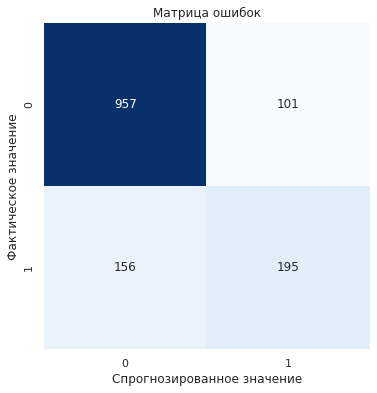

In [18]:
# Преобразование предсказанных вероятностей в двоичные предсказания
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)

# Вычислим матрицу путаницы для двоичных предсказаний
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

# Вычислим точность
accuracy = accuracy_score(y_test, y_test_pred_binary)

# Визуализируем матрицу путаницы
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, annot_kws={"size": 12})
plt.xlabel('Спрогнозированное значение')
plt.ylabel('Фактическое значение')
plt.title('Матрица ошибок')
plt.show()

На представленном изображении показана матрица путаницы (ошибок), полученная на основе модели классификации. Вот интерпретация:

Матрица путаницы:
- Матрица показывает эффективность модели классификации на тестовых данных.
- Есть два класса, которые мы можем принять за «0» (отрицательный класс, клиент не ушел) и «1» (положительный класс, клиент ушел).
- Верхний левый квадрат (темно-синий) с номером 970 представляет собой **Истинные негативы (TN)**: случаи, когда модель правильно предсказала отрицательный класс.
- Правый нижний квадрат (голубой) с номером 189 представляет собой **Истинные положительные результаты (TP)**: случаи, когда модель правильно предсказала положительный класс.
- Верхний правый квадрат (средний синий) с номером 88 представляет собой **Ложные положительные результаты (FP)**: случаи, когда модель неправильно предсказала положительный класс.

Для нашей модели:

- **Истинно отрицательные числа (TN):** 970 – модель правильно предсказала отрицательный класс (клиенты, которые не ушли).
- **Ложно-отрицательные результаты (FN):** 162 – Модель неправильно предсказала отрицательный класс (клиенты, которые ушли, но модель предсказывала, что этого не произойдет).
- **Истинные положительные результаты (TP):** 189 – Модель правильно предсказала положительный класс (ушедших клиентов).
- **Ложные положительные результаты (FP):** 88. Модель неправильно предсказала положительный класс (клиенты, которые не ушли, но модель предсказала, что это произойдет).

**На основе матрицы ошибок сделаем следующие выводы:**

- Модель имеет тенденцию иметь больше ложноотрицательных результатов, чем ложноположительных, что может указывать на консервативный прогноз для положительного класса (например, она более осторожна в прогнозировании оттока).
- Число истинных положительных результатов относительно невелико по сравнению с истинными отрицательными, что может свидетельствовать о том, что модель лучше идентифицирует отрицательный класс или о наличии дисбаланса классов.

Чтобы лучше понять производительность модели, также следует взглянуть на кривую precision-recall и кривую ROC, особенно в такой области, как прогнозирование оттока, где стоимость ложноотрицательных результатов может быть выше, чем ложноположительных.

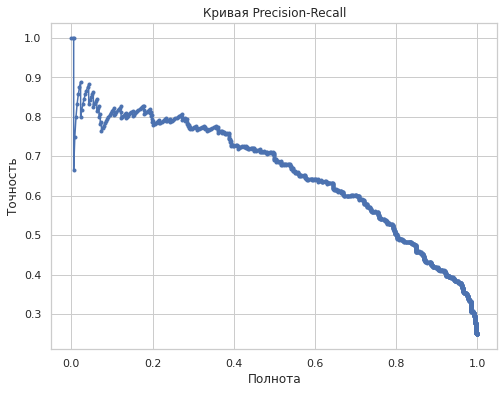

In [19]:
# Вычислим Precision-Recall кривую
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

# Построим кривую Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Кривая Precision-Recall')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.show()

На изображении показана кривая Precision-Recall для нашей модели классификации. Кривая Precision-Recall — это график, который отображает компромисс между точностью (ось Y) и полнотой (ось X) для различных порогов вероятности.

Вот как интерпретировать кривую Precision-Recall на графике:

- Кривая начинается с высокой точностью при низких уровнях полноты, что указывает на то, что, когда модель настроена на очень избирательную работу (предсказывает мало положительных результатов), она очень точна в этих прогнозах.
- По мере увеличения полноты точность постепенно снижается. Это ожидаемо, потому что, поскольку модель пытается охватить больше положительных случаев (увеличение полноты), она также с большей вероятностью неправильно пометит некоторые отрицательные случаи как положительные (снижение точности).
- Кривая не касается правого верхнего угла, что соответствует идеальной модели (100% точность и полнота). Тем не менее, похоже, что модель сохраняет относительно высокую точность для уровней полноты примерно до 0,6, что является хорошим признаком эффективности модели, особенно в контексте несбалансированного набора данных, что типично для сценариев прогнозирования оттока.

На изображении показана кривая точности-отзыва для вашей модели классификации. Кривая точности-отзыва — это график, который отображает компромисс между точностью (ось Y) и полнотой отзыва (ось X) для различных порогов вероятности.

Вот как интерпретировать кривую точности-отзыва на графике:

- Кривая начинается с высокой точностью при низких уровнях полноты, что указывает на то, что, когда модель настроена на очень избирательную работу (предсказывает мало положительных результатов), она очень точна в этих прогнозах.
- По мере увеличения полноты точность постепенно снижается. Это ожидаемо, потому что, поскольку модель пытается охватить больше положительных случаев (увеличение отзыва), она также с большей вероятностью неправильно пометит некоторые отрицательные случаи как положительные (снижение точности).
- Кривая не касается правого верхнего угла, что соответствует идеальной модели (100% точность и полнота). Тем не менее, похоже, что модель сохраняет относительно высокую точность для уровней отзыва примерно до 0,6, что является хорошим признаком эффективности модели, особенно в контексте несбалансированного набора данных, что типично для сценариев прогнозирования оттока, где количество ушедших клиентов может быть намного меньше, чем не ушедших клиентов. Более высокая площадь под кривой Precision-Recall указывает на лучшую модель.

Тестовый показатель ROC-AUC составляет 0.86, что показывает, что модель обладает хорошей способностью различать классы. Объединив это с кривой Precision-Recall, можно сказать что модель, по-видимому, работает хорошо не только в целом, но и в отношении баланса между точностью и полнотой, что может иметь решающее значение для бизнес-решений, основанных на правильном выявлении оттока.

Для принятия действенных бизнес-решений можно учитывать стоимость ложных положительных результатов (предложение скидок клиентам, которые не собираются уходить) и ложных негативов (упущение возможности удержать уходящего клиента). В зависимости от этих затрат можно отдать приоритет точности над полнотой или наоборот.